In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import joblib
import math
import logging
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib
# matplotlib.use('Agg')  # Non-interactive backend for cluster
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib as mpl
import re

2026-02-17 15:55:39.139379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-17 15:55:39.139414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-17 15:55:39.190368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
tf.get_logger().setLevel(logging.ERROR)
tf.keras.backend.clear_session()

In [4]:
# Multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 4


In [5]:
def create_embedding_network(input_dim, hidden_dim, output_dim):
    """Create a deep embedding network."""
    return keras.Sequential([
        layers.BatchNormalization(input_shape=(input_dim,)),
        layers.Dense(hidden_dim),
        layers.BatchNormalization(),
        layers.Activation('gelu'),
        layers.Dense(hidden_dim),
        layers.BatchNormalization(),
        layers.Activation('gelu'),
        layers.Dense(output_dim)
    ])

In [6]:
class TransformerEncoderBlock(layers.Layer):
    """Transformer encoder block with multi-head attention."""
    def __init__(self, embedding_dim, num_heads=4, ff_dim_factor=4, dropout_rate=0.1):
        super().__init__()
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads
        )
        self.ffn = keras.Sequential([
            layers.Dense(embedding_dim * ff_dim_factor),
            layers.Activation('gelu'),
            layers.Dense(embedding_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        
    def call(self, inputs, training=False):
        attention_output = self.attention(query=inputs, key=inputs, value=inputs)
        attention_output = self.dropout1(attention_output, training=training)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [7]:
class MultiHeadAttentionPooling(layers.Layer):
    def __init__(self, embedding_dim, num_heads=4, dropout_rate=0.5):
        super().__init__()
        self.num_heads = num_heads
        self.seed = self.add_weight(
            name="pooling_seed",
            shape=(1, 1, embedding_dim), 
            initializer="glorot_uniform",
            trainable=True
        )
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embedding_dim,
            dropout=dropout_rate
        )
        self.layernorm = layers.LayerNormalization()
        self.dropout = layers.Dropout(dropout_rate)
    
    def call(self, x, mask=None):
        batch_size = tf.shape(x)[0]
        seed = tf.tile(self.seed, [batch_size, 1, 1])
        attn_output = self.mha(query=seed, value=x, key=x, attention_mask=mask)
        attn_output = self.dropout(attn_output)
        return tf.squeeze(attn_output, axis=1)

In [8]:
class ContrastiveParticleTransformer(keras.Model):
    """Contrastive transformer adapted for ATLAS VLL inputs (electrons, photons, DVtracks).
    
    Uses new architecture (larger dims, AdamW, cosine schedule) with old input format.
    Labels are integer class indices (no weighted distance).
    No Gaussian noise.
    """
    def __init__(
        self,
        # Object counts (old inputs)
        max_electrons=4,
        max_photons=4,
        max_dvtrack=4,
        # Feature dimensions (old inputs)
        electron_features=14,
        photon_features=12,
        dvtrack_features=9,
        # Architecture (new model scale)
        hidden_dim=64,
        common_embedding_dim=16,
        num_encoder_layers=4,
        num_heads=4,
        dropout_rate=0.1,
        temperature=0.1,
        # Projection head
        projection_dim=6,
        projection_hidden_dim=32,
        # Regularization
        variance_weight=1.0,
        decorr_weight=0.05,
        **kwargs
    ):
        super().__init__(**kwargs)
        
        # Config
        self.n_tokens = max_electrons + max_photons + max_dvtrack  # 12 tokens
        self.temperature = temperature
        self.variance_weight = variance_weight
        self.decorr_weight = decorr_weight
        self.common_embedding_dim = common_embedding_dim
        
        # Loss trackers
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.val_loss_tracker = keras.metrics.Mean(name="val_loss")
        self.contrastive_loss_tracker = keras.metrics.Mean(name="contrastive")
        self.variance_loss_tracker = keras.metrics.Mean(name="variance")
        self.decorr_loss_tracker = keras.metrics.Mean(name="decorr")
        self.separation_tracker = keras.metrics.Mean(name="separation")
        self.mean_std_tracker = keras.metrics.Mean(name="mean_std")
        
        # Positional embedding
        self.pos_embedding = self.add_weight(
            name="pos_embedding",
            shape=[self.n_tokens, common_embedding_dim],
            initializer='random_normal'
        )
        
        # --- 1. Specialized Input Embedders ---
        self.electron_embedding = create_embedding_network(electron_features, hidden_dim, common_embedding_dim)
        self.photon_embedding = create_embedding_network(photon_features, hidden_dim, common_embedding_dim)
        self.dvtrack_embedding = create_embedding_network(dvtrack_features, hidden_dim, common_embedding_dim)
        
        # --- 2. Transformer Backbone ---
        self.encoder_layers = [
            TransformerEncoderBlock(common_embedding_dim, num_heads, dropout_rate=dropout_rate)
            for _ in range(num_encoder_layers)
        ]
        self.global_pool = MultiHeadAttentionPooling(common_embedding_dim, dropout_rate=dropout_rate)
        
        # --- 3. Projection Head ---
        self.projection_head = keras.Sequential([
            layers.Dense(projection_hidden_dim, use_bias=False),
            layers.BatchNormalization(), 
            layers.Activation('relu'),
            layers.Dense(projection_dim),
        ], name='projection_head')
    
    def encode(self, inputs, training=False, use_projection=True):
        """Encode particles into latent representation."""
        electron_input = inputs["electron_input"]
        photon_input = inputs["photon_input"]
        dvtrack_input = inputs["dvtrack_input"]
        
        # Embed each particle type
        e_emb = layers.TimeDistributed(self.electron_embedding)(electron_input)
        p_emb = layers.TimeDistributed(self.photon_embedding)(photon_input)
        t_emb = layers.TimeDistributed(self.dvtrack_embedding)(dvtrack_input)
        
        # Combine: (B, 12, D)
        combined = tf.concat([e_emb, p_emb, t_emb], axis=1)
        combined = combined + self.pos_embedding[None, :, :]
        
        # Transformer encoder
        encoded = combined
        for encoder_layer in self.encoder_layers:
            encoded = encoder_layer(encoded, training=training)
        
        # Base embedding - normalized
        base_embedding = self.global_pool(encoded)
        latent_base = tf.nn.l2_normalize(base_embedding, axis=-1)
        
        # Projection - normalized
        if use_projection:
            projection = self.projection_head(latent_base, training=training)
            latent_projection = tf.nn.l2_normalize(projection, axis=-1)
            return latent_base, latent_projection
        
        return latent_base, None
    
    def call(self, inputs, training=False):
        latent_base, latent_projection = self.encode(inputs, training=training, use_projection=True)
        return {
            "latent_base": latent_base,
            "latent_projection": latent_projection
        }

    def compute_variance_loss(self, latent):
        """Variance loss for L2-normalized embeddings."""
        std_per_dim = tf.math.reduce_std(latent, axis=0)
        dim = tf.cast(tf.shape(latent)[1], tf.float32)
        target_std = 0.9 / tf.sqrt(dim)
        variance_loss = tf.reduce_mean(tf.square(tf.nn.relu(target_std - std_per_dim)))
        return variance_loss, tf.reduce_mean(std_per_dim)
        
    def compute_decorrelation_loss(self, latent):
        """Penalize correlated dimensions in the latent space."""
        batch_mean = tf.reduce_mean(latent, axis=0, keepdims=True)
        centered = latent - batch_mean
        batch_size = tf.cast(tf.shape(latent)[0], tf.float32)
        cov = tf.matmul(centered, centered, transpose_a=True) / tf.maximum(batch_size - 1.0, 1.0)
        
        std = tf.math.reduce_std(latent, axis=0, keepdims=True)
        std_outer = tf.matmul(tf.transpose(std), std) + 1e-8
        corr = cov / std_outer
        
        num_features = tf.cast(tf.shape(latent)[1], tf.float32)
        diag_part = tf.linalg.diag_part(corr)
        off_diagonal_sum = tf.reduce_sum(tf.square(corr)) - tf.reduce_sum(tf.square(diag_part))
        
        return off_diagonal_sum / (num_features * (num_features - 1))
    
    def contrastive_loss_with_metrics(self, z, labels):
        """InfoNCE Loss with integer class labels."""
        S = tf.matmul(z, z, transpose_b=True)
        
        B = tf.shape(S)[0]
        diag_mask = tf.eye(B, dtype=tf.float32)
        offdiag_mask = 1.0 - diag_mask
        
        labels_float = tf.cast(labels, tf.float32)
        same_mask = tf.cast(tf.abs(labels_float[:, None] - labels_float[None, :]) < 0.5, tf.float32)
        
        pos_mask = same_mask * offdiag_mask
        neg_mask = (1.0 - same_mask) * offdiag_mask
        
        logits = S / self.temperature
        logits = logits - tf.reduce_max(logits, axis=1, keepdims=True)
        exp_logits = tf.exp(logits)
        
        denom = tf.reduce_sum(exp_logits * offdiag_mask, axis=1, keepdims=True) + 1e-8
        log_probs = logits - tf.math.log(denom)
        
        num_pos = tf.reduce_sum(pos_mask, axis=1)
        pos_sum = tf.reduce_sum(log_probs * pos_mask, axis=1)
        
        has_pos = tf.cast(num_pos > 0.5, tf.float32)
        mean_log_prob_pos = (pos_sum / (num_pos + 1e-8)) * has_pos
        
        loss = -tf.reduce_sum(mean_log_prob_pos) / (tf.reduce_sum(has_pos) + 1e-8)
        
        mu_pos = tf.reduce_sum(S * pos_mask) / (tf.reduce_sum(pos_mask) + 1e-8)
        mu_neg = tf.reduce_sum(S * neg_mask) / (tf.reduce_sum(neg_mask) + 1e-8)
        separation = mu_pos - mu_neg
        
        return loss, separation
    
    def train_step(self, data):
        x, labels = data
        
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            latent_base = outputs["latent_base"]
            latent_projection = outputs["latent_projection"]
            
            # Contrastive on projection
            contrastive_loss, separation = self.contrastive_loss_with_metrics(latent_projection, labels)
            # Variance on base
            variance_loss, mean_std = self.compute_variance_loss(latent_base)
            # Decorrelation on projection
            decorr_loss = self.compute_decorrelation_loss(latent_projection)
            
            total_loss = (
                contrastive_loss +
                self.variance_weight * variance_loss +
                self.decorr_weight * decorr_loss
            )
            
            if self.losses:
                total_loss += tf.add_n(self.losses)
        
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.loss_tracker.update_state(total_loss)
        self.contrastive_loss_tracker.update_state(contrastive_loss)
        self.variance_loss_tracker.update_state(variance_loss)
        self.decorr_loss_tracker.update_state(decorr_loss)
        self.separation_tracker.update_state(separation)
        self.mean_std_tracker.update_state(mean_std)
        
        return {
            "loss": self.loss_tracker.result(),
            "contrastive": self.contrastive_loss_tracker.result(),
            "variance": self.variance_loss_tracker.result(),
            "decorr": self.decorr_loss_tracker.result(),
            "separation": self.separation_tracker.result(),
            "mean_std": self.mean_std_tracker.result(),
        }

    def test_step(self, data):
        x, labels = data
        
        outputs = self(x, training=False)
        latent_base = outputs["latent_base"]
        latent_projection = outputs["latent_projection"]
        
        contrastive_loss, separation = self.contrastive_loss_with_metrics(latent_projection, labels)
        variance_loss, mean_std = self.compute_variance_loss(latent_base)
        decorr_loss = self.compute_decorrelation_loss(latent_projection)
        
        total_loss = (
            contrastive_loss +
            self.variance_weight * variance_loss +
            self.decorr_weight * decorr_loss
        )
        
        self.val_loss_tracker.update_state(total_loss)
        self.separation_tracker.update_state(separation)
        self.mean_std_tracker.update_state(mean_std)
        
        return {
            "loss": self.val_loss_tracker.result(),
            "separation": self.separation_tracker.result(),
            "mean_std": self.mean_std_tracker.result(),
        }

    @property
    def metrics(self):
        return [
            self.loss_tracker,
            self.val_loss_tracker,
            self.contrastive_loss_tracker,
            self.variance_loss_tracker,
            self.decorr_loss_tracker,
            self.separation_tracker,
            self.mean_std_tracker,
        ]

In [9]:
class ContrastiveDataGenerator(keras.utils.Sequence):
    """Data generator using integer labels (no string/weighted distance).
    
    data_dict: {model_name: (electrons, photons, dvtracks)} 
    Returns: ({"electron_input", "photon_input", "dvtrack_input"}, int_labels)
    """
    def __init__(self, data_dict, samples_per_model=500, shuffle=True):
        self.data_dict = data_dict
        self.model_names = list(data_dict.keys())
        self.samples_per_model = samples_per_model
        self.shuffle = shuffle
        
        # Integer label mapping
        self.label_to_idx = {name: i for i, name in enumerate(self.model_names)}
        self.lengths = {name: len(v[0]) for name, v in data_dict.items()}
        self.max_len = max(self.lengths.values())
        self.n_batches = math.ceil(self.max_len / self.samples_per_model)

        # Per-model index arrays for proper shuffling
        self.indices = {
            name: np.arange(length) 
            for name, length in self.lengths.items()
        }
        self.on_epoch_end()

    def __len__(self):
        return self.n_batches

    def on_epoch_end(self):
        if self.shuffle:
            for name in self.model_names:
                np.random.shuffle(self.indices[name])

    def __getitem__(self, index):
        batch_e, batch_p, batch_t, batch_labels = [], [], [], []
        
        for model_name in self.model_names:
            electrons, photons, dvtracks = self.data_dict[model_name]
            indices = self.indices[model_name]
            n = len(electrons)
            label_idx = self.label_to_idx[model_name]
            
            start = (index * self.samples_per_model) % n
            end = start + self.samples_per_model
            
            if end <= n:
                selected_indices = indices[start:end]
            else:
                extra = end - n
                selected_indices = np.concatenate([indices[start:n], indices[0:extra]])
            
            batch_e.append(electrons[selected_indices])
            batch_p.append(photons[selected_indices])
            batch_t.append(dvtracks[selected_indices])
            batch_labels.extend([label_idx] * len(selected_indices))
        
        batch_e = np.concatenate(batch_e, axis=0)
        batch_p = np.concatenate(batch_p, axis=0)
        batch_t = np.concatenate(batch_t, axis=0)
        batch_labels = np.array(batch_labels, dtype=np.int32)
        
        if self.shuffle:
            perm = np.random.permutation(len(batch_labels))
            batch_e = batch_e[perm]
            batch_p = batch_p[perm]
            batch_t = batch_t[perm]
            batch_labels = batch_labels[perm]
        
        inputs = {
            "electron_input": batch_e,
            "photon_input": batch_p,
            "dvtrack_input": batch_t,
        }
        return inputs, batch_labels

In [10]:
class WarmUpCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, warmup_steps):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_lr = self.initial_learning_rate * (step / self.warmup_steps)
        decay_step = tf.minimum(step - self.warmup_steps, self.decay_steps)
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * decay_step / self.decay_steps))
        decayed_lr = self.initial_learning_rate * cosine_decay
        return tf.where(step < self.warmup_steps, warmup_lr, decayed_lr)
    
    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_steps": self.decay_steps,
            "warmup_steps": self.warmup_steps,
        }

In [11]:
data_dir = Path("/pscratch/sd/h/hjia625/analysis_vll_data_dir")
checkpoint_dir = Path("/pscratch/sd/h/hjia625/analysis_vll_checkpoint")
checkpoint_dir.mkdir(parents=True, exist_ok=True)
# --- 1. Load pre-saved data ---
print("Loading pre-saved data...")
train_data_dict = joblib.load(data_dir / "train_data_dict.pkl")
val_data_dict = joblib.load(data_dir / "val_data_dict.pkl")
print(f"Loaded train_data_dict ({len(train_data_dict)} models) and val_data_dict ({len(val_data_dict)} models)")
print
print(f"Train: {len(train_data_dict)} models")
for name, (e, p, t) in train_data_dict.items():
    print(f"  {name}: {e.shape[0]} events | e{e.shape[1:]}, p{p.shape[1:]}, t{t.shape[1:]}")
print(f"Val: {len(val_data_dict)} models")
for name, (e, p, t) in val_data_dict.items():
    print(f"  {name}: {e.shape[0]} events")

Loading pre-saved data...
Loaded train_data_dict (12 models) and val_data_dict (12 models)
Train: 12 models
  60_25_0.1ns: 16507 events | e(4, 14), p(4, 12), t(4, 9)
  60_25_0.5ns: 5779 events | e(4, 14), p(4, 12), t(4, 9)
  60_25_2ns: 6551 events | e(4, 14), p(4, 12), t(4, 9)
  125_60_0.1ns: 21683 events | e(4, 14), p(4, 12), t(4, 9)
  125_60_0.5ns: 17541 events | e(4, 14), p(4, 12), t(4, 9)
  125_60_10ns: 7012 events | e(4, 14), p(4, 12), t(4, 9)
  400_15_0.1ns: 28807 events | e(4, 14), p(4, 12), t(4, 9)
  400_15_0.5ns: 41628 events | e(4, 14), p(4, 12), t(4, 9)
  400_15_10ns: 8257 events | e(4, 14), p(4, 12), t(4, 9)
  600_290_0.1ns: 70918 events | e(4, 14), p(4, 12), t(4, 9)
  600_290_0.5ns: 36798 events | e(4, 14), p(4, 12), t(4, 9)
  600_290_10ns: 15889 events | e(4, 14), p(4, 12), t(4, 9)
Val: 12 models
  60_25_0.1ns: 4127 events
  60_25_0.5ns: 5779 events
  60_25_2ns: 6551 events
  125_60_0.1ns: 5421 events
  125_60_0.5ns: 4386 events
  125_60_10ns: 7012 events
  400_15_0.1ns: 

In [12]:
N_MODELS = len(train_data_dict)
SAMPLES_PER_MODEL = 1024  # Scaled up for GPU
GLOBAL_BATCH_SIZE = SAMPLES_PER_MODEL * N_MODELS

avg_dataset_size = np.mean([len(v[0]) for v in train_data_dict.values()])
STEPS_PER_EPOCH = max(1, int(avg_dataset_size // SAMPLES_PER_MODEL))

EPOCHS = 200
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
WARMUP_STEPS = 50 * STEPS_PER_EPOCH
PEAK_LR = 1e-4

print(f"\n--- Configuration ---")
print(f"Number of models:  {N_MODELS}")
print(f"Samples per model: {SAMPLES_PER_MODEL}")
print(f"Global Batch Size: {GLOBAL_BATCH_SIZE}")
print(f"Steps Per Epoch:   {STEPS_PER_EPOCH}")
print(f"Total Steps:       {TOTAL_STEPS}")
print(f"Warmup Steps:      {WARMUP_STEPS}")
print(f"Peak LR:           {PEAK_LR}")
print(f"GPUs:              {strategy.num_replicas_in_sync}")



--- Configuration ---
Number of models:  12
Samples per model: 1024
Global Batch Size: 12288
Steps Per Epoch:   22
Total Steps:       4400
Warmup Steps:      1100
Peak LR:           0.0001
GPUs:              4


In [66]:
train_gen = ContrastiveDataGenerator(
    data_dict=train_data_dict,
    samples_per_model=SAMPLES_PER_MODEL,
    shuffle=True
)
val_gen = ContrastiveDataGenerator(
    data_dict=val_data_dict,
    samples_per_model=SAMPLES_PER_MODEL, 
    shuffle=True
)

In [67]:
lr_schedule = WarmUpCosineDecay(
    initial_learning_rate=PEAK_LR,
    decay_steps=TOTAL_STEPS - WARMUP_STEPS,
    warmup_steps=WARMUP_STEPS
)

In [68]:
with strategy.scope():
    model = ContrastiveParticleTransformer(
        max_electrons=4,
        max_photons=4,
        max_dvtrack=4,
        electron_features=14,
        photon_features=12,
        dvtrack_features=9,
        hidden_dim=64,
        common_embedding_dim=32,
        num_encoder_layers=4,
        num_heads=4,
        dropout_rate=0.5,
        projection_dim=8,
        projection_hidden_dim=32,
        temperature=0.07,
        variance_weight=1.0,
        decorr_weight=0.0,
    )

    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay=1e-4,
            global_clipnorm=1.0,
        ),
        jit_compile=False
    )

    # Build with dummy input
    dummy_input = {
        "electron_input": np.zeros((2, 4, 14), dtype=np.float32),
        "photon_input": np.zeros((2, 4, 12), dtype=np.float32),
        "dvtrack_input": np.zeros((2, 4, 9), dtype=np.float32),
    }
    _ = model(dummy_input, training=True)

model.summary()

Model: "contrastive_particle_transformer_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_56 (Sequential)  (None, 32)                7768      
                                                                 
 sequential_57 (Sequential)  (None, 32)                7632      
                                                                 
 sequential_58 (Sequential)  (None, 32)                7428      
                                                                 
 transformer_encoder_block_  multiple                  12704     
 32 (TransformerEncoderBloc                                      
 k)                                                              
                                                                 
 transformer_encoder_block_  multiple                  12704     
 33 (TransformerEncoderBloc                                      
 k)                             

In [69]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=str(checkpoint_dir / 'contrastive_transformer_best.keras'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.TensorBoard(log_dir=str(checkpoint_dir / 'logs')),
]

In [70]:
print("\nStarting training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)


Starting training...
Epoch 1/200
69/70 [============================>.] - ETA: 0s - loss: 11.5925 - contrastive: 11.5918 - variance: 6.7096e-04 - decorr: 0.0295 - separation: 0.0054 - mean_std: 0.1481   
Epoch 1: val_loss improved from inf to 8.67141, saving model to /pscratch/sd/h/hjia625/analysis_vll_checkpoint/contrastive_transformer_best.keras
70/70 [==============================] - 55s 110ms/step - loss: 11.5910 - contrastive: 11.5903 - variance: 6.7063e-04 - decorr: 0.0295 - separation: 0.0054 - mean_std: 0.1481 - val_loss: 8.6714 - val_separation: 0.0328 - val_mean_std: 0.0864
Epoch 2/200
70/70 [==============================] - ETA: 0s - loss: 11.2770 - contrastive: 11.2763 - variance: 6.9296e-04 - decorr: 0.0279 - separation: 0.0067 - mean_std: 0.1479
Epoch 2: val_loss improved from 8.67141 to 8.33000, saving model to /pscratch/sd/h/hjia625/analysis_vll_checkpoint/contrastive_transformer_best.keras
70/70 [==============================] - 4s 61ms/step - loss: 11.2770 - contr

In [71]:
model.save(str(checkpoint_dir / 'contrastive_transformer_final.keras'))
print(f"Final model saved to {checkpoint_dir / 'contrastive_transformer_final.keras'}")


Final model saved to /pscratch/sd/h/hjia625/analysis_vll_checkpoint/contrastive_transformer_final.keras


Training history plot saved to /pscratch/sd/h/hjia625/analysis_vll_checkpoint/training_history.png
Done!


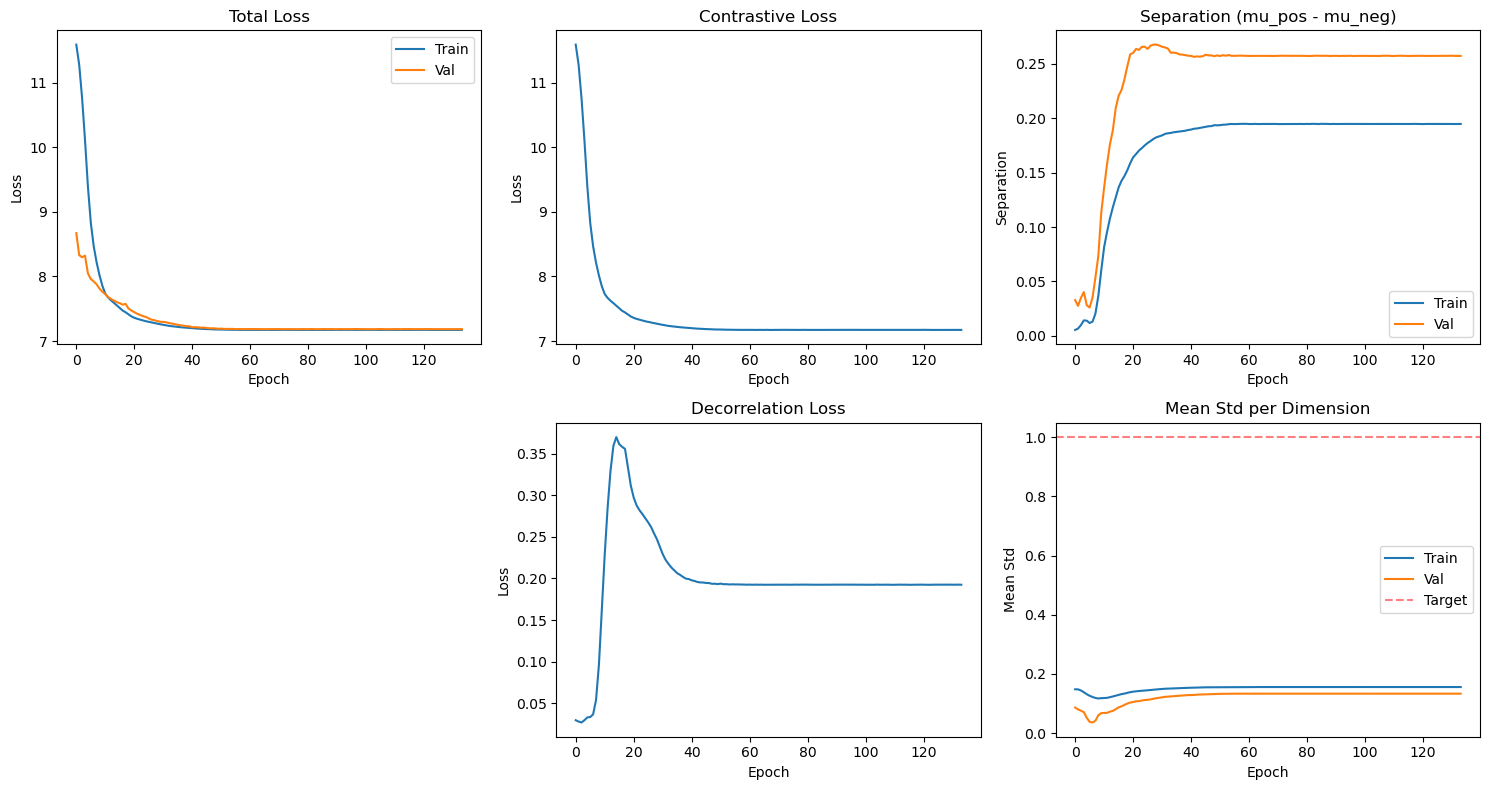

In [72]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0, 0].plot(history.history['loss'], label='Train')
axes[0, 0].plot(history.history['val_loss'], label='Val')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()

axes[0, 1].plot(history.history['contrastive'], label='Train')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Contrastive Loss')

axes[0, 2].plot(history.history['separation'], label='Train')
axes[0, 2].plot(history.history['val_separation'], label='Val')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Separation')
axes[0, 2].set_title('Separation (mu_pos - mu_neg)')
axes[0, 2].legend()

axes[1, 0].axis('off')

axes[1, 1].plot(history.history['decorr'], label='Train')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Decorrelation Loss')

axes[1, 2].plot(history.history['mean_std'], label='Train')
axes[1, 2].plot(history.history['val_mean_std'], label='Val')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('Mean Std')
axes[1, 2].set_title('Mean Std per Dimension')
axes[1, 2].axhline(1.0, color='r', linestyle='--', alpha=0.5, label='Target')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig(checkpoint_dir / 'training_history.png', dpi=150)
# plt.show()
print(f"Training history plot saved to {checkpoint_dir / 'training_history.png'}")
print("Done!")

In [13]:
model_path = checkpoint_dir / "contrastive_transformer_best.keras"

print("Loading model...")
model = ContrastiveParticleTransformer(
    max_electrons=4,
    max_photons=4,
    max_dvtrack=4,
    electron_features=14,
    photon_features=12,
    dvtrack_features=9,
    hidden_dim=64,
    common_embedding_dim=32,
    num_encoder_layers=4,
    num_heads=4,
    dropout_rate=0.5,
    projection_dim=8,
    projection_hidden_dim=32,
    temperature=0.07,
    variance_weight=1.0,
    decorr_weight=0.0,
)

# Build with dummy input
dummy_input = {
    "electron_input": np.zeros((2, 4, 14), dtype=np.float32),
    "photon_input": np.zeros((2, 4, 12), dtype=np.float32),
    "dvtrack_input": np.zeros((2, 4, 9), dtype=np.float32),
}
_ = model(dummy_input, training=False)

model.load_weights(model_path)
print("Weights loaded successfully.")

Loading model...
Weights loaded successfully.


In [14]:
# ============================================================================
# 2. EXTRACT EMBEDDINGS PER MODEL
# ============================================================================
print("Extracting embeddings...")
model_names = list(train_data_dict.keys())
embeddings_per_model = {}

for name in model_names:
    e, p, t = val_data_dict[name]
    inputs = {
        "electron_input": e.astype(np.float32),
        "photon_input": p.astype(np.float32),
        "dvtrack_input": t.astype(np.float32),
    }
    latent_base, _ = model.encode(inputs, training=False, use_projection=False)
    embeddings_per_model[name] = latent_base.numpy()
    print(f"  {name}: {latent_base.shape}")

embedding_dim = list(embeddings_per_model.values())[0].shape[1]
print(f"\nEmbedding dimension: {embedding_dim}")
print(f"Models: {len(model_names)}")


Extracting embeddings...
  60_25_0.1ns: (4127, 32)
  60_25_0.5ns: (5779, 32)
  60_25_2ns: (6551, 32)
  125_60_0.1ns: (5421, 32)
  125_60_0.5ns: (4386, 32)
  125_60_10ns: (7012, 32)
  400_15_0.1ns: (7202, 32)
  400_15_0.5ns: (10408, 32)
  400_15_10ns: (2065, 32)
  600_290_0.1ns: (17730, 32)
  600_290_0.5ns: (9200, 32)
  600_290_10ns: (3973, 32)

Embedding dimension: 32
Models: 12



Plotting per-dimension distributions...


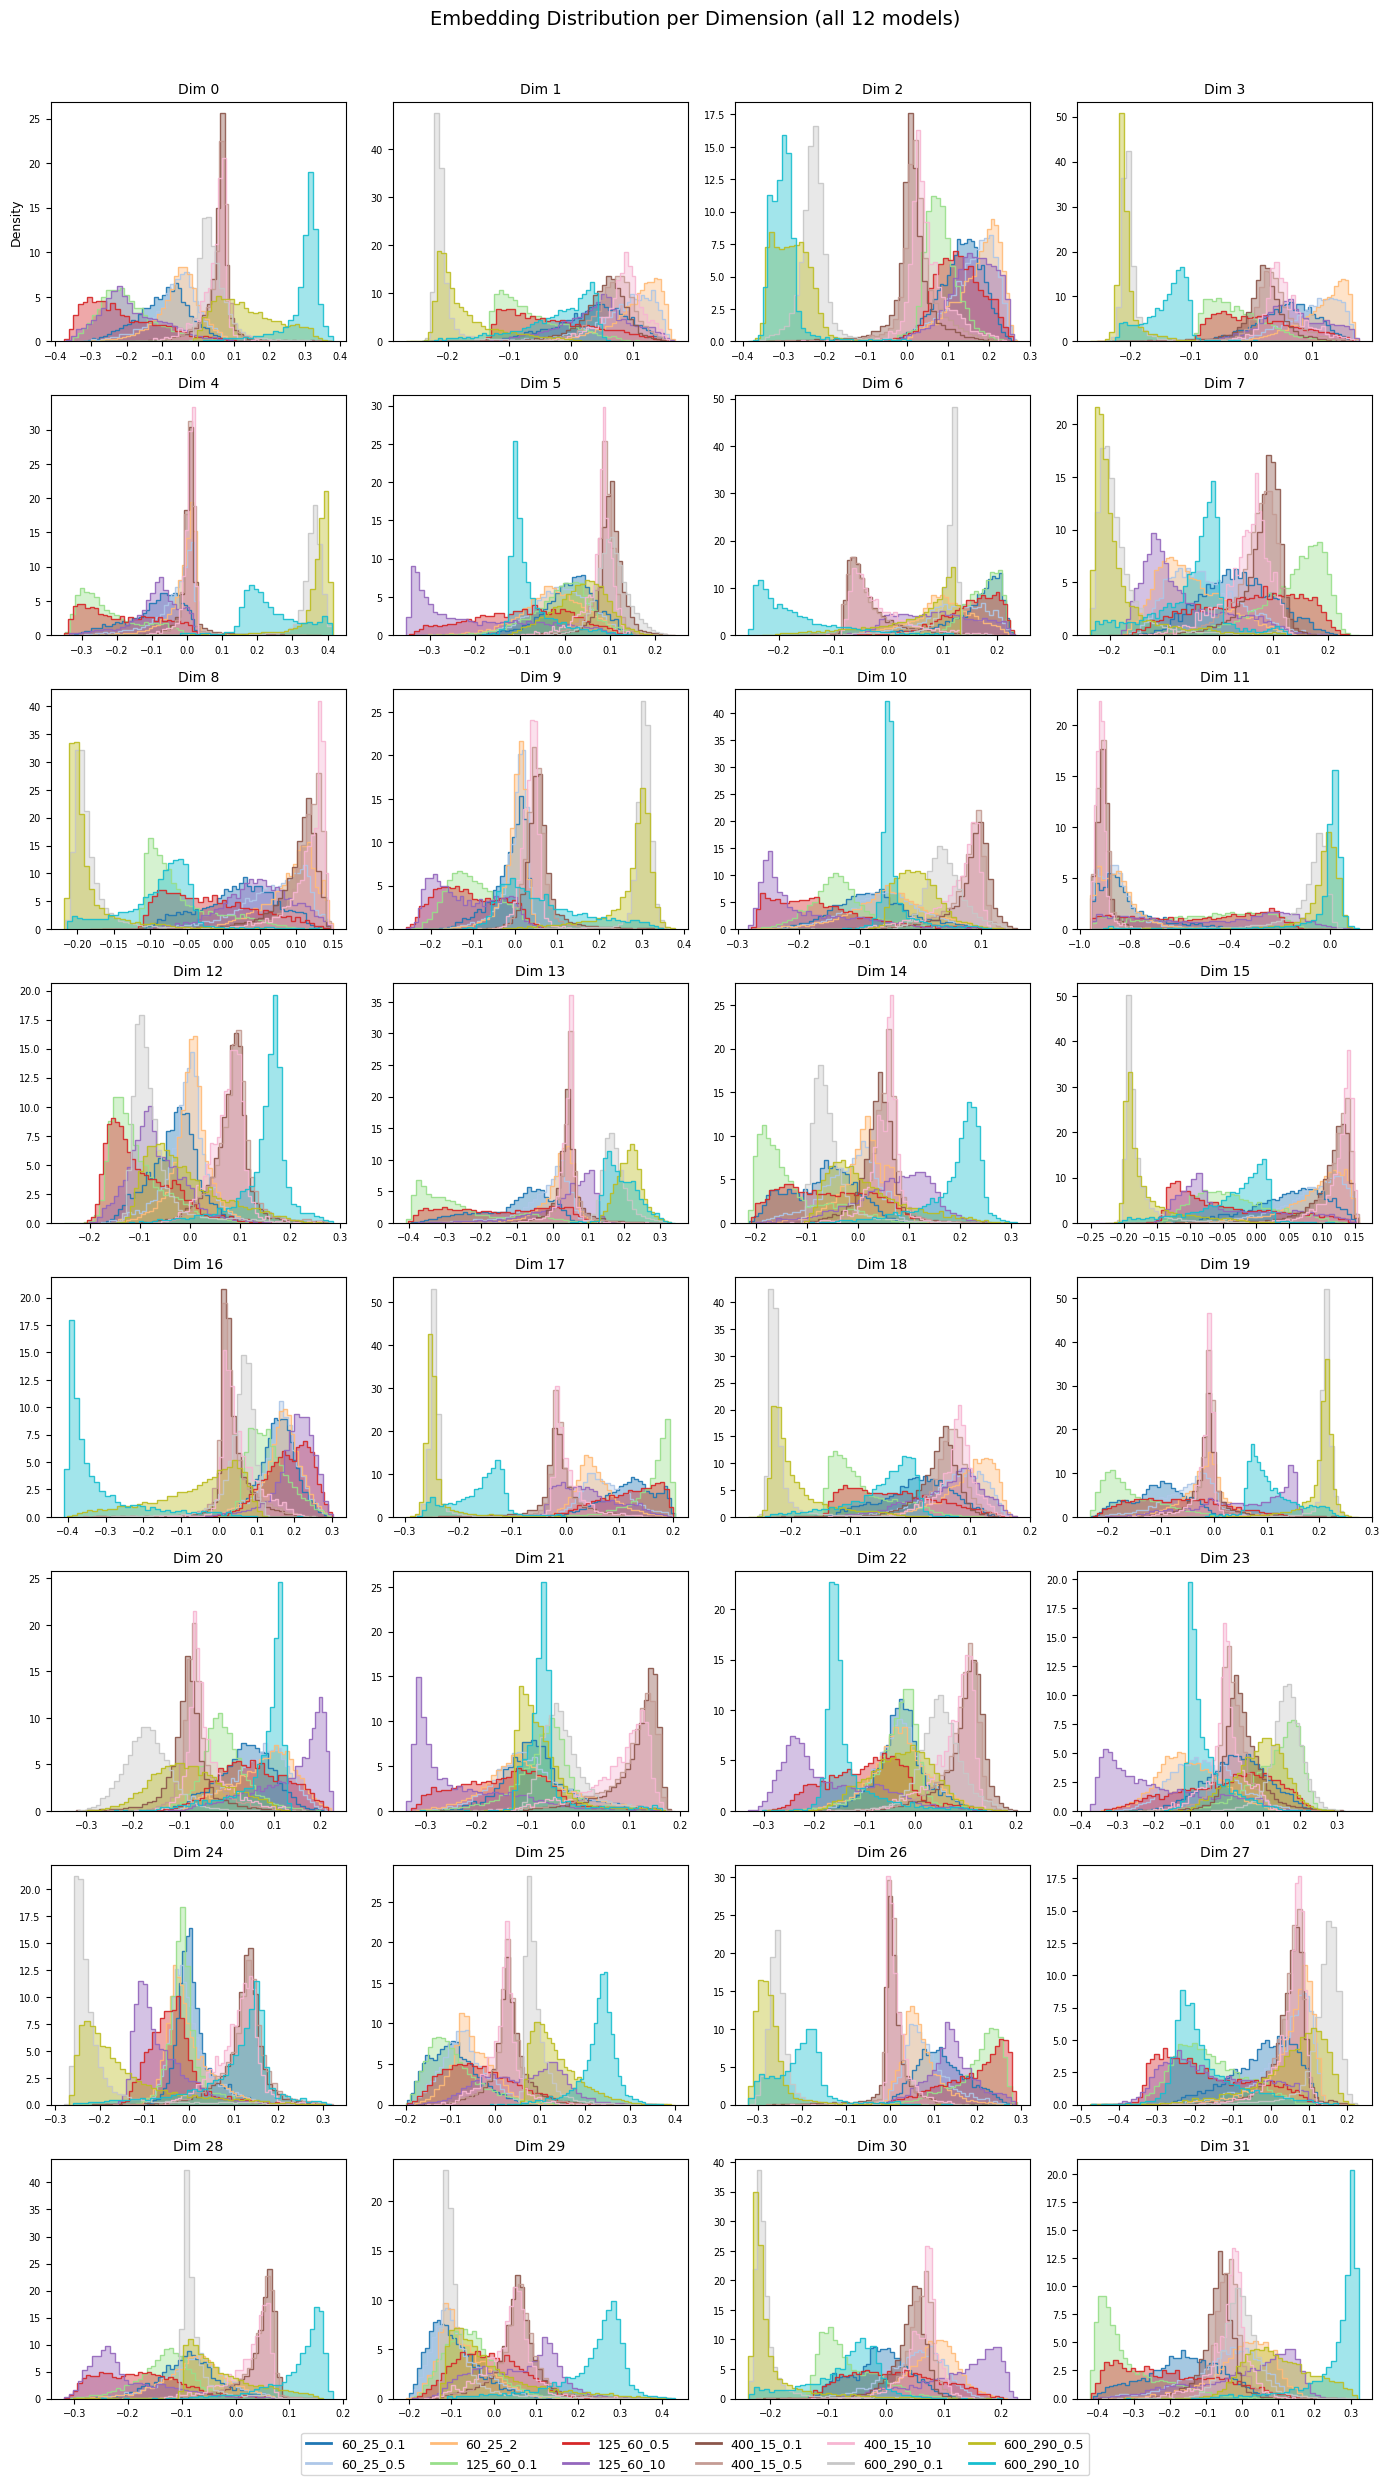

Saved: /pscratch/sd/h/hjia625/analysis_vll_checkpoint/embedding_per_dimension.png


In [15]:
# ============================================================================
# 3. PLOT 1: Per-dimension histograms (all 32 dimensions)
# ============================================================================
print("\nPlotting per-dimension distributions...")

# Use a colormap with enough distinct colors for 12 models
cmap = plt.cm.tab20
colors = [cmap(i / len(model_names)) for i in range(len(model_names))]

# Short labels for legend
short_names = [n.replace('ns', '') for n in model_names]

n_cols = 4
n_rows = int(np.ceil(embedding_dim / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))
axes = axes.flatten()

for dim_idx in range(embedding_dim):
    ax = axes[dim_idx]
    for model_idx, name in enumerate(model_names):
        vals = embeddings_per_model[name][:, dim_idx]
        ax.hist(vals, bins=50, alpha=0.4, color=colors[model_idx],
                density=True, histtype='stepfilled', linewidth=0)
        ax.hist(vals, bins=50, alpha=0.9, color=colors[model_idx],
                density=True, histtype='step', linewidth=1.0)
    ax.set_title(f'Dim {dim_idx}', fontsize=10)
    ax.tick_params(labelsize=7)
    if dim_idx == 0:
        ax.set_ylabel('Density', fontsize=9)

# Hide unused axes
for idx in range(embedding_dim, len(axes)):
    axes[idx].axis('off')

# Shared legend
handles = [plt.Line2D([0], [0], color=colors[i], linewidth=2, label=short_names[i])
           for i in range(len(model_names))]
fig.legend(handles=handles, loc='lower center', ncol=min(6, len(model_names)),
           fontsize=9, bbox_to_anchor=(0.5, -0.02))

fig.suptitle('Embedding Distribution per Dimension (all 12 models)', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(checkpoint_dir / 'embedding_per_dimension.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {checkpoint_dir / 'embedding_per_dimension.png'}")


In [16]:
# ============================================================================
# 4. PLOT 2: PCA to 3D, then per-dimension histograms + 3D scatter
# ============================================================================
print("\nRunning PCA to 3 dimensions...")

# Stack all embeddings with labels
all_embeddings = []
all_labels = []
for model_idx, name in enumerate(model_names):
    emb = embeddings_per_model[name]
    all_embeddings.append(emb)
    all_labels.extend([model_idx] * len(emb))

all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.array(all_labels)

pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(all_embeddings)

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")



Running PCA to 3 dimensions...
PCA explained variance ratio: [0.58008089 0.19038164 0.13011619]
Total explained variance: 0.901


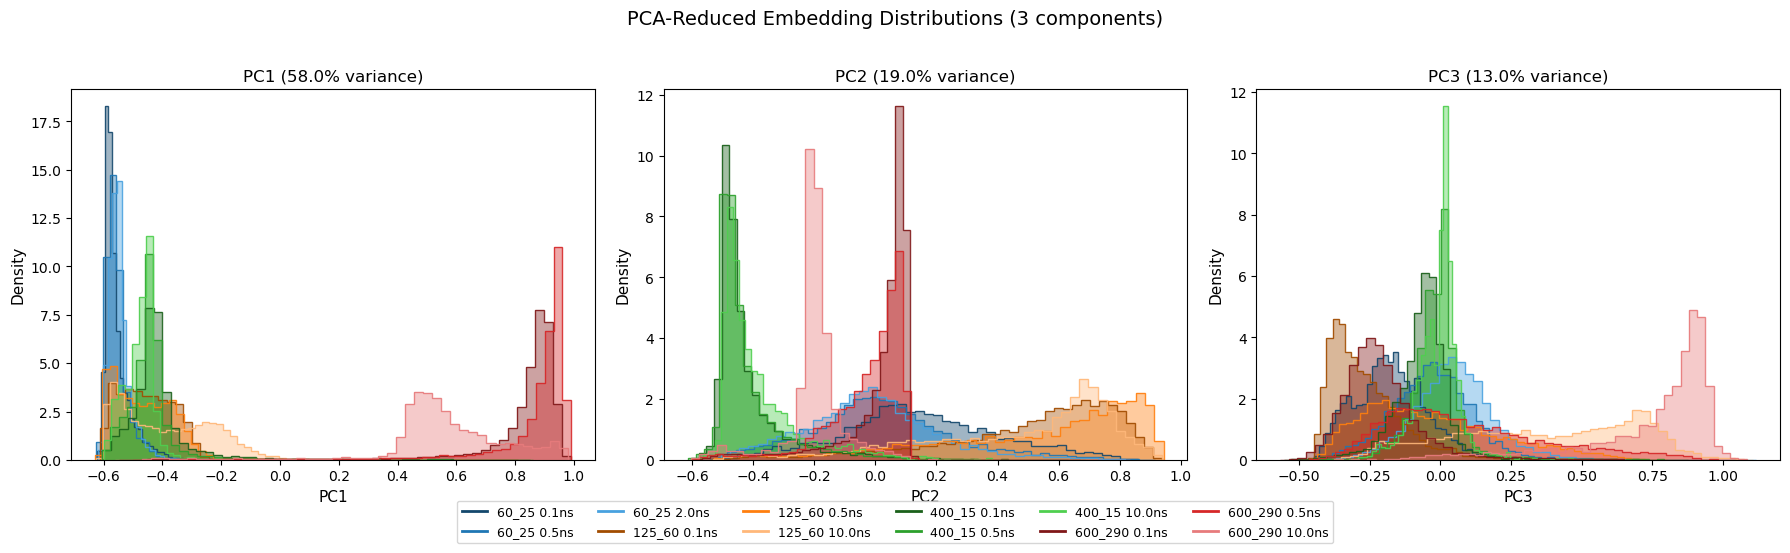

Saved: /pscratch/sd/h/hjia625/analysis_vll_checkpoint/pca_per_dimension.png


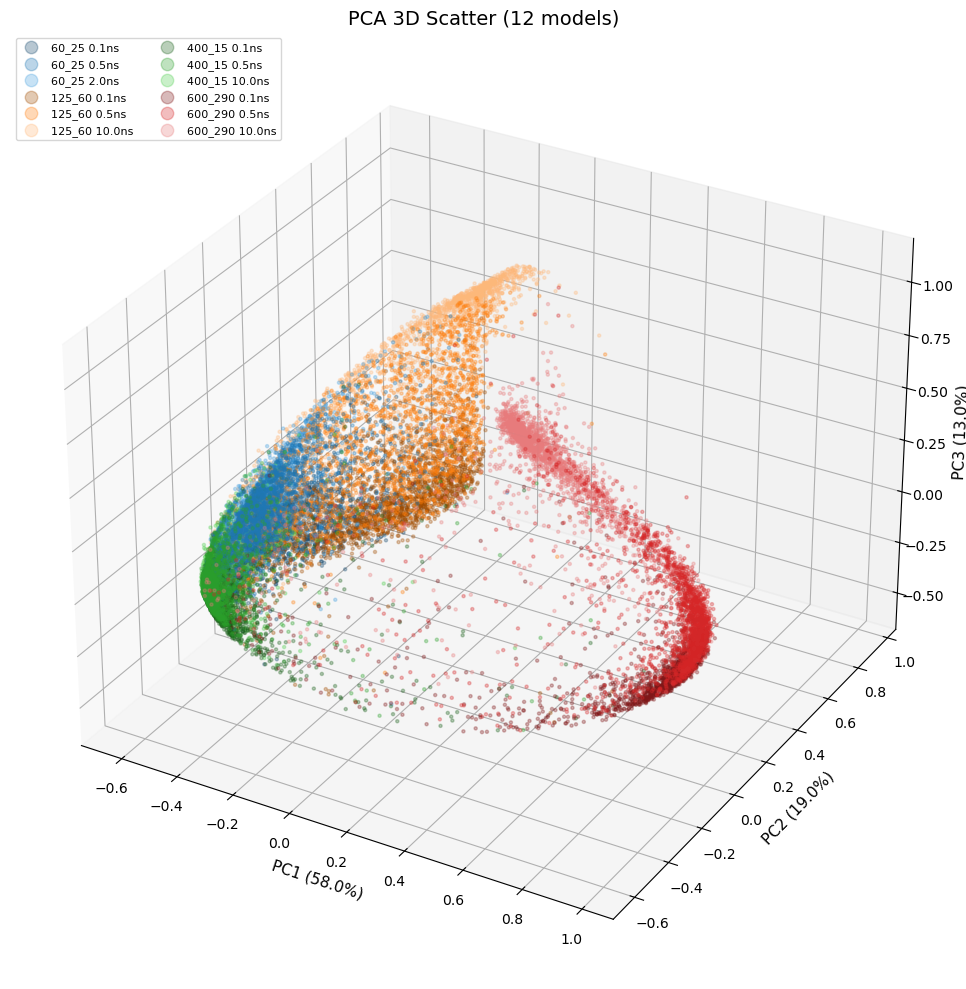

Saved: /pscratch/sd/h/hjia625/analysis_vll_checkpoint/pca_3d_scatter.png


In [17]:
# --- Color scheme: same (a,b) = same hue, lifetime = shade ---
import matplotlib.colors as mcolors
from collections import OrderedDict

# Parse model names into (mass_group, lifetime)
def parse_model_name(name):
    """Parse 'a_b_cns' -> ('a_b', float(c))"""
    parts = name.replace('ns', '').split('_')
    mass_group = f"{parts[0]}_{parts[1]}"
    lifetime = float(parts[2])
    return mass_group, lifetime

# Group models by mass point
mass_groups = OrderedDict()
for name in model_names:
    mg, lt = parse_model_name(name)
    if mg not in mass_groups:
        mass_groups[mg] = []
    mass_groups[mg].append((name, lt))

# Sort lifetimes within each group
for mg in mass_groups:
    mass_groups[mg].sort(key=lambda x: x[1])

# Assign one base color per mass group
base_cmap = plt.cm.tab10
base_colors = {mg: base_cmap(i) for i, mg in enumerate(mass_groups)}

# Shade: shortest lifetime = darkest, longest = lightest
# Scale lightness from 0.3 (dark) to 0.85 (light)
def adjust_lightness(color, factor):
    """factor < 1 = darker, factor > 1 = lighter"""
    import colorsys
    r, g, b, a = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r2, g2, b2 = colorsys.hls_to_rgb(h, l, s)
    return (r2, g2, b2, a)

shade_factors = {1: [1.0], 2: [0.7, 1.3], 3: [0.6, 1.0, 1.4], 4: [0.5, 0.8, 1.1, 1.4]}

model_colors = {}
for mg, members in mass_groups.items():
    n = len(members)
    factors = shade_factors.get(n, np.linspace(0.5, 1.4, n).tolist())
    for (name, _), sf in zip(members, factors):
        model_colors[name] = adjust_lightness(base_colors[mg], sf)

# Build ordered color list matching model_names
colors = [model_colors[name] for name in model_names]

# --- 4a: PCA per-dimension histograms ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for pc_idx in range(3):
    ax = axes[pc_idx]
    for model_idx, name in enumerate(model_names):
        mask = all_labels == model_idx
        vals = pca_embeddings[mask, pc_idx]
        ax.hist(vals, bins=50, alpha=0.4, color=colors[model_idx],
                density=True, histtype='stepfilled', linewidth=0)
        ax.hist(vals, bins=50, alpha=0.9, color=colors[model_idx],
                density=True, histtype='step', linewidth=1.0)
    ev = pca.explained_variance_ratio_[pc_idx]
    ax.set_title(f'PC{pc_idx + 1} ({ev:.1%} variance)', fontsize=12)
    ax.set_xlabel(f'PC{pc_idx + 1}', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)

# Legend grouped by mass point
handles = []
for mg, members in mass_groups.items():
    for name, lt in members:
        c = model_colors[name]
        handles.append(plt.Line2D([0], [0], color=c, linewidth=2, label=f'{mg} {lt}ns'))

fig.legend(handles=handles, loc='lower center', ncol=min(6, len(model_names)),
           fontsize=9, bbox_to_anchor=(0.5, -0.06))

fig.suptitle('PCA-Reduced Embedding Distributions (3 components)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(checkpoint_dir / 'pca_per_dimension.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {checkpoint_dir / 'pca_per_dimension.png'}")

# --- 4b: 3D scatter plot ---
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

max_points_per_model = 2000

for model_idx, name in enumerate(model_names):
    mask = all_labels == model_idx
    pts = pca_embeddings[mask]
    if len(pts) > max_points_per_model:
        idx = np.random.choice(len(pts), max_points_per_model, replace=False)
        pts = pts[idx]
    mg, lt = parse_model_name(name)
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
               c=[colors[model_idx]], s=5, alpha=0.3, label=f'{mg} {lt}ns')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', fontsize=11)
ax.set_title(f'PCA 3D Scatter ({len(model_names)} models)', fontsize=14)
ax.legend(loc='upper left', fontsize=8, markerscale=4, ncol=2)

plt.tight_layout()
plt.savefig(checkpoint_dir / 'pca_3d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {checkpoint_dir / 'pca_3d_scatter.png'}")

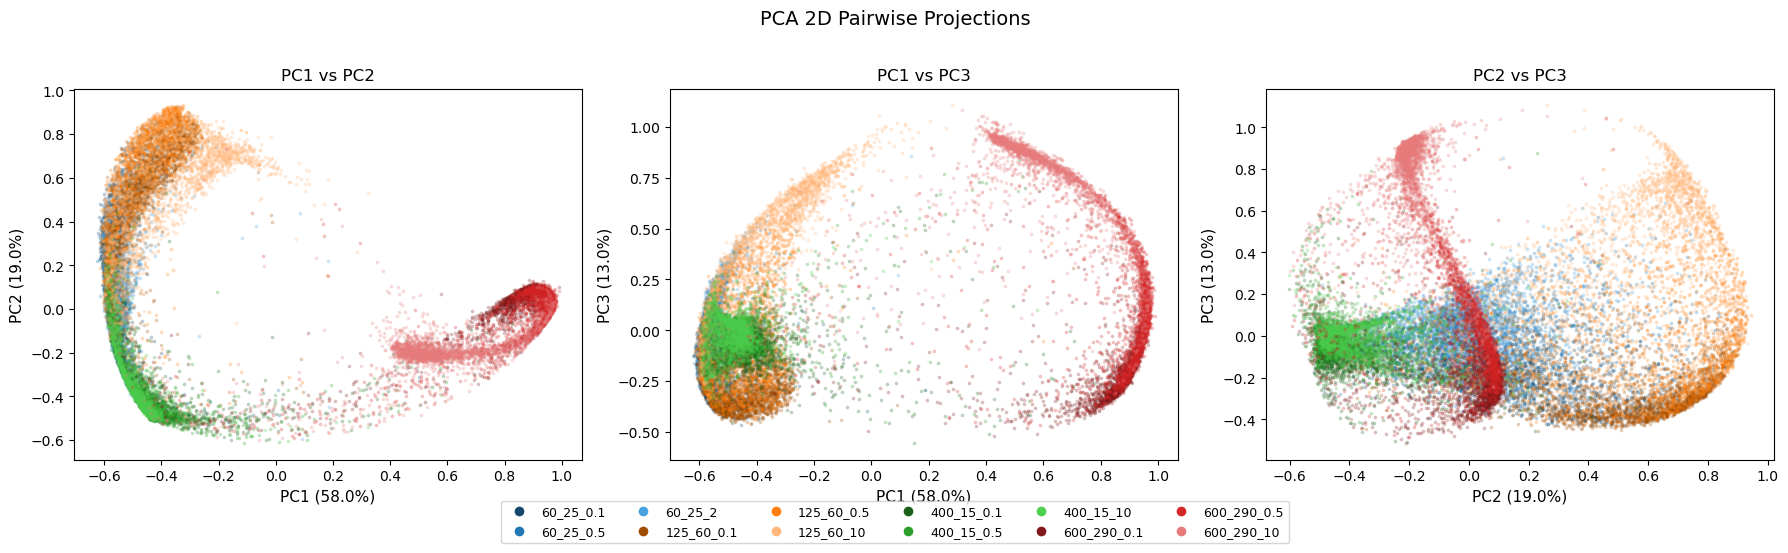

Saved: /pscratch/sd/h/hjia625/analysis_vll_checkpoint/pca_2d_pairs.png

All plots saved to: /pscratch/sd/h/hjia625/analysis_vll_checkpoint


In [18]:
# --- 4c: 2D pairwise projections ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
pairs = [(0, 1), (0, 2), (1, 2)]
pair_labels = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]

for plot_idx, ((i, j), (xl, yl)) in enumerate(zip(pairs, pair_labels)):
    ax = axes[plot_idx]
    for model_idx, name in enumerate(model_names):
        mask = all_labels == model_idx
        pts = pca_embeddings[mask]
        if len(pts) > max_points_per_model:
            idx = np.random.choice(len(pts), max_points_per_model, replace=False)
            pts = pts[idx]
        ax.scatter(pts[:, i], pts[:, j], c=[colors[model_idx]], s=3, alpha=0.2)
    ax.set_xlabel(f'{xl} ({pca.explained_variance_ratio_[i]:.1%})', fontsize=11)
    ax.set_ylabel(f'{yl} ({pca.explained_variance_ratio_[j]:.1%})', fontsize=11)
    ax.set_title(f'{xl} vs {yl}', fontsize=12)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i],
                       markersize=8, label=short_names[i]) for i in range(len(model_names))]
fig.legend(handles=handles, loc='lower center', ncol=min(6, len(model_names)),
           fontsize=9, bbox_to_anchor=(0.5, -0.06))

fig.suptitle('PCA 2D Pairwise Projections', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(checkpoint_dir / 'pca_2d_pairs.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: {checkpoint_dir / 'pca_2d_pairs.png'}")

print("\nAll plots saved to:", checkpoint_dir)

In [61]:
train_electron_features = np.load(data_dir / 'train_data_contra_e_ABCD_iso.npy')
train_photon_features = np.load(data_dir / 'train_data_contra_p_ABCD_iso.npy')
train_dvtrack_features = np.load(data_dir / 'train_data_contra_t_ABCD_iso.npy')
train_vertices = np.load(data_dir / 'train_data_contra_v_ABCD_iso.npy')
train_FirstIso = np.load(data_dir / 'train_data_contra_FirIso_ABCD_iso.npy')
train_SecondIso = np.load(data_dir / 'train_data_contra_SecIso_ABCD_iso.npy')
train_years = np.load(data_dir / 'train_data_contra_year_ABCD_iso.npy')

val_electron_features = np.load(data_dir / 'val_data_contra_e_ABCD_iso.npy')
val_photon_features = np.load(data_dir / 'val_data_contra_p_ABCD_iso.npy')
val_dvtrack_features = np.load(data_dir / 'val_data_contra_t_ABCD_iso.npy')
val_vertices = np.load(data_dir / 'val_data_contra_v_ABCD_iso.npy')
val_FirstIso = np.load(data_dir / 'val_data_contra_FirIso_ABCD_iso.npy')
val_SecondIso = np.load(data_dir / 'val_data_contra_SecIso_ABCD_iso.npy')
val_years = np.load(data_dir / 'val_data_contra_year_ABCD_iso.npy')

test_electron_features = np.load(data_dir / 'test_data_contra_e_ABCD_iso.npy')
test_photon_features = np.load(data_dir / 'test_data_contra_p_ABCD_iso.npy')
test_dvtrack_features = np.load(data_dir / 'test_data_contra_t_ABCD_iso.npy')
test_vertices = np.load(data_dir / 'test_data_contra_v_ABCD_iso.npy')
test_FirstIso = np.load(data_dir / 'test_data_contra_FirIso_ABCD_iso.npy')
test_SecondIso = np.load(data_dir / 'test_data_contra_SecIso_ABCD_iso.npy')
test_years = np.load(data_dir / 'test_data_contra_year_ABCD_iso.npy')

In [62]:
from sklearn.model_selection import train_test_split

# === 1. Combine all splits ===
all_electron = np.concatenate([train_electron_features, val_electron_features, test_electron_features])
all_photon = np.concatenate([train_photon_features, val_photon_features, test_photon_features])
all_dvtrack = np.concatenate([train_dvtrack_features, val_dvtrack_features, test_dvtrack_features])
all_vertices = np.concatenate([train_vertices, val_vertices, test_vertices])
all_FirstIso = np.concatenate([train_FirstIso, val_FirstIso, test_FirstIso])
all_SecondIso = np.concatenate([train_SecondIso, val_SecondIso, test_SecondIso])
all_years = np.concatenate([train_years, val_years, test_years])

print(f"Total combined events: {len(all_electron):,}")

# === 2. Create labels ===
def make_abcd_label(first_iso, second_iso):
    labels = np.empty(len(first_iso), dtype='U1')
    labels[(first_iso == 1) & (second_iso == 1)] = 'A'
    labels[(first_iso == 1) & (second_iso == 0)] = 'B'
    labels[(first_iso == 0) & (second_iso == 1)] = 'C'
    labels[(first_iso == 0) & (second_iso == 0)] = 'D'
    return labels

all_ABCD = make_abcd_label(all_FirstIso, all_SecondIso)
all_zero_electron = (all_electron[:, :, 0] == 0).all(axis=1)
all_zero_photon = (all_photon[:, :, 0] == 0).all(axis=1)

for r in ['B', 'C', 'D']:
    print(f"  Region {r}: {(all_ABCD == r).sum():>12,}")
print(f"  Zero electrons: {all_zero_electron.sum():>12,}")
print(f"  Zero photons:   {all_zero_photon.sum():>12,}")

# === 3. Stratified split: 40% train, 10% val, 50% test per region ===
train_idx_list, val_idx_list, test_idx_list = [], [], []

for region in ['B', 'C', 'D']:
    region_idx = np.where(all_ABCD == region)[0]
    
    # First split: 50% test, 50% trainval
    idx_trainval, idx_test = train_test_split(
        region_idx, test_size=0.50, random_state=42, shuffle=True
    )
    # Second split: from trainval (50%), take 10/50=20% for val -> 40% train, 10% val overall
    idx_train, idx_val = train_test_split(
        idx_trainval, test_size=0.20, random_state=42, shuffle=True
    )
    
    train_idx_list.append(idx_train)
    val_idx_list.append(idx_val)
    test_idx_list.append(idx_test)
    
    print(f"  Region {region}: train={len(idx_train):>10,}  val={len(idx_val):>10,}  test={len(idx_test):>10,}")

train_idx = np.concatenate(train_idx_list)
val_idx = np.concatenate(val_idx_list)
test_idx = np.concatenate(test_idx_list)

# Shuffle within each split
rng = np.random.default_rng(42)
rng.shuffle(train_idx)
rng.shuffle(val_idx)
rng.shuffle(test_idx)

# === 4. Build final arrays ===
train_electron_features = all_electron[train_idx]
train_photon_features   = all_photon[train_idx]
train_dvtrack_features  = all_dvtrack[train_idx]
train_vertices          = all_vertices[train_idx]
train_FirstIso          = all_FirstIso[train_idx]
train_SecondIso         = all_SecondIso[train_idx]
train_years             = all_years[train_idx]
train_ABCD_label        = all_ABCD[train_idx]
train_zero_electron     = all_zero_electron[train_idx]
train_zero_photon       = all_zero_photon[train_idx]

val_electron_features = all_electron[val_idx]
val_photon_features   = all_photon[val_idx]
val_dvtrack_features  = all_dvtrack[val_idx]
val_vertices          = all_vertices[val_idx]
val_FirstIso          = all_FirstIso[val_idx]
val_SecondIso         = all_SecondIso[val_idx]
val_years             = all_years[val_idx]
val_ABCD_label        = all_ABCD[val_idx]
val_zero_electron     = all_zero_electron[val_idx]
val_zero_photon       = all_zero_photon[val_idx]

test_electron_features = all_electron[test_idx]
test_photon_features   = all_photon[test_idx]
test_dvtrack_features  = all_dvtrack[test_idx]
test_vertices          = all_vertices[test_idx]
test_FirstIso          = all_FirstIso[test_idx]
test_SecondIso         = all_SecondIso[test_idx]
test_years             = all_years[test_idx]
test_ABCD_label        = all_ABCD[test_idx]
test_zero_electron     = all_zero_electron[test_idx]
test_zero_photon       = all_zero_photon[test_idx]

# === 5. Verify ===
print(f"\n{'Split':<8} {'Total':>12} {'A':>10} {'B':>10} {'C':>10} {'D':>10} {'0e':>10} {'0p':>10}")
print("-" * 82)
for name, abcd, ze, zp in [
    ("Train", train_ABCD_label, train_zero_electron, train_zero_photon),
    ("Val",   val_ABCD_label,   val_zero_electron,   val_zero_photon),
    ("Test",  test_ABCD_label,  test_zero_electron,  test_zero_photon),
]:
    counts = {r: (abcd == r).sum() for r in 'ABCD'}
    print(f"{name:<8} {len(abcd):>12,} {counts['A']:>10,} {counts['B']:>10,} {counts['C']:>10,} {counts['D']:>10,} {ze.sum():>10,} {zp.sum():>10,}")

# === 6. Save splits ===
import os

os.makedirs(data_dir, exist_ok=True)

for split, idx in [("train", train_idx), ("val", val_idx), ("test", test_idx)]:
    np.save(os.path.join(data_dir, f"{split}_electron_features.npy"), all_electron[idx])
    np.save(os.path.join(data_dir, f"{split}_photon_features.npy"), all_photon[idx])
    np.save(os.path.join(data_dir, f"{split}_dvtrack_features.npy"), all_dvtrack[idx])
    np.save(os.path.join(data_dir, f"{split}_vertices.npy"), all_vertices[idx])
    np.save(os.path.join(data_dir, f"{split}_FirstIso.npy"), all_FirstIso[idx])
    np.save(os.path.join(data_dir, f"{split}_SecondIso.npy"), all_SecondIso[idx])
    np.save(os.path.join(data_dir, f"{split}_years.npy"), all_years[idx])
    np.save(os.path.join(data_dir, f"{split}_ABCD_label.npy"), all_ABCD[idx])
    np.save(os.path.join(data_dir, f"{split}_zero_electron.npy"), all_zero_electron[idx])
    np.save(os.path.join(data_dir, f"{split}_zero_photon.npy"), all_zero_photon[idx])

print(f"Saved all splits to {data_dir}")
# Free combined arrays
del all_electron, all_photon, all_dvtrack, all_vertices
del all_FirstIso, all_SecondIso, all_years, all_ABCD, all_zero_electron, all_zero_photon

Total combined events: 22,148,828
  Region B:   11,740,069
  Region C:    6,924,986
  Region D:    3,483,773
  Zero electrons:    3,259,651
  Zero photons:     11,445,168
  Region B: train= 4,696,027  val= 1,174,007  test= 5,870,035
  Region C: train= 2,769,994  val=   692,499  test= 3,462,493
  Region D: train= 1,393,508  val=   348,378  test= 1,741,887

Split           Total          A          B          C          D         0e         0p
----------------------------------------------------------------------------------
Train       8,859,529          0  4,696,027  2,769,994  1,393,508  1,305,923  4,577,345
Val         2,214,884          0  1,174,007    692,499    348,378    325,924  1,144,601
Test       11,074,415          0  5,870,035  3,462,493  1,741,887  1,627,804  5,723,222
Saved all splits to /pscratch/sd/h/hjia625/analysis_vll_data_dir


In [15]:
# === Load splits ===
arrays = {}
for split in ["train", "val", "test"]:
    for name in ["electron_features", "photon_features", "dvtrack_features",
                  "vertices", "FirstIso", "SecondIso", "years",
                  "ABCD_label", "zero_electron", "zero_photon"]:
        arrays[f"{split}_{name}"] = np.load(os.path.join(data_dir, f"{split}_{name}.npy"))

# Unpack into individual variables
train_electron_features = arrays["train_electron_features"]
train_photon_features   = arrays["train_photon_features"]
train_dvtrack_features  = arrays["train_dvtrack_features"]
train_vertices          = arrays["train_vertices"]
train_FirstIso          = arrays["train_FirstIso"]
train_SecondIso         = arrays["train_SecondIso"]
train_years             = arrays["train_years"]
train_ABCD_label        = arrays["train_ABCD_label"]
train_zero_electron     = arrays["train_zero_electron"]
train_zero_photon       = arrays["train_zero_photon"]

val_electron_features = arrays["val_electron_features"]
val_photon_features   = arrays["val_photon_features"]
val_dvtrack_features  = arrays["val_dvtrack_features"]
val_vertices          = arrays["val_vertices"]
val_FirstIso          = arrays["val_FirstIso"]
val_SecondIso         = arrays["val_SecondIso"]
val_years             = arrays["val_years"]
val_ABCD_label        = arrays["val_ABCD_label"]
val_zero_electron     = arrays["val_zero_electron"]
val_zero_photon       = arrays["val_zero_photon"]

test_electron_features = arrays["test_electron_features"]
test_photon_features   = arrays["test_photon_features"]
test_dvtrack_features  = arrays["test_dvtrack_features"]
test_vertices          = arrays["test_vertices"]
test_FirstIso          = arrays["test_FirstIso"]
test_SecondIso         = arrays["test_SecondIso"]
test_years             = arrays["test_years"]
test_ABCD_label        = arrays["test_ABCD_label"]
test_zero_electron     = arrays["test_zero_electron"]
test_zero_photon       = arrays["test_zero_photon"]

del arrays
print(f"Loaded all splits from {data_dir}")

Loaded all splits from /pscratch/sd/h/hjia625/analysis_vll_data_dir


In [16]:
class EmbeddingScaler:
    """Wraps a StandardScaler fitted on [e_flat | p_flat | t_flat] concatenation."""
    
    def __init__(self, scaler, e_feat_dim=14, p_feat_dim=12, t_feat_dim=9, max_objs=4):
        self.scaler = scaler
        self.e_len = max_objs * e_feat_dim
        self.p_len = max_objs * p_feat_dim
        self.t_len = max_objs * t_feat_dim
    
    def transform_arrays(self, electrons, photons, dvtracks):
        """Scale 3D arrays: (N, obj, feat) → flatten → scale → reshape back."""
        n = electrons.shape[0]
        e_shape, p_shape, t_shape = electrons.shape, photons.shape, dvtracks.shape
        
        e_flat = electrons.reshape(n, -1)
        p_flat = photons.reshape(n, -1)
        t_flat = dvtracks.reshape(n, -1)
        
        raw_vec = np.concatenate([e_flat, p_flat, t_flat], axis=1)
        raw_vec = np.nan_to_num(raw_vec, nan=0.0, posinf=0.0, neginf=0.0)
        scaled_vec = self.scaler.transform(raw_vec)
        
        end_e = self.e_len
        end_p = end_e + self.p_len
        
        e_scaled = scaled_vec[:, :end_e].reshape(e_shape).astype(np.float32)
        p_scaled = scaled_vec[:, end_e:end_p].reshape(p_shape).astype(np.float32)
        t_scaled = scaled_vec[:, end_p:].reshape(t_shape).astype(np.float32)
        
        return e_scaled, p_scaled, t_scaled

# Load and wrap
scaler = joblib.load(data_dir / 'signal_scaler_fitted.pkl')
embed_scaler = EmbeddingScaler(scaler)

/global/common/software/nersc9/tensorflow/2.15.0/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
@tf.function(jit_compile=True)
def predict_step(model, inputs):
    return model(inputs, training=False)["latent_base"]


def get_latent_representations_accelerated(model, electron_features, photon_features,
                                           dvtrack_features, embed_scaler, batch_size=65536):
    """
    GPU-optimized latent representation extraction.
    
    Optimizations:
    1. Scale entire dataset once upfront (avoids repeated per-batch scaling).
    2. Large batch size to saturate GPU.
    3. jit_compile=True on predict_step for XLA fusion.
    4. tf.data pipeline with prefetching to overlap CPU->GPU transfer with compute.
    5. Pre-allocated numpy output to avoid list concatenation.
    """
    n_samples = electron_features.shape[0]

    # --- 1. Scale everything once ---
    print("Scaling full dataset...")
    e_scaled, p_scaled, d_scaled = embed_scaler.transform_arrays(
        electron_features, photon_features, dvtrack_features
    )

    # Cast to float32 once
    e_scaled = e_scaled.astype(np.float32)
    p_scaled = p_scaled.astype(np.float32)
    d_scaled = d_scaled.astype(np.float32)

    # --- 2. Determine latent dim ---
    dummy_input = {
        "electron_input": tf.zeros((1, *e_scaled.shape[1:])),
        "photon_input": tf.zeros((1, *p_scaled.shape[1:])),
        "dvtrack_input": tf.zeros((1, *d_scaled.shape[1:]))
    }
    latent_dim = model(dummy_input, training=False)["latent_base"].shape[-1]
    all_latent_reps = np.zeros((n_samples, latent_dim), dtype=np.float32)

    # --- 3. Build tf.data pipeline with prefetch ---
    dataset = tf.data.Dataset.from_tensor_slices((e_scaled, p_scaled, d_scaled))
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # --- 4. Run inference ---
    print(f"Running inference: {n_samples} samples, batch_size={batch_size}")
    idx = 0
    for e_batch, p_batch, d_batch in dataset:
        inputs = {
            "electron_input": e_batch,
            "photon_input": p_batch,
            "dvtrack_input": d_batch,
        }
        batch_latent = predict_step(model, inputs)
        n = batch_latent.shape[0]
        all_latent_reps[idx:idx + n] = batch_latent.numpy()
        idx += n

    return all_latent_reps

In [18]:
# Transform training data
print("Transforming training data...")
train_latent = get_latent_representations_accelerated(model, train_electron_features, train_photon_features, train_dvtrack_features, embed_scaler,
    batch_size=65536)
print(f"Training latent shape: {train_latent.shape}")

# Transform validation data
print("\nTransforming validation data...")
val_latent = get_latent_representations_accelerated(model, val_electron_features, val_photon_features, val_dvtrack_features, embed_scaler,
    batch_size=65536)
print(f"Validation latent shape: {val_latent.shape}")

# Transform test data
print("\nTransforming test data...")
test_latent = get_latent_representations_accelerated(model, test_electron_features, test_photon_features, test_dvtrack_features, embed_scaler,
    batch_size=65536)
print(f"Test latent shape: {test_latent.shape}")

Transforming training data...
Scaling full dataset...
Running inference: 8859529 samples, batch_size=65536


I0000 00:00:1771372611.429275 1237232 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Training latent shape: (8859529, 32)

Transforming validation data...
Scaling full dataset...
Running inference: 2214884 samples, batch_size=65536
Validation latent shape: (2214884, 32)

Transforming test data...
Scaling full dataset...
Running inference: 11074415 samples, batch_size=65536
Test latent shape: (11074415, 32)


In [19]:
def create_autoencoder_with_bn(input_dim=32, name_suffix=''):
    reg = keras.regularizers.l2(1e-4)

    # Encoder
    encoder_input = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, kernel_regularizer=reg)(encoder_input)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Dense(64, kernel_regularizer=reg)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Dense(32, kernel_regularizer=reg)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    # Bottleneck (linear to preserve geometry)
    encoded = layers.Dense(16, activation='linear', name=f'bottleneck{name_suffix}')(x)

    # Decoder
    y = layers.Dense(32, kernel_regularizer=reg)(encoded)
    y = layers.LayerNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Dense(64, kernel_regularizer=reg)(y)
    y = layers.LayerNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Dense(128, kernel_regularizer=reg)(y)
    y = layers.LayerNormalization()(y)
    y = layers.Activation('relu')(y)

    # Linear output to match (whitened) input distribution
    decoded = layers.Dense(input_dim, activation='linear')(y)

    autoencoder = keras.Model(encoder_input, decoded, name=f'autoencoder{name_suffix}')
    encoder = keras.Model(encoder_input, encoded, name=f'encoder{name_suffix}')
    return autoencoder, encoder

In [20]:
class DualAutoencoderModel(keras.Model):
    def __init__(self, input_dim=32, decorr_weight=1.0):
        super().__init__()
        self.decorr_weight = decorr_weight
        
        self.autoencoder_1, self.encoder_1 = create_autoencoder_with_bn(input_dim, name_suffix='_1')
        self.autoencoder_2, self.encoder_2 = create_autoencoder_with_bn(input_dim, name_suffix='_2')
        
        self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
        self.decorr_loss_tracker = keras.metrics.Mean(name="decorr_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    
    def call(self, inputs):
        recon_1 = self.autoencoder_1(inputs)
        recon_2 = self.autoencoder_2(inputs)
        return recon_1, recon_2
    
    @staticmethod
    def compute_mse_per_sample(x, x_recon):
        return tf.reduce_mean(tf.square(x - x_recon), axis=1)
    
    @staticmethod
    def compute_distance_correlation(r1, r2):
        r1 = tf.reshape(r1, [-1, 1])
        r2 = tf.reshape(r2, [-1, 1])
        n = tf.cast(tf.shape(r1)[0], tf.float32)
        
        r1_dist = tf.abs(r1 - tf.transpose(r1))
        r2_dist = tf.abs(r2 - tf.transpose(r2))
        
        r1_mean_row = tf.reduce_mean(r1_dist, axis=1, keepdims=True)
        r1_mean_col = tf.reduce_mean(r1_dist, axis=0, keepdims=True)
        r1_mean_all = tf.reduce_mean(r1_dist)
        A = r1_dist - r1_mean_row - r1_mean_col + r1_mean_all
        
        r2_mean_row = tf.reduce_mean(r2_dist, axis=1, keepdims=True)
        r2_mean_col = tf.reduce_mean(r2_dist, axis=0, keepdims=True)
        r2_mean_all = tf.reduce_mean(r2_dist)
        B = r2_dist - r2_mean_row - r2_mean_col + r2_mean_all
        
        dcov_xy = tf.sqrt(tf.reduce_sum(A * B) / (n * n))
        dcov_xx = tf.sqrt(tf.reduce_sum(A * A) / (n * n))
        dcov_yy = tf.sqrt(tf.reduce_sum(B * B) / (n * n))
        
        dcor = dcov_xy / (tf.sqrt(dcov_xx * dcov_yy) + 1e-10)
        return dcor
    
    def _compute_losses(self, x, recon_1, recon_2):
        mse_1 = self.compute_mse_per_sample(x, recon_1)
        mse_2 = self.compute_mse_per_sample(x, recon_2)
        recon_loss = tf.reduce_mean(mse_1) + tf.reduce_mean(mse_2)
        
        decorr_loss = self.compute_distance_correlation(
            tf.math.log(mse_1 + 1e-6),
            tf.math.log(mse_2 + 1e-6)
        )
        
        total_loss = recon_loss + self.decorr_weight * tf.square(decorr_loss)
        
        return total_loss, recon_loss, decorr_loss

    def train_step(self, data):
        x, _ = data
        with tf.GradientTape() as tape:
            recon_1 = self.autoencoder_1(x, training=True)
            recon_2 = self.autoencoder_2(x, training=True)
            
            total_loss, recon, decorr = self._compute_losses(x, recon_1, recon_2)
            total_loss += sum(self.autoencoder_1.losses) + sum(self.autoencoder_2.losses)
        
        trainable_vars = self.autoencoder_1.trainable_variables + self.autoencoder_2.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        self.recon_loss_tracker.update_state(recon)
        self.decorr_loss_tracker.update_state(decorr)
        self.total_loss_tracker.update_state(total_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        x, _ = data
        recon_1 = self.autoencoder_1(x, training=False)
        recon_2 = self.autoencoder_2(x, training=False)
        
        total_loss, recon, decorr = self._compute_losses(x, recon_1, recon_2)
        
        self.recon_loss_tracker.update_state(recon)
        self.decorr_loss_tracker.update_state(decorr)
        self.total_loss_tracker.update_state(total_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.recon_loss_tracker,
                self.decorr_loss_tracker]

In [21]:
scaler = StandardScaler(with_mean=True, with_std=True).fit(train_latent)

# 2) Transform all splits
train_s  = scaler.transform(train_latent)
val_s    = scaler.transform(val_latent)      # if you have it
test_s   = scaler.transform(test_latent)

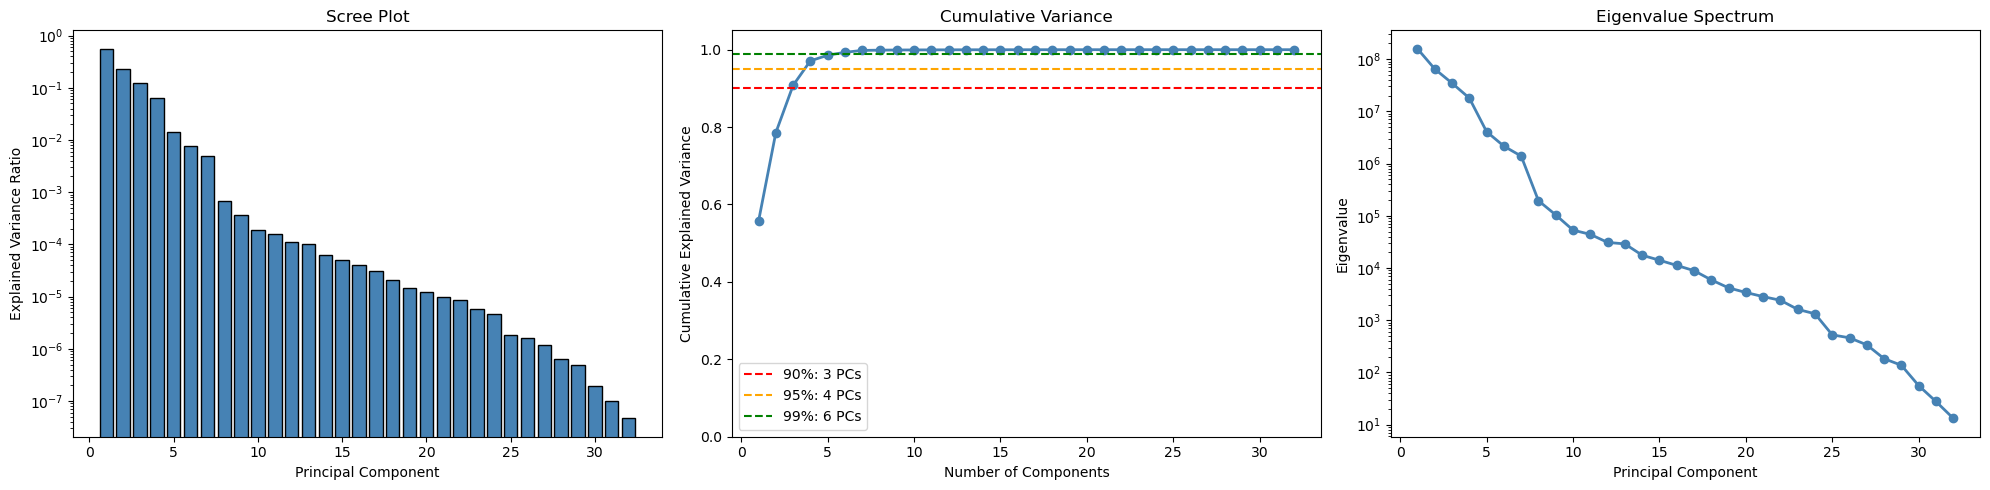

Total features:          32
PCs for 90% variance:    3
PCs for 95% variance:    4
PCs for 99% variance:    6


In [26]:
from sklearn.decomposition import PCA

# Fit PCA on full dimensionality
pca = PCA().fit(train_s)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Scree plot
axes[0].bar(range(1, len(explained)+1), explained, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
axes[0].set_yscale('log')

# 2. Cumulative explained variance
axes[1].plot(range(1, len(cumulative)+1), cumulative, 'o-', color='steelblue', lw=2)
axes[1].axhline(0.90, color='red', ls='--', label=f'90%: {np.searchsorted(cumulative, 0.90)+1} PCs')
axes[1].axhline(0.95, color='orange', ls='--', label=f'95%: {np.searchsorted(cumulative, 0.95)+1} PCs')
axes[1].axhline(0.99, color='green', ls='--', label=f'99%: {np.searchsorted(cumulative, 0.99)+1} PCs')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Variance')
axes[1].legend()
axes[1].set_ylim(0, 1.05)

# 3. Eigenvalue spectrum (log scale)
axes[2].plot(range(1, len(pca.singular_values_)+1), pca.singular_values_**2, 'o-', color='steelblue', lw=2)
axes[2].set_xlabel('Principal Component')
axes[2].set_ylabel('Eigenvalue')
axes[2].set_title('Eigenvalue Spectrum')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

# Summary
print(f"Total features:          {train_s.shape[1]}")
print(f"PCs for 90% variance:    {np.searchsorted(cumulative, 0.90)+1}")
print(f"PCs for 95% variance:    {np.searchsorted(cumulative, 0.95)+1}")
print(f"PCs for 99% variance:    {np.searchsorted(cumulative, 0.99)+1}")

In [22]:
# Save the scaler
joblib.dump(scaler, 'latent_scaler.joblib')

# Save transformed arrays
np.save('train_latent_scaled.npy', train_s)
np.save('val_latent_scaled.npy', val_s)
np.save('test_latent_scaled.npy', test_s)

# (Optional) Save unscaled too if you want them
np.save('train_latent.npy', train_latent)
np.save('val_latent.npy', val_latent)
np.save('test_latent.npy', test_latent)

print("Saved scaler and transformed arrays.")

Saved scaler and transformed arrays.


In [42]:
tf.keras.backend.clear_session()
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

with strategy.scope():
    DualAEmodel = DualAutoencoderModel(input_dim=32, decorr_weight=10000)
    DualAEmodel.compile(optimizer=keras.optimizers.Adam(1e-3, clipnorm=1.0))

    dummy_input = np.zeros((2, 32), dtype=np.float32)
    _ = DualAEmodel(dummy_input, training=False)

DualAEmodel.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_total_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_total_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

Number of devices: 4
Model: "dual_autoencoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_1 (Functional)  (None, 32)                31088     
                                                                 
 encoder_1 (Functional)      (None, 16)                15536     
                                                                 
 autoencoder_2 (Functional)  (None, 32)                31088     
                                                                 
 encoder_2 (Functional)      (None, 16)                15536     
                                                                 
Total params: 62182 (242.90 KB)
Trainable params: 62176 (242.88 KB)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_s, train_s)).batch(100000, drop_remainder=True)
val_ds = tf.data.Dataset.from_tensor_slices((val_s, val_s)).batch(100000, drop_remainder=True)
history = DualAEmodel.fit(
    train_ds, 
    epochs=1000,
    validation_data=val_ds,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/1000
88/88 [==============================] - 41s 245ms/step - total_loss: 145.8546 - recon_loss: 5.4620 - decorr_loss: 0.0718 - val_total_loss: 22.2642 - val_recon_loss: 6.1275 - val_decorr_loss: 0.0398 - lr: 0.0010
Epoch 2/1000
83/88 [===========================>..] - ETA: 0s - total_loss: 13.9175 - recon_loss: 5.9220 - decorr_loss: 0.0269 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(36, 10))

metrics = ['total_loss', 'recon_loss', 'decorr_loss']
titles = ['Total Loss', 'Reconstruction Loss', 'Decorrelation Loss']

for ax, metric, title in zip(axes.flat, metrics, titles):
    ax.plot(history.history[metric], label='Train')
    ax.plot(history.history[f'val_{metric}'], label='Validation')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_history.png', dpi=300)
plt.show()

In [ ]:
DualAEmodel.autoencoder_1.save('autoencoder_1.keras')
DualAEmodel.autoencoder_2.save('autoencoder_2.keras')
DualAEmodel.encoder_1.save('encoder_1.keras')
DualAEmodel.encoder_2.save('encoder_2.keras')

In [22]:
tf.keras.backend.clear_session()
DualAEmodel = DualAutoencoderModel(input_dim=32, decorr_weight=1000)
DualAEmodel.compile(optimizer=keras.optimizers.Adam(1e-3, clipnorm=1.0))

# Build the model
dummy_input = np.zeros((2, 32), dtype=np.float32)
_ = DualAEmodel(dummy_input, training=False)

# Load saved weights into sub-models
saved_ae1 = keras.models.load_model('autoencoder_best_1.keras')
saved_ae2 = keras.models.load_model('autoencoder_best_2.keras')
saved_enc1 = keras.models.load_model('encoder_best_1.keras')
saved_enc2 = keras.models.load_model('encoder_best_2.keras')

DualAEmodel.autoencoder_1.set_weights(saved_ae1.get_weights())
DualAEmodel.autoencoder_2.set_weights(saved_ae2.get_weights())
DualAEmodel.encoder_1.set_weights(saved_enc1.get_weights())
DualAEmodel.encoder_2.set_weights(saved_enc2.get_weights())

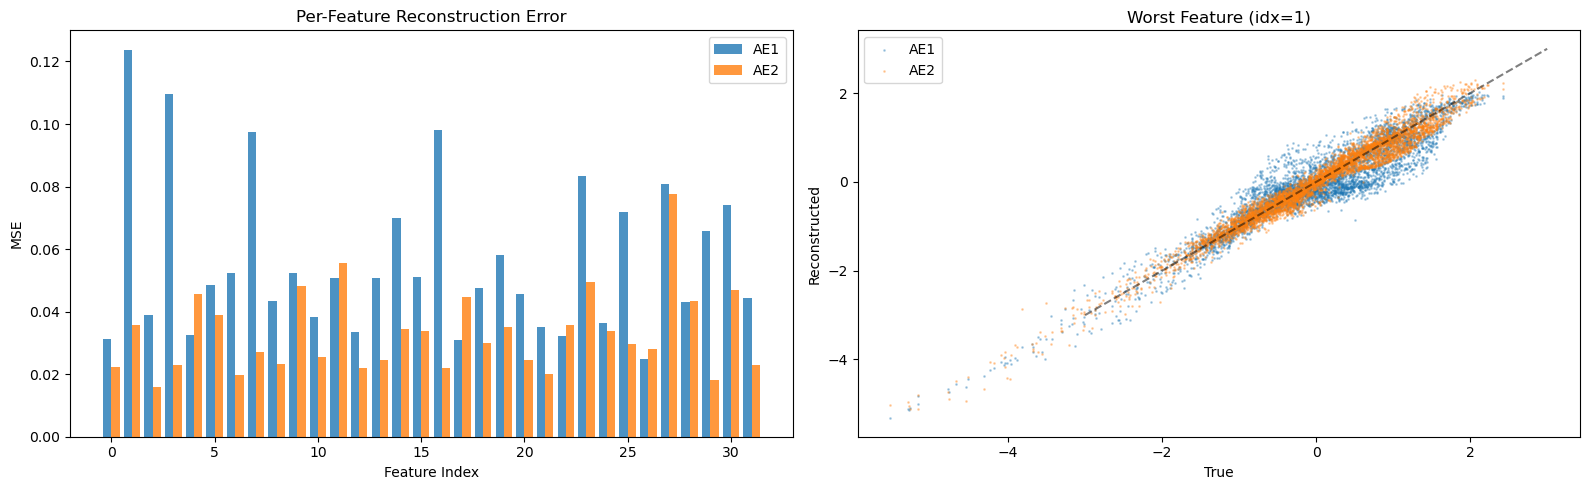

In [23]:
# =============================================
# 2. RECONSTRUCTION QUALITY
# =============================================
def predict_batched(model, data, batch_size=8192):
    ds = tf.data.Dataset.from_tensor_slices(data).batch(batch_size)
    return np.concatenate([model(batch, training=False).numpy() for batch in ds], axis=0)

recon_1 = predict_batched(DualAEmodel.autoencoder_1, test_s)
recon_2 = predict_batched(DualAEmodel.autoencoder_2, test_s)

residual_1 = test_s - recon_1
residual_2 = test_s - recon_2

# Per-feature MSE
mse_per_feat_1 = np.mean(residual_1**2, axis=0)
mse_per_feat_2 = np.mean(residual_2**2, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
x = np.arange(val_s.shape[1])
axes[0].bar(x - 0.2, mse_per_feat_1, 0.4, label='AE1', alpha=0.8)
axes[0].bar(x + 0.2, mse_per_feat_2, 0.4, label='AE2', alpha=0.8)
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('MSE')
axes[0].set_title('Per-Feature Reconstruction Error')
axes[0].legend()

# Reconstruction scatter for worst feature
worst_feat = np.argmax(mse_per_feat_1)
axes[1].scatter(test_s[:5000, worst_feat], recon_1[:5000, worst_feat], s=1, alpha=0.3, label='AE1')
axes[1].scatter(test_s[:5000, worst_feat], recon_2[:5000, worst_feat], s=1, alpha=0.3, label='AE2')
axes[1].plot([-3, 3], [-3, 3], 'k--', alpha=0.5)
axes[1].set_xlabel('True')
axes[1].set_ylabel('Reconstructed')
axes[1].set_title(f'Worst Feature (idx={worst_feat})')
axes[1].legend()

plt.tight_layout()
plt.show()


=== Running Closure Test on 30x30 Grid ===
S1 Range: [0.0022, 0.2981]
S2 Range: [0.0012, 0.2670]

CLOSURE RESULTS (Bins 1-29)
Total Observed:   7977629
Total Predicted:  7977284.84
Global Ratio:     1.0000
Max Pull:         21.14 sigma
Min Pull:         -21.49 sigma
Pull Mean:        0.221
Pull Std:         4.398


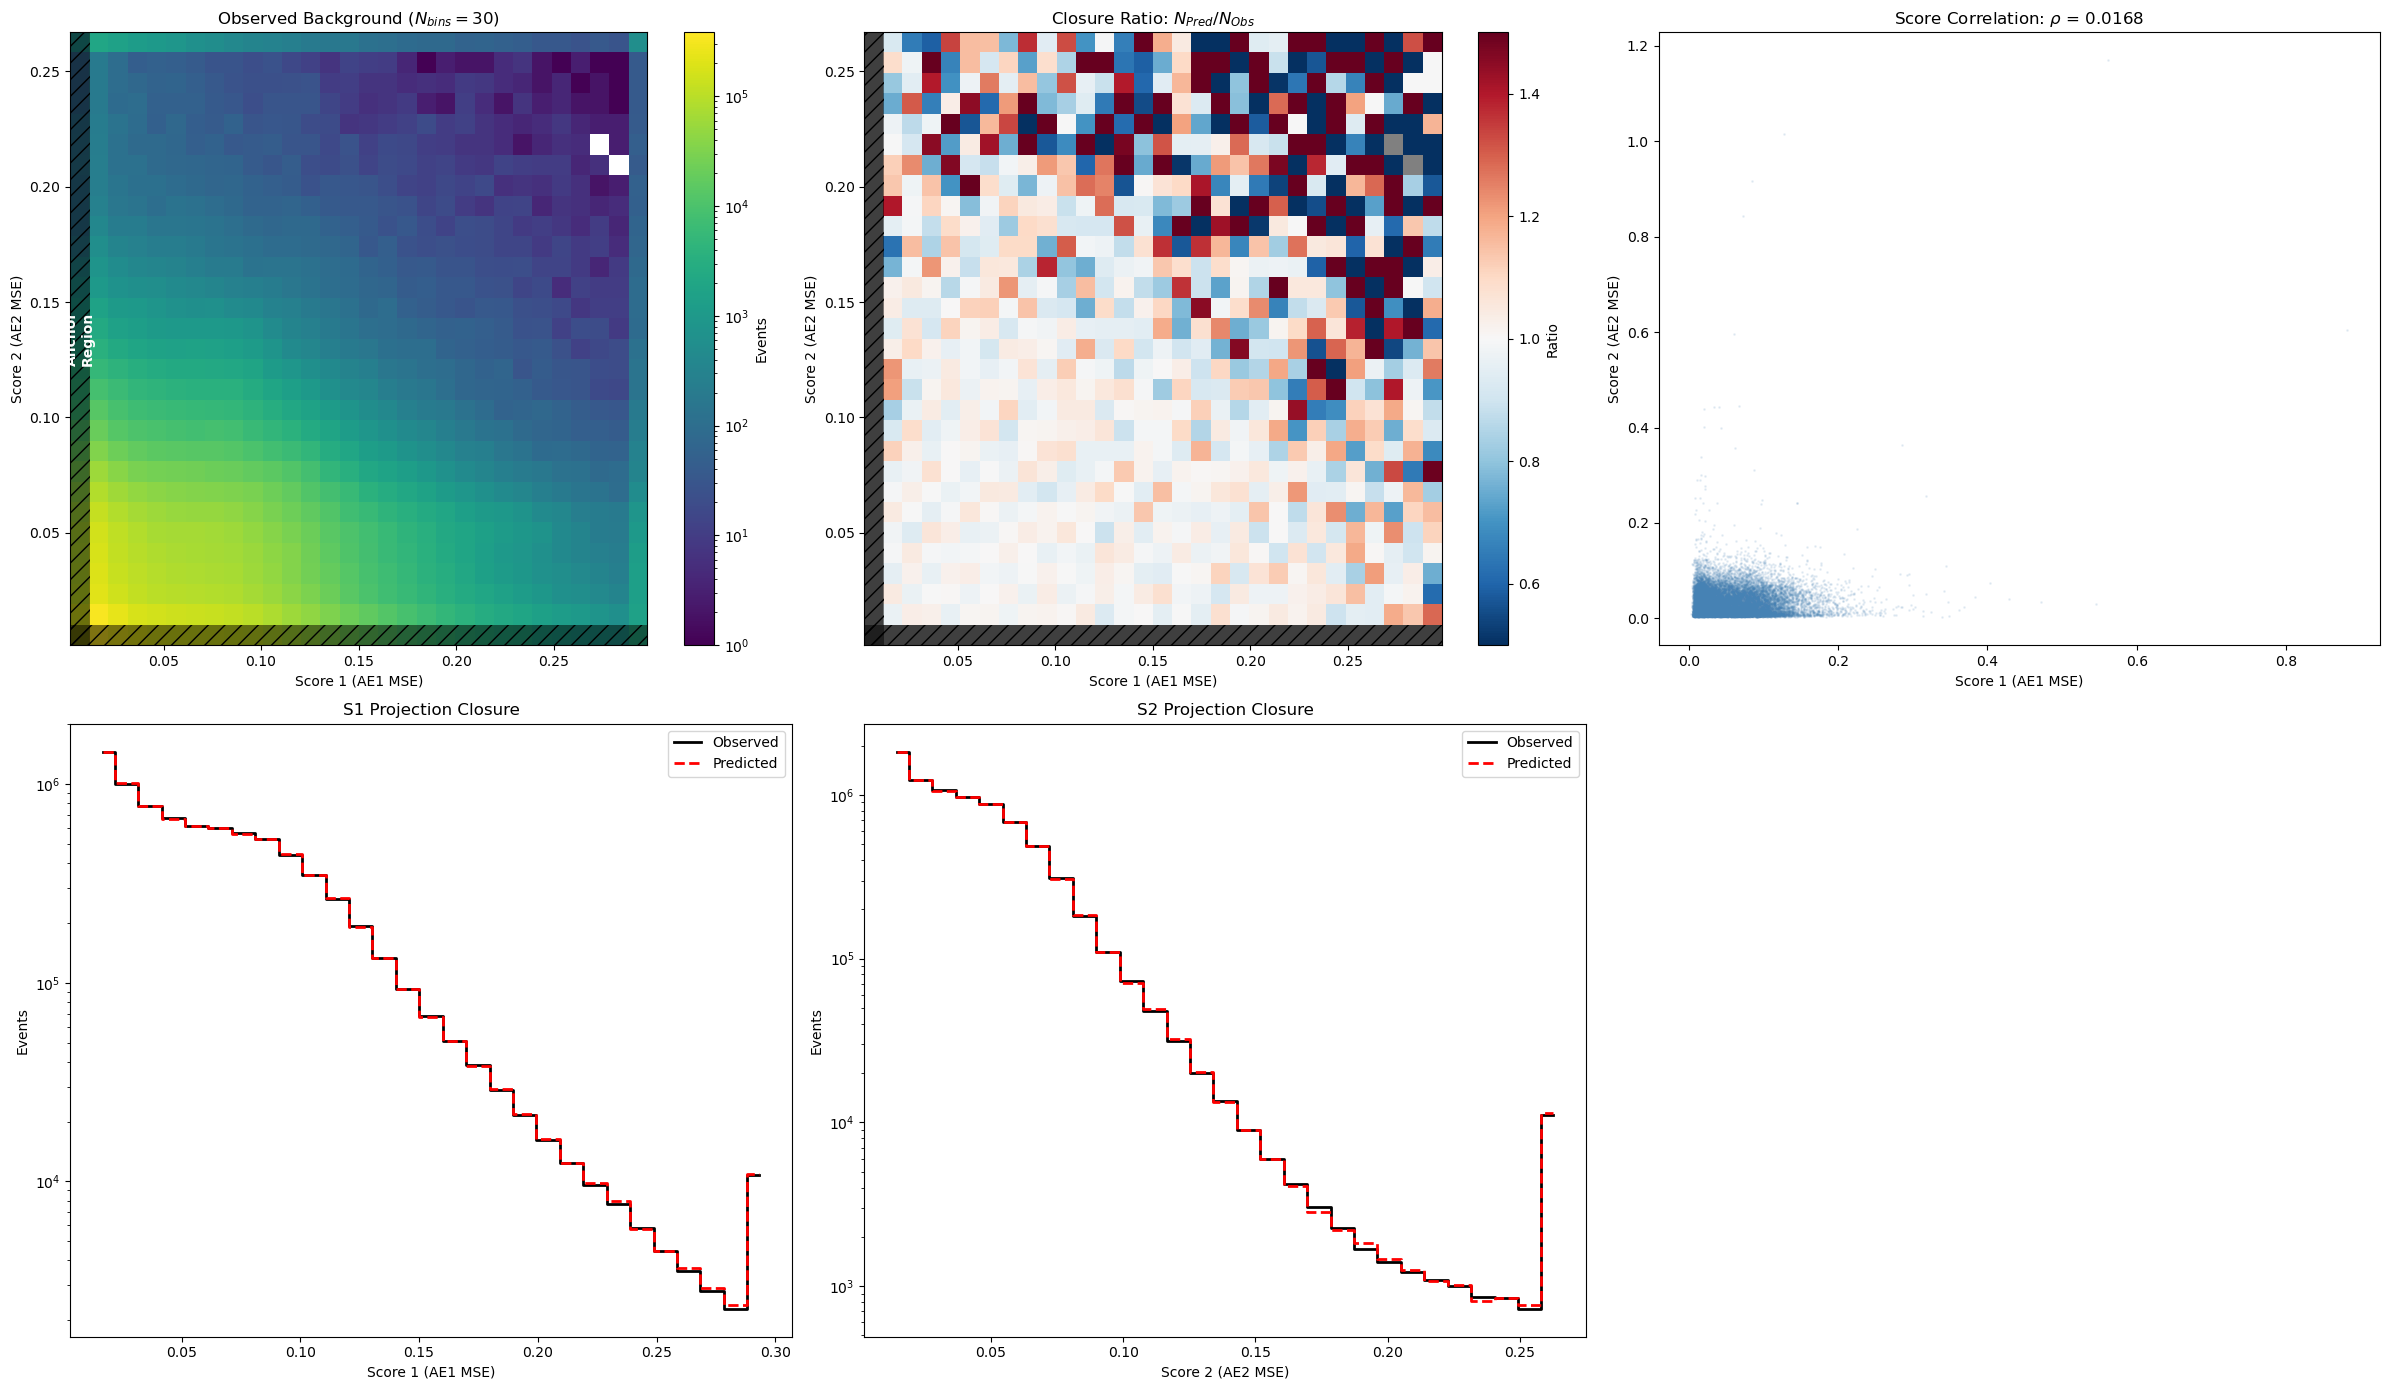

In [24]:
# =============================================
# 0. COMPUTE SCORES
# =============================================
test_s_1 = np.mean((test_s - recon_1)**2, axis=1)
test_s_2 = np.mean((test_s - recon_2)**2, axis=1)

# =============================================
# 1. CONFIGURATION & GRID
# =============================================
n_bins = 30
global_min_s1 = test_s_1.min()
global_max_s1 = np.percentile(test_s_1, 99.9)
global_min_s2 = test_s_2.min()
global_max_s2 = np.percentile(test_s_2, 99.9)

raw_edges_1 = np.linspace(global_min_s1, global_max_s1, n_bins + 1)
raw_edges_2 = np.linspace(global_min_s2, global_max_s2, n_bins + 1)

edges_1 = raw_edges_1.copy()
edges_2 = raw_edges_2.copy()
edges_1[0], edges_1[-1] = -np.inf, np.inf
edges_2[0], edges_2[-1] = -np.inf, np.inf

print(f"\n=== Running Closure Test on {n_bins}x{n_bins} Grid ===")
print(f"S1 Range: [{global_min_s1:.4f}, {global_max_s1:.4f}]")
print(f"S2 Range: [{global_min_s2:.4f}, {global_max_s2:.4f}]")

# =============================================
# 2. OBSERVED VS PREDICTED (Local ABCD)
# =============================================
H_obs, _, _ = np.histogram2d(test_s_1, test_s_2, bins=[edges_1, edges_2])

H_pred = np.full_like(H_obs, np.nan)

for i in range(1, n_bins):
    for j in range(1, n_bins):
        n_B = H_obs[i-1, j]
        n_C = H_obs[i, j-1]
        n_D = H_obs[i-1, j-1]
        
        if n_D > 0:
            H_pred[i, j] = (n_B * n_C) / n_D
        else:
            H_pred[i, j] = 0.0

# =============================================
# 3. CLOSURE STATISTICS
# =============================================
roi_obs = H_obs[1:, 1:]
roi_pred = H_pred[1:, 1:]

total_obs = np.sum(roi_obs)
total_pred = np.nansum(roi_pred)
global_ratio = total_pred / total_obs if total_obs > 0 else 0

with np.errstate(divide='ignore', invalid='ignore'):
    ratio_map = H_pred / H_obs
    ratio_map[H_obs == 0] = np.nan

with np.errstate(divide='ignore', invalid='ignore'):
    pull_map = (H_pred - H_obs) / np.sqrt(H_obs)
    pull_map[H_obs == 0] = np.nan

# Pull distribution for ROI
roi_pulls = pull_map[1:, 1:]
valid_pulls = roi_pulls[~np.isnan(roi_pulls)]

print("\n" + "="*40)
print(f"CLOSURE RESULTS (Bins 1-{n_bins-1})")
print("="*40)
print(f"Total Observed:   {total_obs:.0f}")
print(f"Total Predicted:  {total_pred:.2f}")
print(f"Global Ratio:     {global_ratio:.4f}")
print(f"Max Pull:         {np.nanmax(pull_map):.2f} sigma")
print(f"Min Pull:         {np.nanmin(pull_map):.2f} sigma")
print(f"Pull Mean:        {np.mean(valid_pulls):.3f}")
print(f"Pull Std:         {np.std(valid_pulls):.3f}")
print("="*40)

# =============================================
# 4. PLOTTING
# =============================================
fig, axes = plt.subplots(2, 3, figsize=(24, 14))
plot_extent = [global_min_s1, global_max_s1, global_min_s2, global_max_s2]
bin_width_s1 = raw_edges_1[1] - raw_edges_1[0]
bin_width_s2 = raw_edges_2[1] - raw_edges_2[0]

def add_anchor_mask(ax):
    rect_v = plt.Rectangle((global_min_s1, global_min_s2), bin_width_s1,
                            global_max_s2 - global_min_s2,
                            linewidth=0, facecolor='black', alpha=0.5, hatch='//')
    rect_h = plt.Rectangle((global_min_s1, global_min_s2),
                            global_max_s1 - global_min_s1, bin_width_s2,
                            linewidth=0, facecolor='black', alpha=0.5, hatch='//')
    ax.add_patch(rect_v)
    ax.add_patch(rect_h)

# --- Row 1 ---

# (0,0) Observed
im1 = axes[0, 0].imshow(H_obs.T, origin='lower', aspect='auto', extent=plot_extent,
                          cmap='viridis', norm=mpl.colors.LogNorm(vmin=1))
axes[0, 0].set_title(f'Observed Background ($N_{{bins}}={n_bins}$)')
plt.colorbar(im1, ax=axes[0, 0], label='Events')

# (0,1) Closure Ratio
cmap_ratio = plt.cm.RdBu_r.copy()
cmap_ratio.set_bad(color='gray')
im2 = axes[0, 1].imshow(ratio_map.T, origin='lower', aspect='auto', extent=plot_extent,
                          cmap=cmap_ratio, vmin=0.5, vmax=1.5)
axes[0, 1].set_title('Closure Ratio: $N_{Pred} / N_{Obs}$')
plt.colorbar(im2, ax=axes[0, 1], label='Ratio')

# (0,2) Score correlation scatter
n_plot = min(20000, len(test_s_1))
axes[0, 2].scatter(test_s_1[:n_plot], test_s_2[:n_plot], s=1, alpha=0.1, c='steelblue')
corr = np.corrcoef(test_s_1, test_s_2)[0, 1]
axes[0, 2].set_xlabel('Score 1 (AE1 MSE)')
axes[0, 2].set_ylabel('Score 2 (AE2 MSE)')
axes[0, 2].set_title(f'Score Correlation: $\\rho$ = {corr:.4f}')

for ax in axes[0, :2]:
    ax.set_xlabel('Score 1 (AE1 MSE)')
    ax.set_ylabel('Score 2 (AE2 MSE)')
    add_anchor_mask(ax)

axes[0, 0].text(global_min_s1 + bin_width_s1/2,
                global_min_s2 + (global_max_s2 - global_min_s2)/2,
                "Anchor\nRegion", color='white', ha='center', va='center',
                rotation=90, fontweight='bold')

# --- Row 2 ---

bin_centers_s1 = 0.5 * (raw_edges_1[1:-1] + raw_edges_1[2:])
bin_centers_s2 = 0.5 * (raw_edges_2[1:-1] + raw_edges_2[2:])

# (1,0) S1 projection
obs_proj_s1 = H_obs[1:, 1:].sum(axis=1)
pred_proj_s1 = np.nansum(H_pred[1:, 1:], axis=1)
axes[1, 0].step(bin_centers_s1, obs_proj_s1, where='mid', color='black', lw=2, label='Observed')
axes[1, 0].step(bin_centers_s1, pred_proj_s1, where='mid', color='red', lw=2, ls='--', label='Predicted')
axes[1, 0].set_xlabel('Score 1 (AE1 MSE)')
axes[1, 0].set_ylabel('Events')
axes[1, 0].set_title('S1 Projection Closure')
axes[1, 0].legend()
axes[1, 0].set_yscale('log')

# (1,1) S2 projection
obs_proj_s2 = H_obs[1:, 1:].sum(axis=0)
pred_proj_s2 = np.nansum(H_pred[1:, 1:], axis=0)
axes[1, 1].step(bin_centers_s2, obs_proj_s2, where='mid', color='black', lw=2, label='Observed')
axes[1, 1].step(bin_centers_s2, pred_proj_s2, where='mid', color='red', lw=2, ls='--', label='Predicted')
axes[1, 1].set_xlabel('Score 2 (AE2 MSE)')
axes[1, 1].set_ylabel('Events')
axes[1, 1].set_title('S2 Projection Closure')
axes[1, 1].legend()
axes[1, 1].set_yscale('log')

# Hide unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

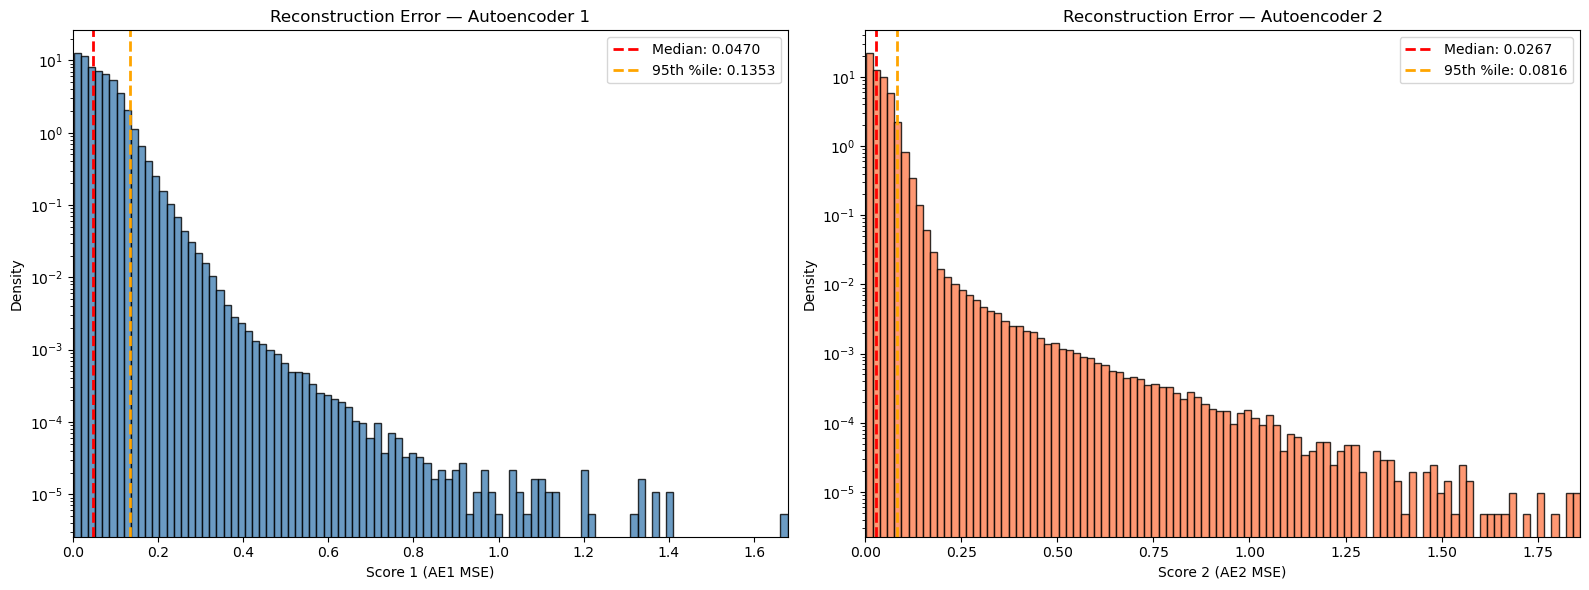

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Score 1 distribution
axes[0].hist(test_s_1, bins=100, color='steelblue', edgecolor='black', alpha=0.8, density=True)
axes[0].axvline(np.median(test_s_1), color='red', ls='--', lw=2, label=f'Median: {np.median(test_s_1):.4f}')
axes[0].axvline(np.percentile(test_s_1, 95), color='orange', ls='--', lw=2, label=f'95th %ile: {np.percentile(test_s_1, 95):.4f}')
axes[0].set_xlabel('Score 1 (AE1 MSE)')
axes[0].set_ylabel('Density')
axes[0].set_title('Reconstruction Error — Autoencoder 1')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_xlim(0, np.percentile(test_s_1, 100))

# Score 2 distribution
axes[1].hist(test_s_2, bins=100, color='coral', edgecolor='black', alpha=0.8, density=True)
axes[1].axvline(np.median(test_s_2), color='red', ls='--', lw=2, label=f'Median: {np.median(test_s_2):.4f}')
axes[1].axvline(np.percentile(test_s_2, 95), color='orange', ls='--', lw=2, label=f'95th %ile: {np.percentile(test_s_2, 95):.4f}')
axes[1].set_xlabel('Score 2 (AE2 MSE)')
axes[1].set_ylabel('Density')
axes[1].set_title('Reconstruction Error — Autoencoder 2')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].set_xlim(0, np.percentile(test_s_2, 100))

plt.tight_layout()
plt.show()


=== Running Global ABCD Threshold Scan (30x30) ===

GLOBAL ABCD SCAN RESULTS
Pull Mean:        -19.886
Pull Std:         18.478
Max Pull:         24.39 sigma
Min Pull:         -49.86 sigma
Median Ratio:     0.6423


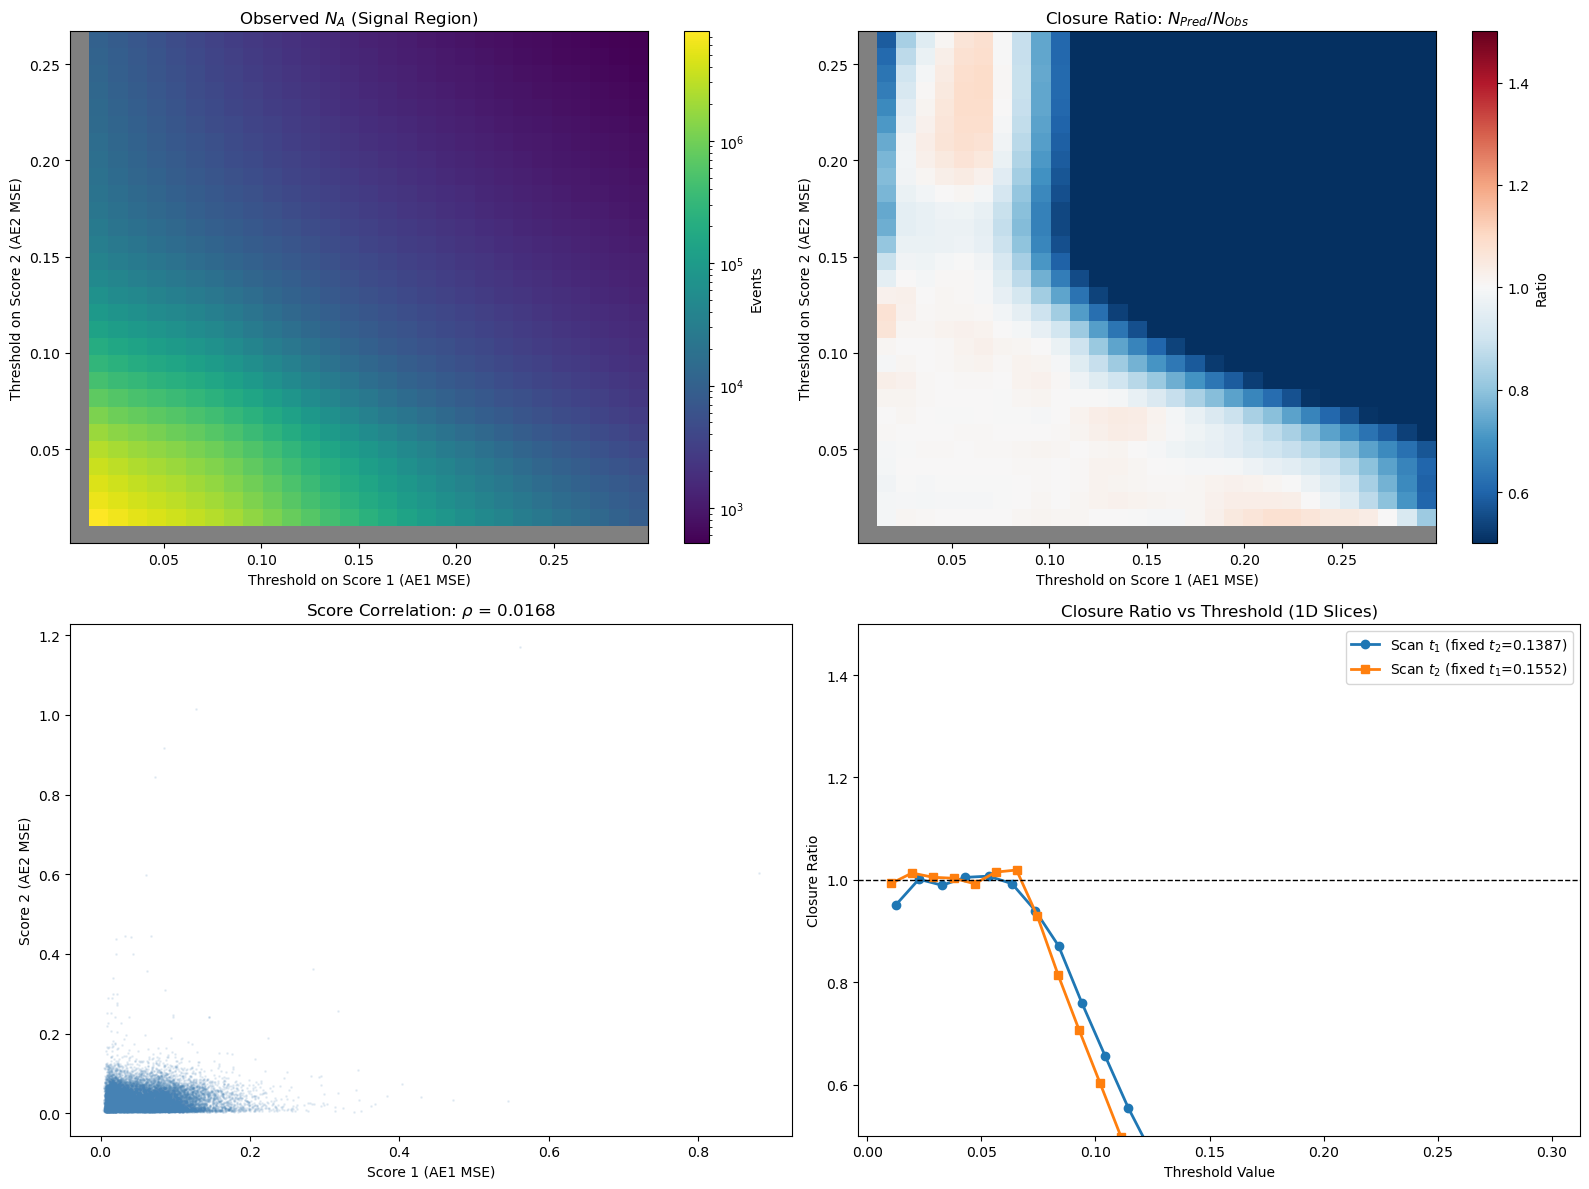

In [26]:
# =============================================
# 0. COMPUTE SCORES
# =============================================
test_s_1 = np.mean((test_s - recon_1)**2, axis=1)
test_s_2 = np.mean((test_s - recon_2)**2, axis=1)

# =============================================
# 1. CONFIGURATION
# =============================================
n_scan = 30
scan_edges_1 = np.linspace(np.percentile(test_s_1, 0), np.percentile(test_s_1, 99.9), n_scan)
scan_edges_2 = np.linspace(np.percentile(test_s_2, 0), np.percentile(test_s_2, 99.9), n_scan)

print(f"\n=== Running Global ABCD Threshold Scan ({n_scan}x{n_scan}) ===")

# =============================================
# 2. SCAN THRESHOLDS
# =============================================
n_A_obs = np.zeros((n_scan, n_scan))
n_A_pred = np.zeros((n_scan, n_scan))
ratio_map = np.full((n_scan, n_scan), np.nan)
pull_map = np.full((n_scan, n_scan), np.nan)

for i, t1 in enumerate(scan_edges_1):
    if i == 0:
        continue
    for j, t2 in enumerate(scan_edges_2):
        if j == 0:
            continue
        mask_A = (test_s_1 > t1) & (test_s_2 > t2)
        mask_B = (test_s_1 > t1) & (test_s_2 <= t2)
        mask_C = (test_s_1 <= t1) & (test_s_2 > t2)
        mask_D = (test_s_1 <= t1) & (test_s_2 <= t2)

        nA = np.sum(mask_A)
        nB = np.sum(mask_B)
        nC = np.sum(mask_C)
        nD = np.sum(mask_D)

        n_A_obs[i, j] = nA

        if nD > 0:
            pred = (nB * nC) / nD
            n_A_pred[i, j] = pred
            ratio_map[i, j] = pred / nA if nA > 0 else np.nan
            pull_map[i, j] = (pred - nA) / np.sqrt(nA) if nA > 0 else np.nan

valid_pulls = pull_map[~np.isnan(pull_map)]
valid_ratios = ratio_map[~np.isnan(ratio_map)]

print("\n" + "="*40)
print("GLOBAL ABCD SCAN RESULTS")
print("="*40)
print(f"Pull Mean:        {np.mean(valid_pulls):.3f}")
print(f"Pull Std:         {np.std(valid_pulls):.3f}")
print(f"Max Pull:         {np.max(valid_pulls):.2f} sigma")
print(f"Min Pull:         {np.min(valid_pulls):.2f} sigma")
print(f"Median Ratio:     {np.median(valid_ratios):.4f}")
print("="*40)

# =============================================
# 3. PLOTTING
# =============================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
extent = [scan_edges_1[0], scan_edges_1[-1], scan_edges_2[0], scan_edges_2[-1]]

# (0,0) Observed N_A
cmap_obs = plt.cm.viridis.copy()
cmap_obs.set_bad(color='grey')
obs_masked = np.ma.array(n_A_obs, mask=(n_A_obs == 0))
im1 = axes[0, 0].imshow(obs_masked.T, origin='lower', aspect='auto', extent=extent,
                          cmap=cmap_obs, norm=mpl.colors.LogNorm(vmin=max(1, n_A_obs[n_A_obs > 0].min())))
axes[0, 0].set_title(r'Observed $N_A$ (Signal Region)')
plt.colorbar(im1, ax=axes[0, 0], label='Events')

# (0,1) Closure Ratio
cmap_ratio = plt.cm.RdBu_r.copy()
cmap_ratio.set_bad(color='grey')
im2 = axes[0, 1].imshow(np.ma.array(ratio_map, mask=np.isnan(ratio_map)).T,
                          origin='lower', aspect='auto', extent=extent,
                          cmap=cmap_ratio, vmin=0.5, vmax=1.5)
axes[0, 1].set_title(r'Closure Ratio: $N_{Pred} / N_{Obs}$')
plt.colorbar(im2, ax=axes[0, 1], label='Ratio')

for ax in axes[0]:
    ax.set_xlabel('Threshold on Score 1 (AE1 MSE)')
    ax.set_ylabel('Threshold on Score 2 (AE2 MSE)')

# (1,0) Score correlation scatter
n_plot = min(20000, len(test_s_1))
axes[1, 0].scatter(test_s_1[:n_plot], test_s_2[:n_plot], s=1, alpha=0.1, c='steelblue')
corr = np.corrcoef(test_s_1, test_s_2)[0, 1]
axes[1, 0].set_xlabel('Score 1 (AE1 MSE)')
axes[1, 0].set_ylabel('Score 2 (AE2 MSE)')
axes[1, 0].set_title(f'Score Correlation: $\\rho$ = {corr:.4f}')

# (1,1) Ratio vs threshold slices
mid_j = n_scan // 2
mid_i = n_scan // 2

ratios_vs_t1 = ratio_map[:, mid_j]
ratios_vs_t2 = ratio_map[mid_i, :]

valid_t1 = ~np.isnan(ratios_vs_t1)
valid_t2 = ~np.isnan(ratios_vs_t2)

axes[1, 1].plot(scan_edges_1[valid_t1], ratios_vs_t1[valid_t1], 'o-', color='tab:blue', lw=2,
                label=f'Scan $t_1$ (fixed $t_2$={scan_edges_2[mid_j]:.4f})')
axes[1, 1].plot(scan_edges_2[valid_t2], ratios_vs_t2[valid_t2], 's-', color='tab:orange', lw=2,
                label=f'Scan $t_2$ (fixed $t_1$={scan_edges_1[mid_i]:.4f})')

axes[1, 1].axhline(1.0, color='black', ls='--', lw=1)
axes[1, 1].set_xlabel('Threshold Value')
axes[1, 1].set_ylabel('Closure Ratio')
axes[1, 1].set_title('Closure Ratio vs Threshold (1D Slices)')
axes[1, 1].legend()
axes[1, 1].set_ylim(0.5, 1.5)

plt.tight_layout()
plt.show()


=== 2022: 1,505,856 events ===
  Median Ratio: 0.6011
  Pull Mean:    -10.548
  Pull Std:     7.081


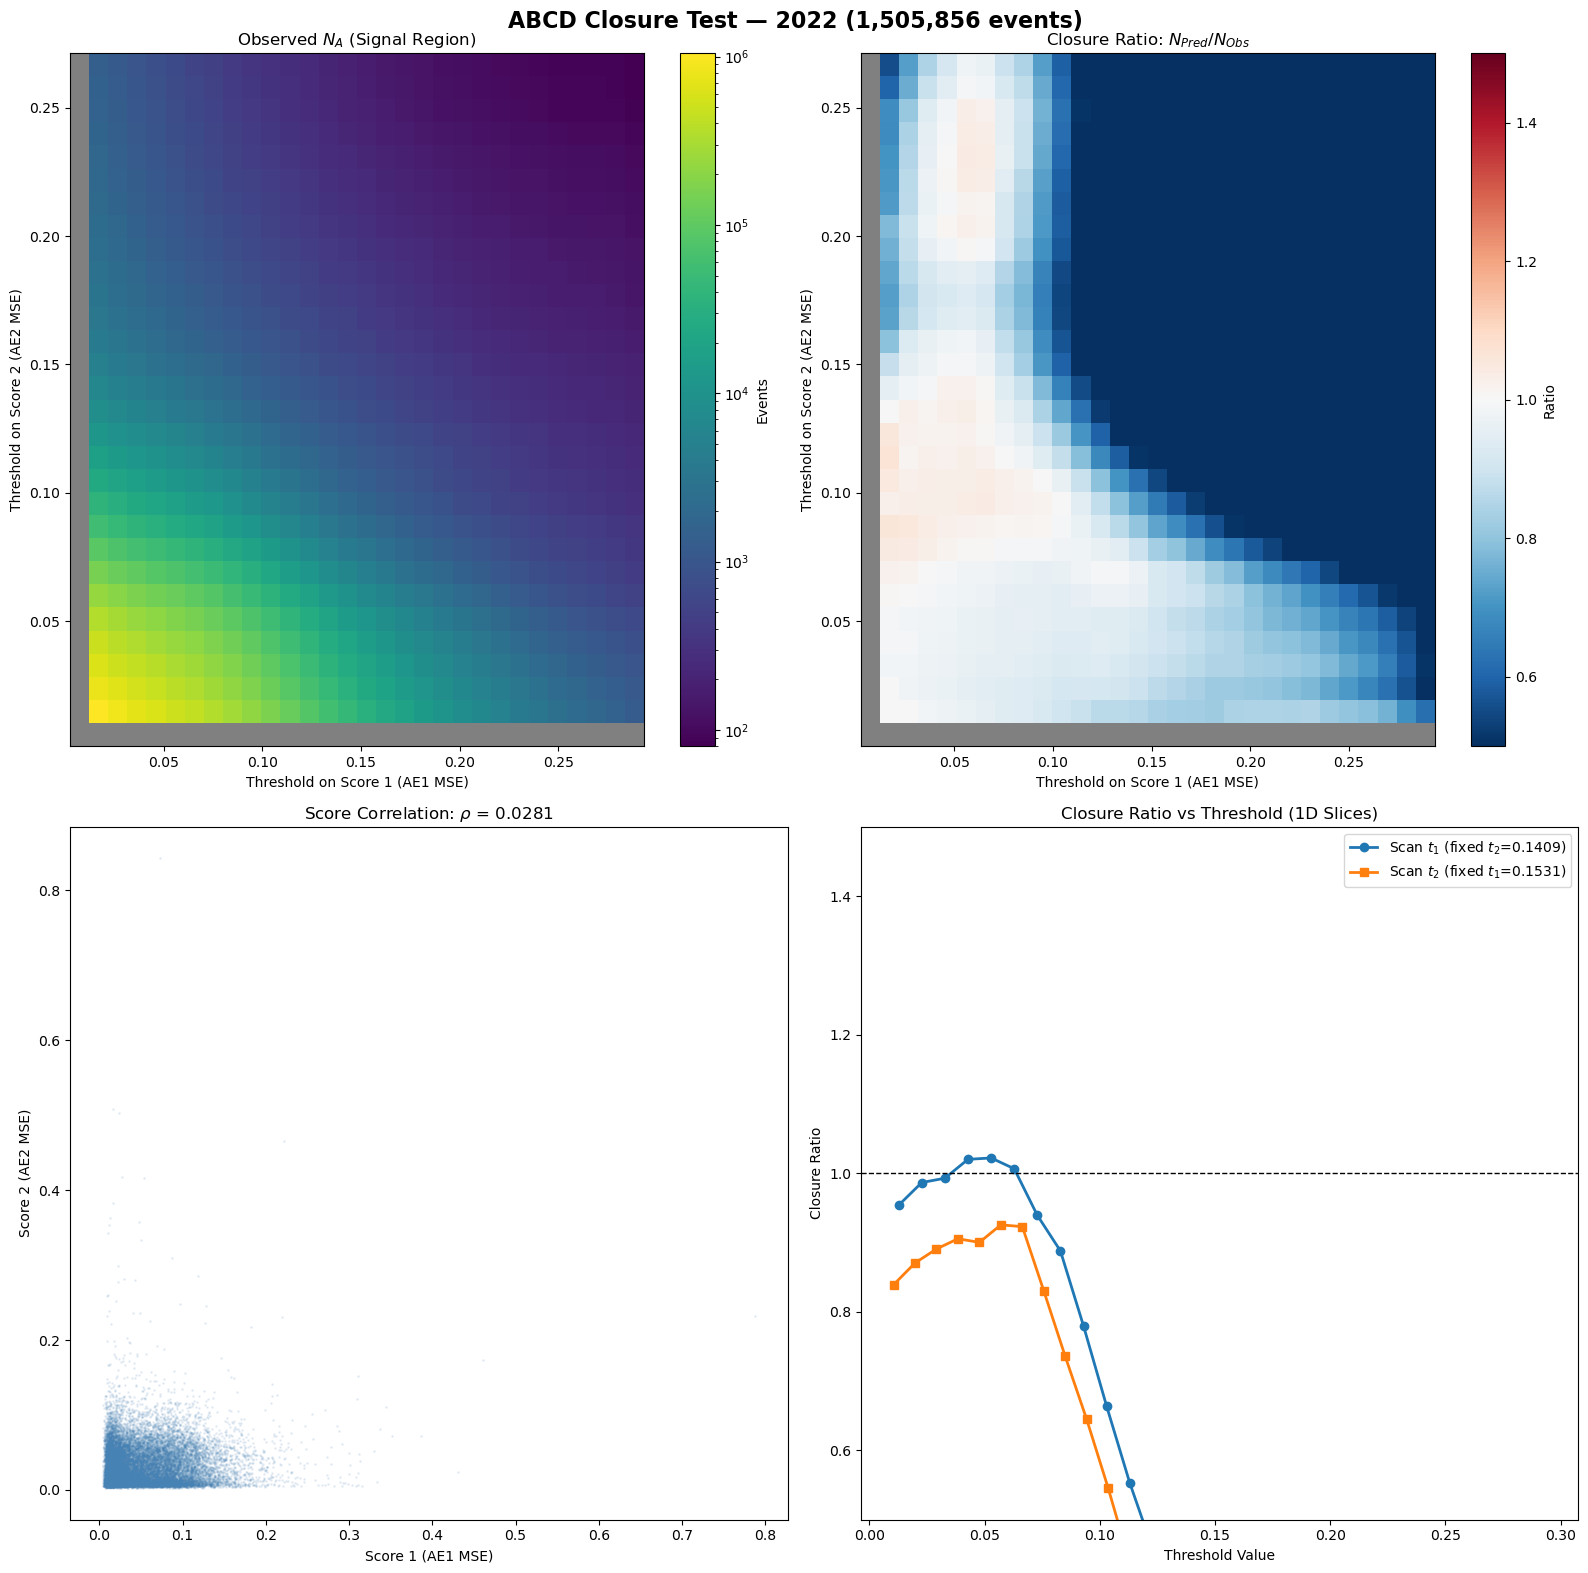


=== 2023: 1,709,696 events ===
  Median Ratio: 0.6200
  Pull Mean:    -7.338
  Pull Std:     8.217


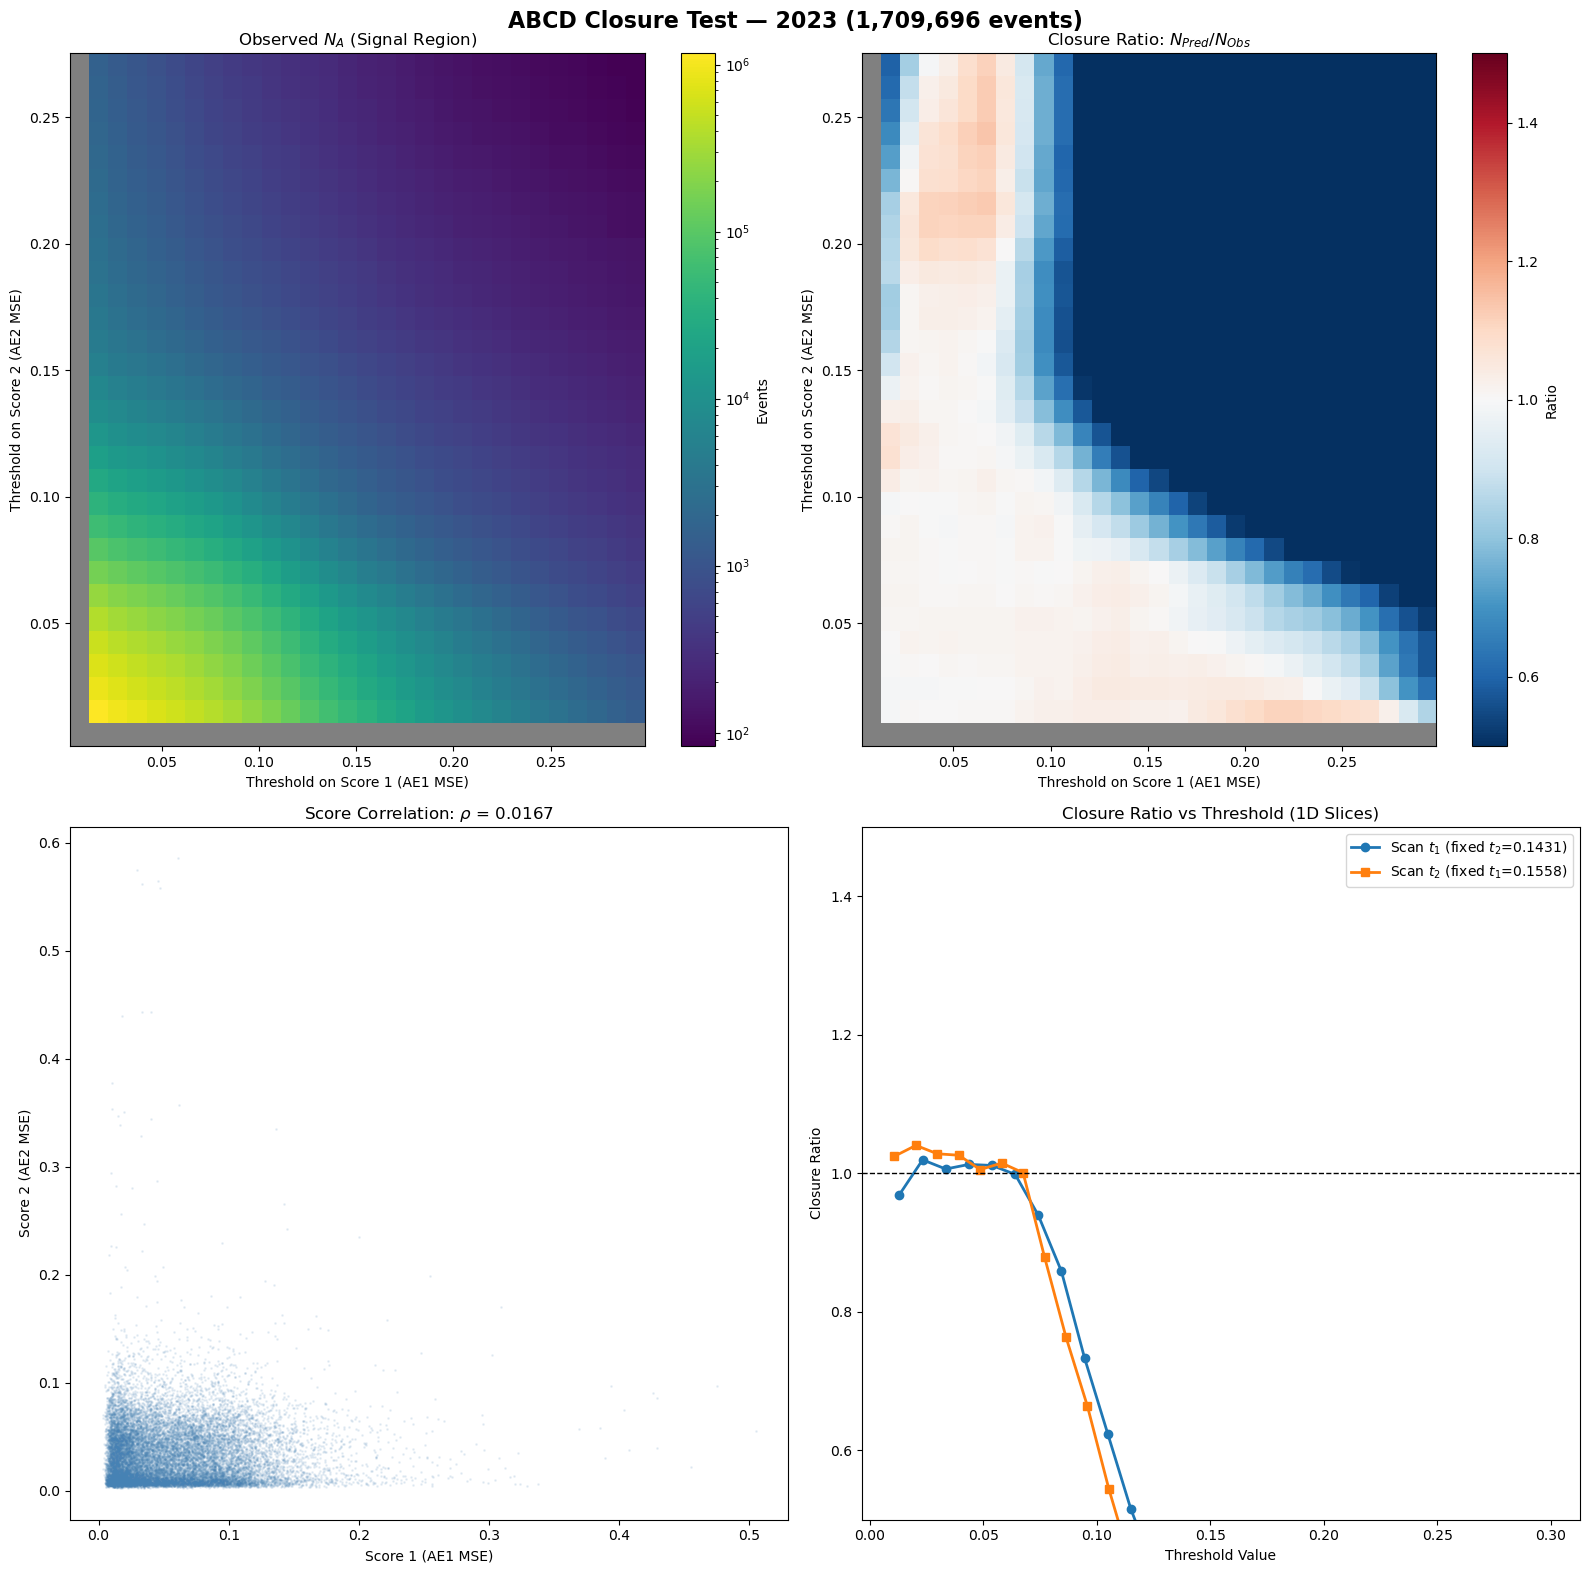


=== 2024: 7,858,863 events ===
  Median Ratio: 0.6574
  Pull Mean:    -15.592
  Pull Std:     16.707


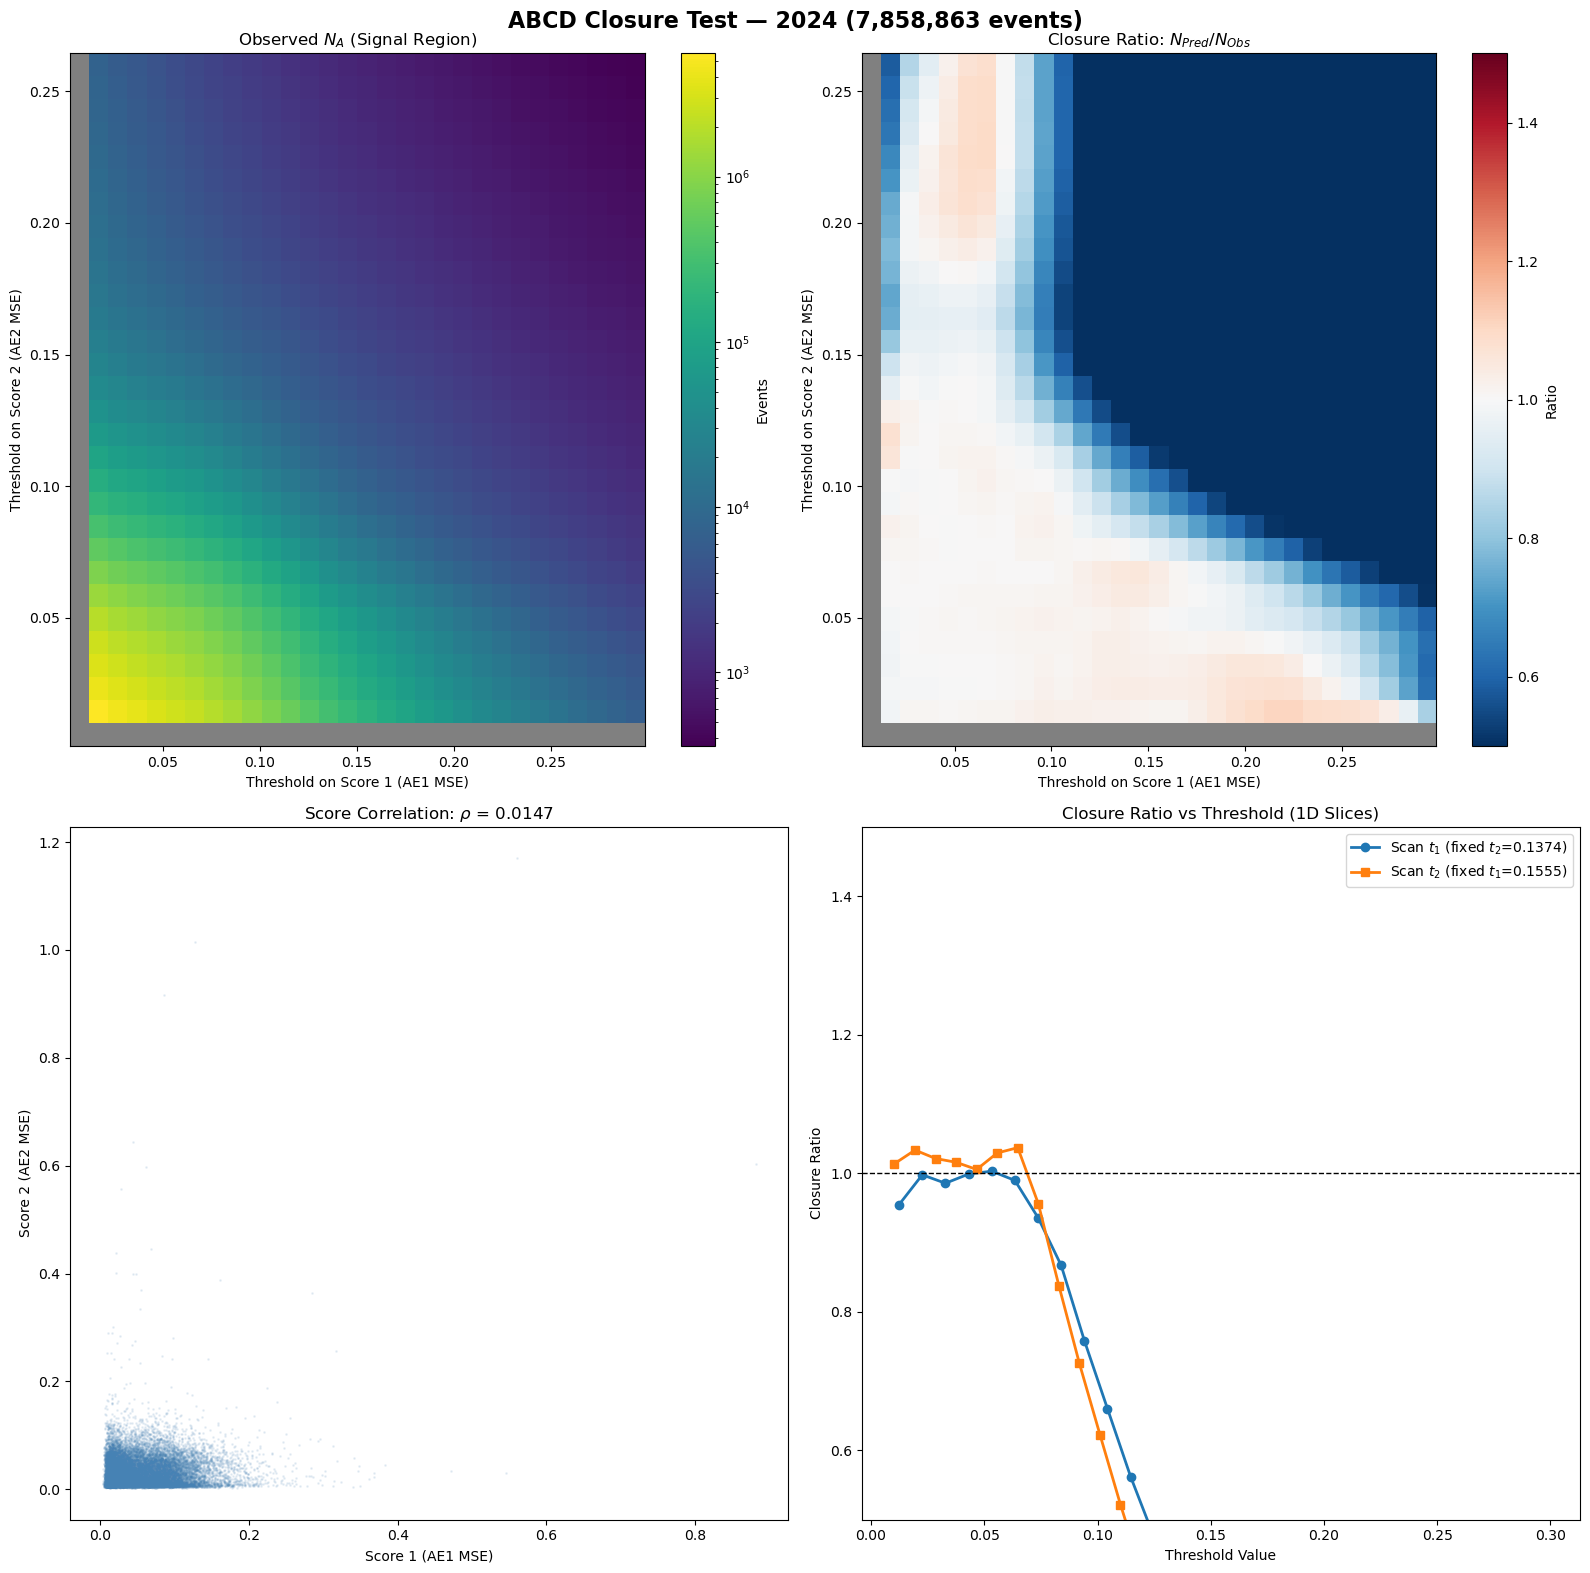


=== Region B+C: 9,332,528 events ===
  Median Ratio: 0.6148
  Pull Mean:    -21.377
  Pull Std:     15.197


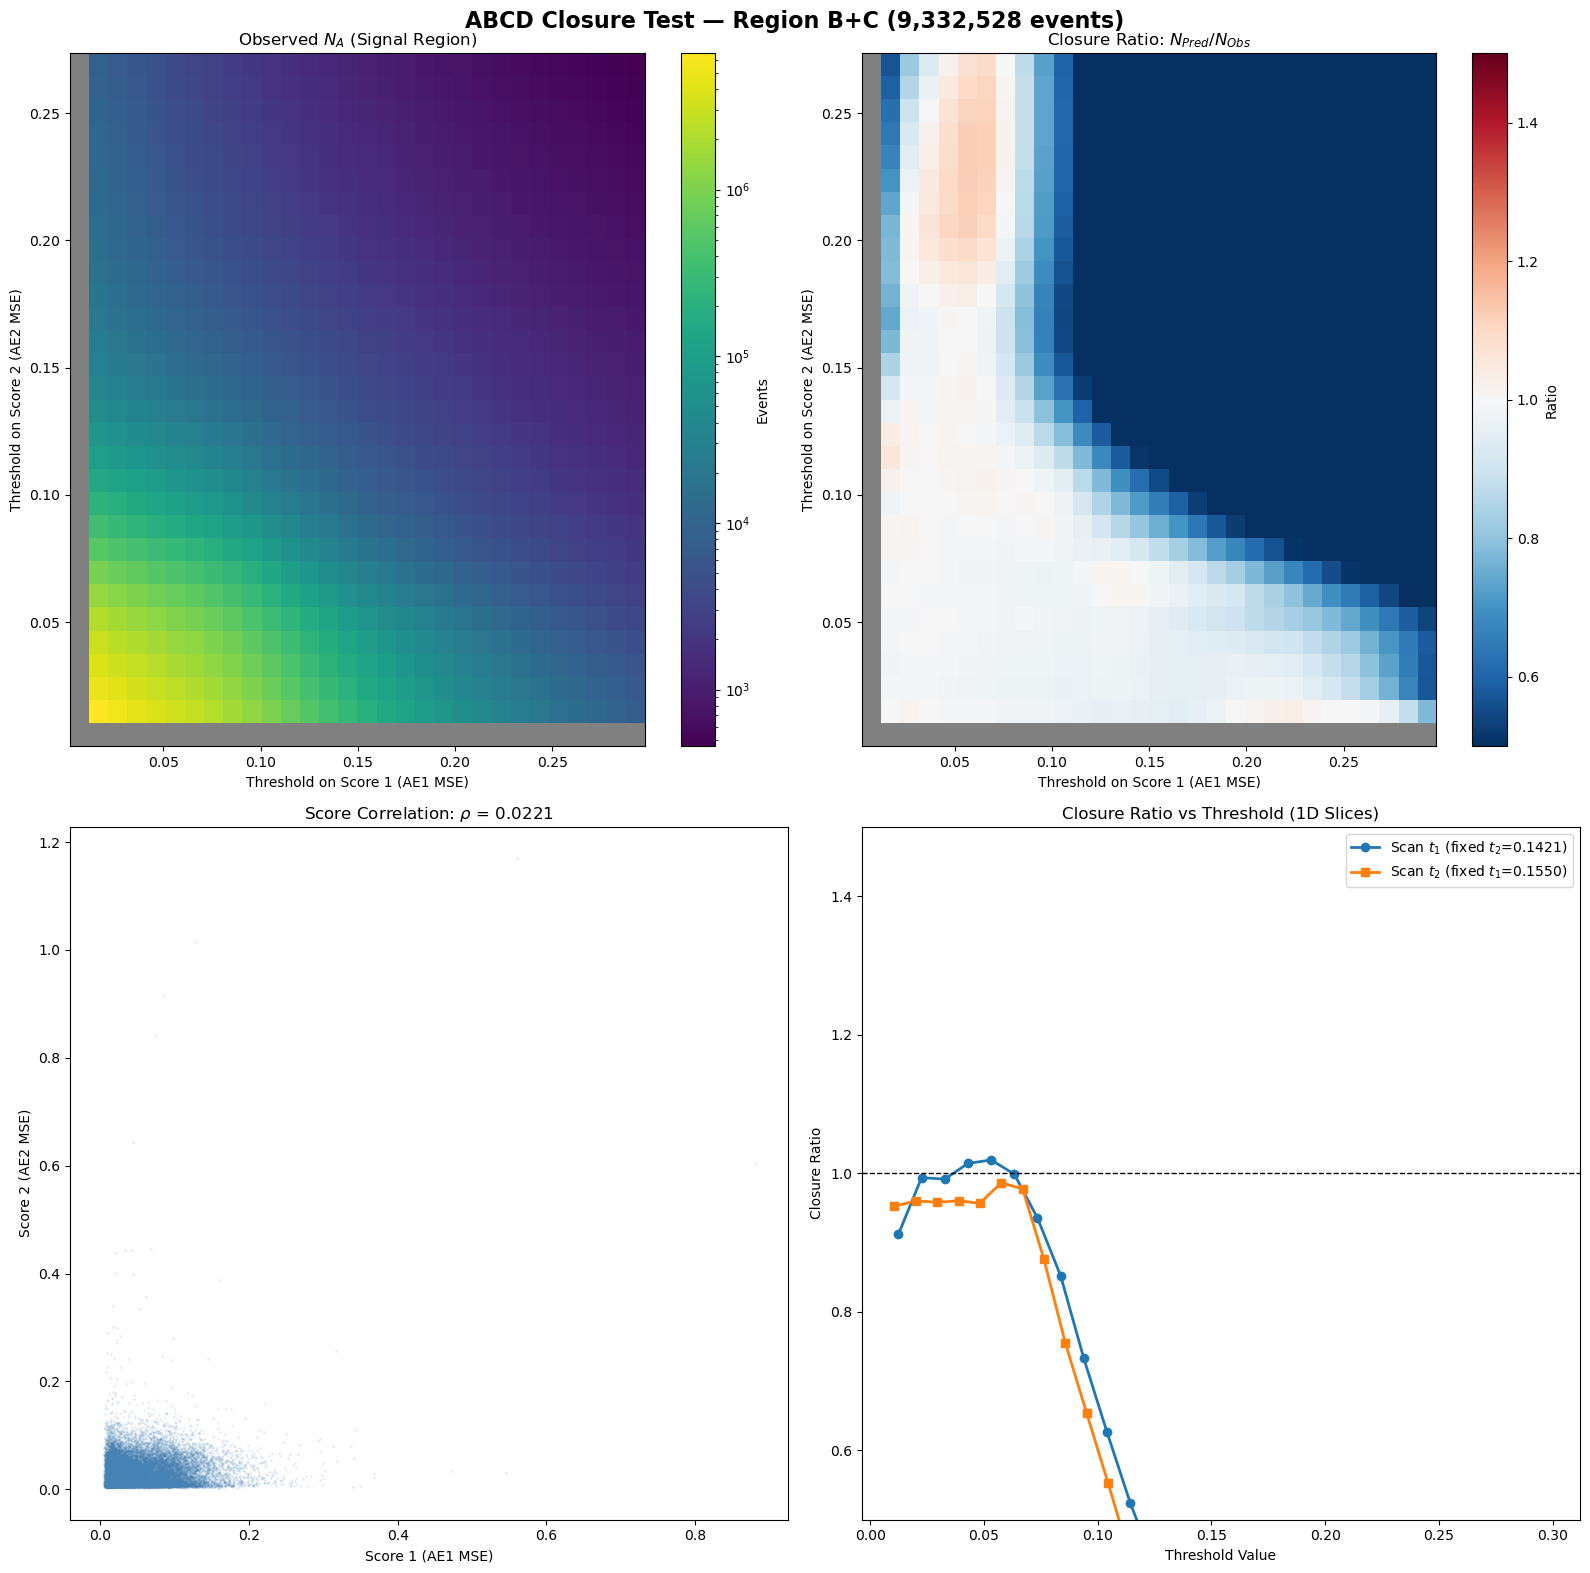


=== No Electron: 1,627,804 events ===
  Median Ratio: 0.2718
  Pull Mean:    -39.448
  Pull Std:     71.373


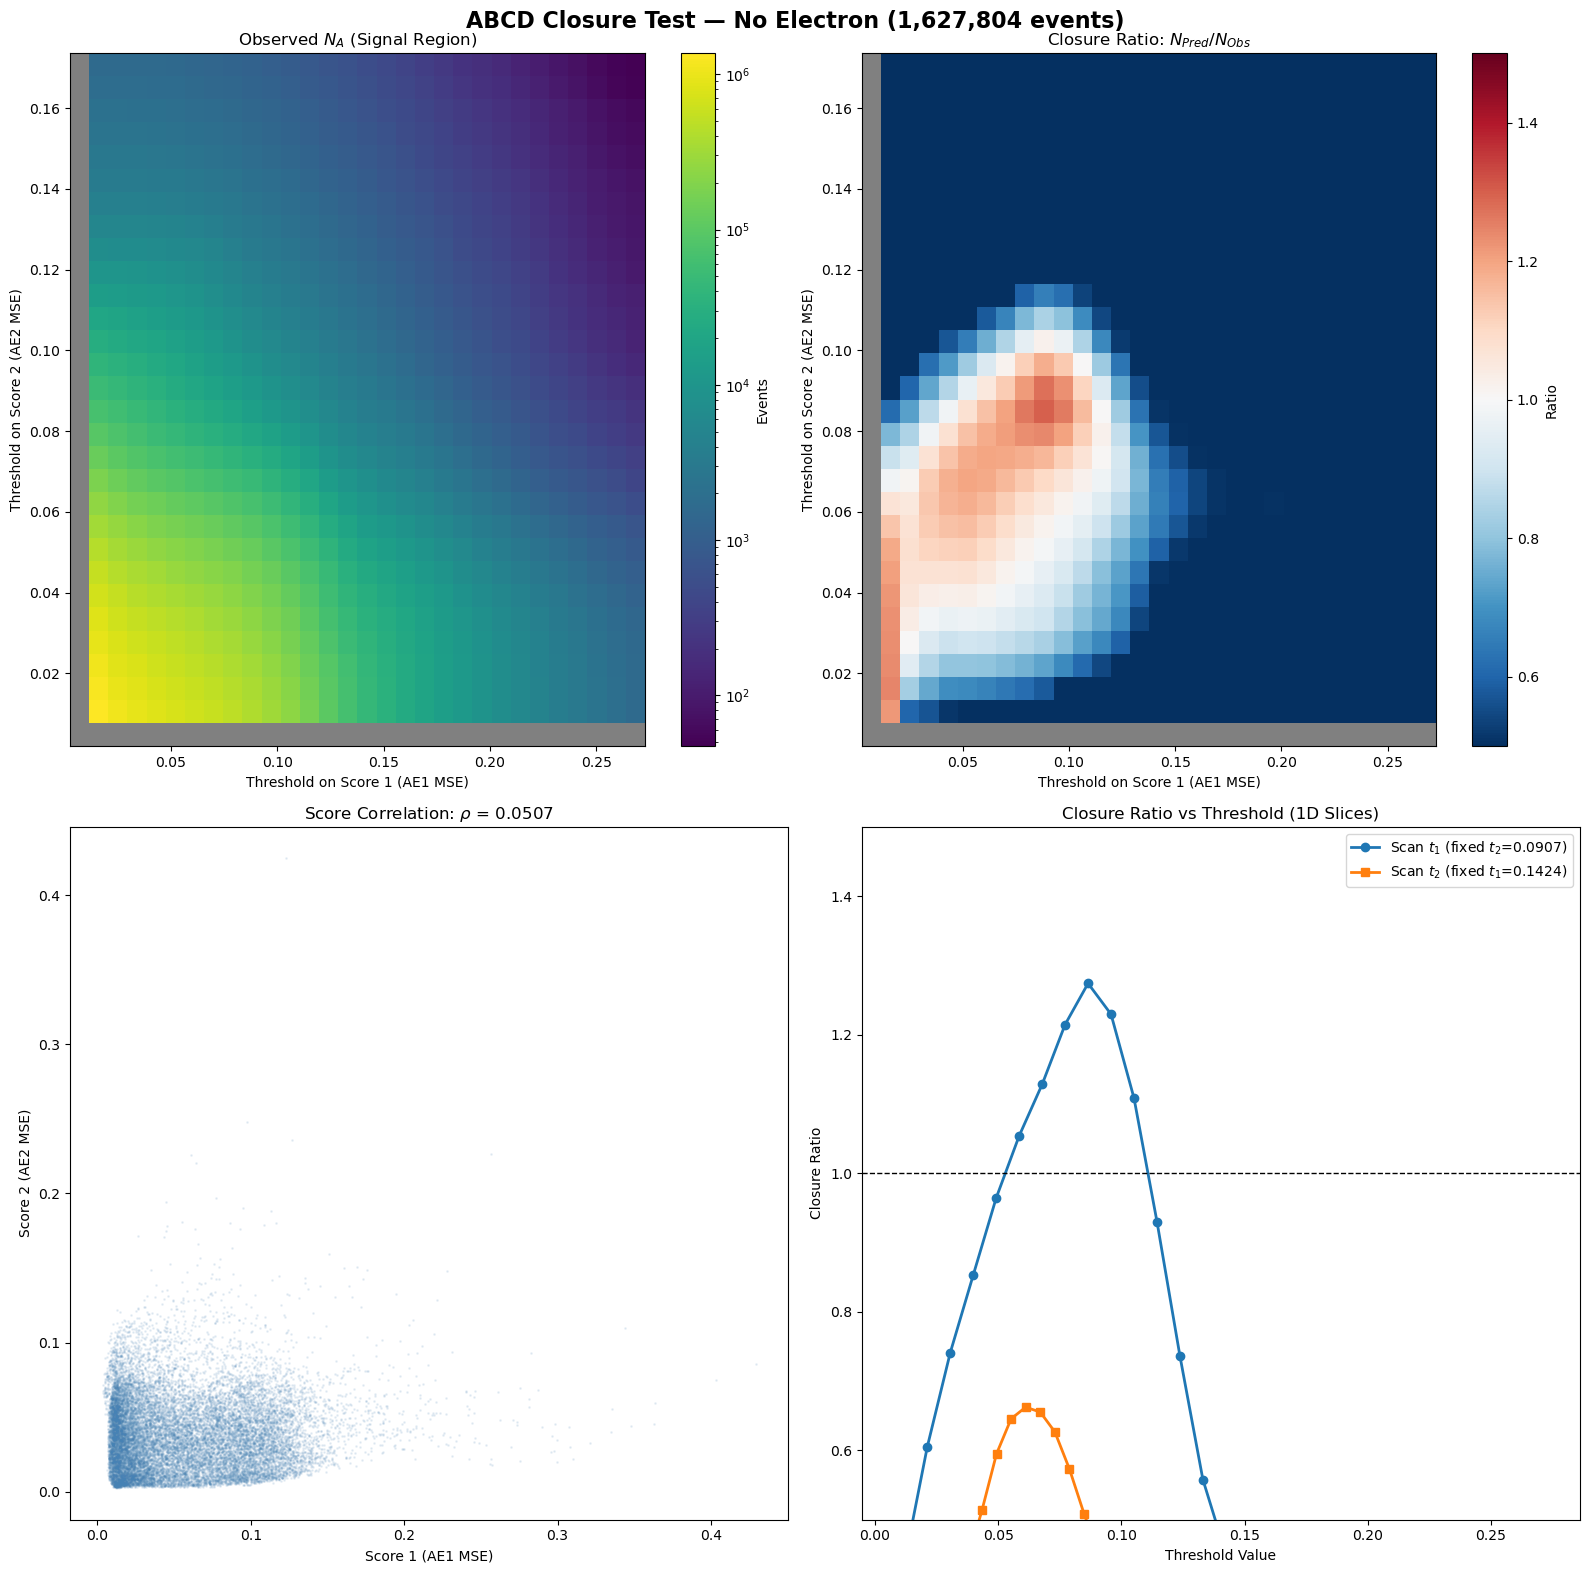


=== No Photon: 5,723,222 events ===
  Median Ratio: 0.9500
  Pull Mean:    32.523
  Pull Std:     78.853


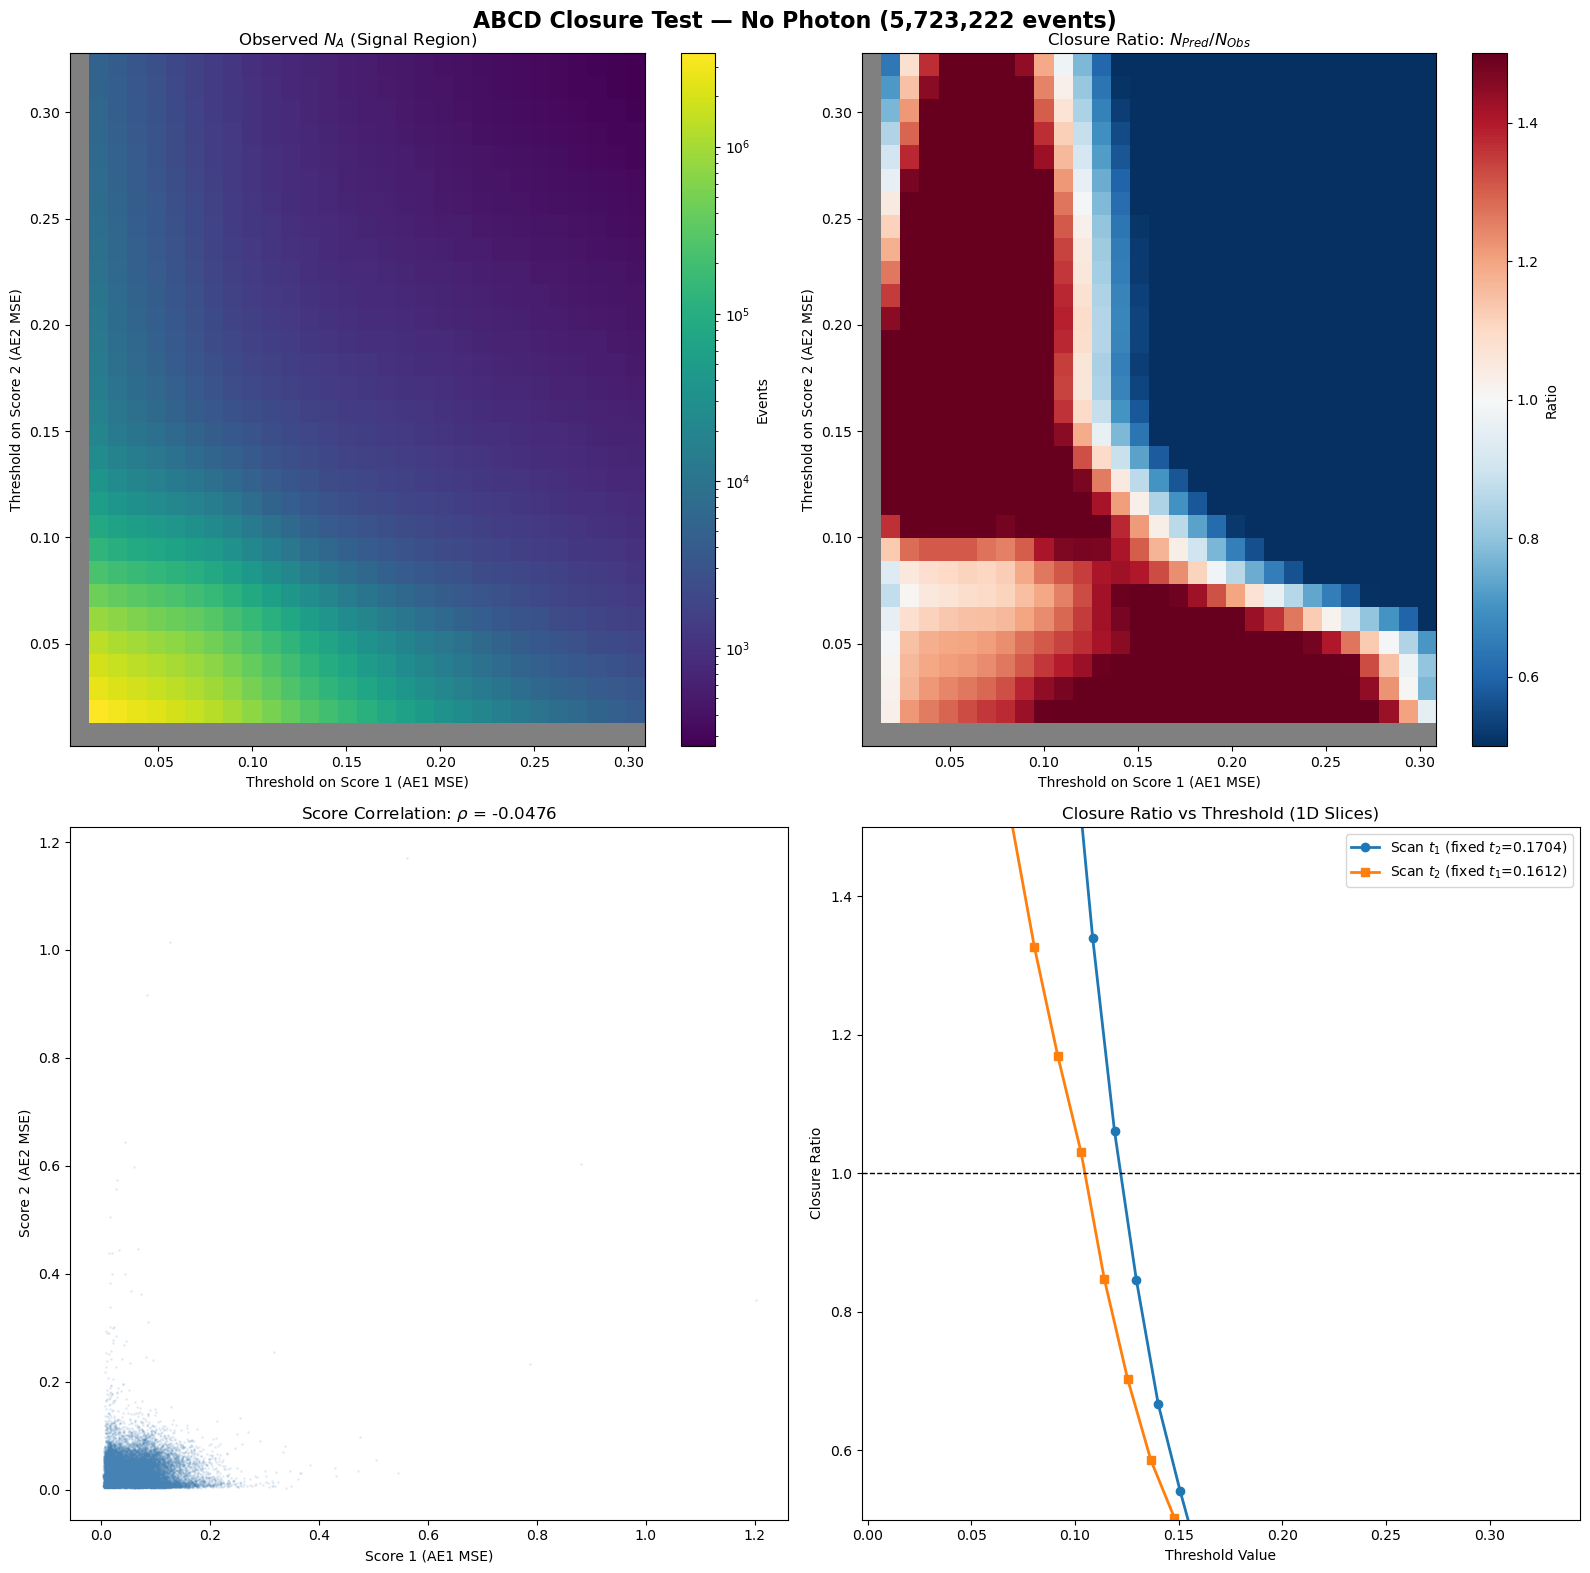

In [27]:
import matplotlib as mpl

# === Define the 6 subsets ===
subsets = {
    "2022":         test_years == 2022,
    "2023":         test_years == 2023,
    "2024":         test_years == 2024,
    "Region B+C":   np.isin(test_ABCD_label, ['B', 'C']),
    "No Electron":  test_zero_electron,
    "No Photon":    test_zero_photon,
}

n_scan = 30

for subset_name, subset_mask in subsets.items():
    s1 = test_s_1[subset_mask]
    s2 = test_s_2[subset_mask]
    n_events = len(s1)
    
    if n_events < 100:
        print(f"\n=== Skipping {subset_name}: only {n_events} events ===")
        continue
    
    print(f"\n=== {subset_name}: {n_events:,} events ===")
    
    scan_edges_1 = np.linspace(np.percentile(s1, 0), np.percentile(s1, 99.9), n_scan)
    scan_edges_2 = np.linspace(np.percentile(s2, 0), np.percentile(s2, 99.9), n_scan)
    
    # --- Scan ---
    n_A_obs = np.zeros((n_scan, n_scan))
    n_A_pred = np.zeros((n_scan, n_scan))
    ratio_map = np.full((n_scan, n_scan), np.nan)
    pull_map = np.full((n_scan, n_scan), np.nan)
    
    for i, t1 in enumerate(scan_edges_1):
        if i == 0:
            continue
        for j, t2 in enumerate(scan_edges_2):
            if j == 0:
                continue
            mask_A = (s1 > t1) & (s2 > t2)
            mask_B = (s1 > t1) & (s2 <= t2)
            mask_C = (s1 <= t1) & (s2 > t2)
            mask_D = (s1 <= t1) & (s2 <= t2)
            
            nA, nB, nC, nD = mask_A.sum(), mask_B.sum(), mask_C.sum(), mask_D.sum()
            n_A_obs[i, j] = nA
            
            if nD > 0:
                pred = (nB * nC) / nD
                n_A_pred[i, j] = pred
                ratio_map[i, j] = pred / nA if nA > 0 else np.nan
                pull_map[i, j] = (pred - nA) / np.sqrt(nA) if nA > 0 else np.nan
    
    valid_ratios = ratio_map[~np.isnan(ratio_map)]
    valid_pulls = pull_map[~np.isnan(pull_map)]
    
    if len(valid_ratios) > 0:
        print(f"  Median Ratio: {np.median(valid_ratios):.4f}")
        print(f"  Pull Mean:    {np.mean(valid_pulls):.3f}")
        print(f"  Pull Std:     {np.std(valid_pulls):.3f}")
    
    # --- Plot: 2x2 ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle(f'ABCD Closure Test — {subset_name} ({n_events:,} events)', fontsize=16, fontweight='bold')
    extent = [scan_edges_1[0], scan_edges_1[-1], scan_edges_2[0], scan_edges_2[-1]]
    
    # (0,0) Observed N_A
    cmap_obs = plt.cm.viridis.copy()
    cmap_obs.set_bad(color='grey')
    obs_masked = np.ma.array(n_A_obs, mask=(n_A_obs == 0))
    im1 = axes[0, 0].imshow(obs_masked.T, origin='lower', aspect='auto', extent=extent,
                              cmap=cmap_obs, norm=mpl.colors.LogNorm(vmin=max(1, n_A_obs[n_A_obs > 0].min())))
    axes[0, 0].set_title(r'Observed $N_A$ (Signal Region)')
    plt.colorbar(im1, ax=axes[0, 0], label='Events')
    
    # (0,1) Closure Ratio
    cmap_ratio = plt.cm.RdBu_r.copy()
    cmap_ratio.set_bad(color='grey')
    im2 = axes[0, 1].imshow(np.ma.array(ratio_map, mask=np.isnan(ratio_map)).T,
                              origin='lower', aspect='auto', extent=extent,
                              cmap=cmap_ratio, vmin=0.5, vmax=1.5)
    axes[0, 1].set_title(r'Closure Ratio: $N_{Pred} / N_{Obs}$')
    plt.colorbar(im2, ax=axes[0, 1], label='Ratio')
    
    for ax in axes[0]:
        ax.set_xlabel('Threshold on Score 1 (AE1 MSE)')
        ax.set_ylabel('Threshold on Score 2 (AE2 MSE)')
    
    # (1,0) Score correlation scatter
    n_plot = min(20000, len(s1))
    axes[1, 0].scatter(s1[:n_plot], s2[:n_plot], s=1, alpha=0.1, c='steelblue')
    corr = np.corrcoef(s1, s2)[0, 1]
    axes[1, 0].set_xlabel('Score 1 (AE1 MSE)')
    axes[1, 0].set_ylabel('Score 2 (AE2 MSE)')
    axes[1, 0].set_title(f'Score Correlation: $\\rho$ = {corr:.4f}')
    
    # (1,1) Ratio vs threshold slices
    mid_j = n_scan // 2
    mid_i = n_scan // 2
    
    ratios_vs_t1 = ratio_map[:, mid_j]
    ratios_vs_t2 = ratio_map[mid_i, :]
    
    valid_t1 = ~np.isnan(ratios_vs_t1)
    valid_t2 = ~np.isnan(ratios_vs_t2)
    
    axes[1, 1].plot(scan_edges_1[valid_t1], ratios_vs_t1[valid_t1], 'o-', color='tab:blue', lw=2,
                    label=f'Scan $t_1$ (fixed $t_2$={scan_edges_2[mid_j]:.4f})')
    axes[1, 1].plot(scan_edges_2[valid_t2], ratios_vs_t2[valid_t2], 's-', color='tab:orange', lw=2,
                    label=f'Scan $t_2$ (fixed $t_1$={scan_edges_1[mid_i]:.4f})')
    
    axes[1, 1].axhline(1.0, color='black', ls='--', lw=1)
    axes[1, 1].set_xlabel('Threshold Value')
    axes[1, 1].set_ylabel('Closure Ratio')
    axes[1, 1].set_title('Closure Ratio vs Threshold (1D Slices)')
    axes[1, 1].legend()
    axes[1, 1].set_ylim(0.5, 1.5)
    
    plt.tight_layout()
    plt.show()


=== 2022: 1,505,856 events ===
  Median Ratio: 0.9747  Pull: -12.705 ± 15.053


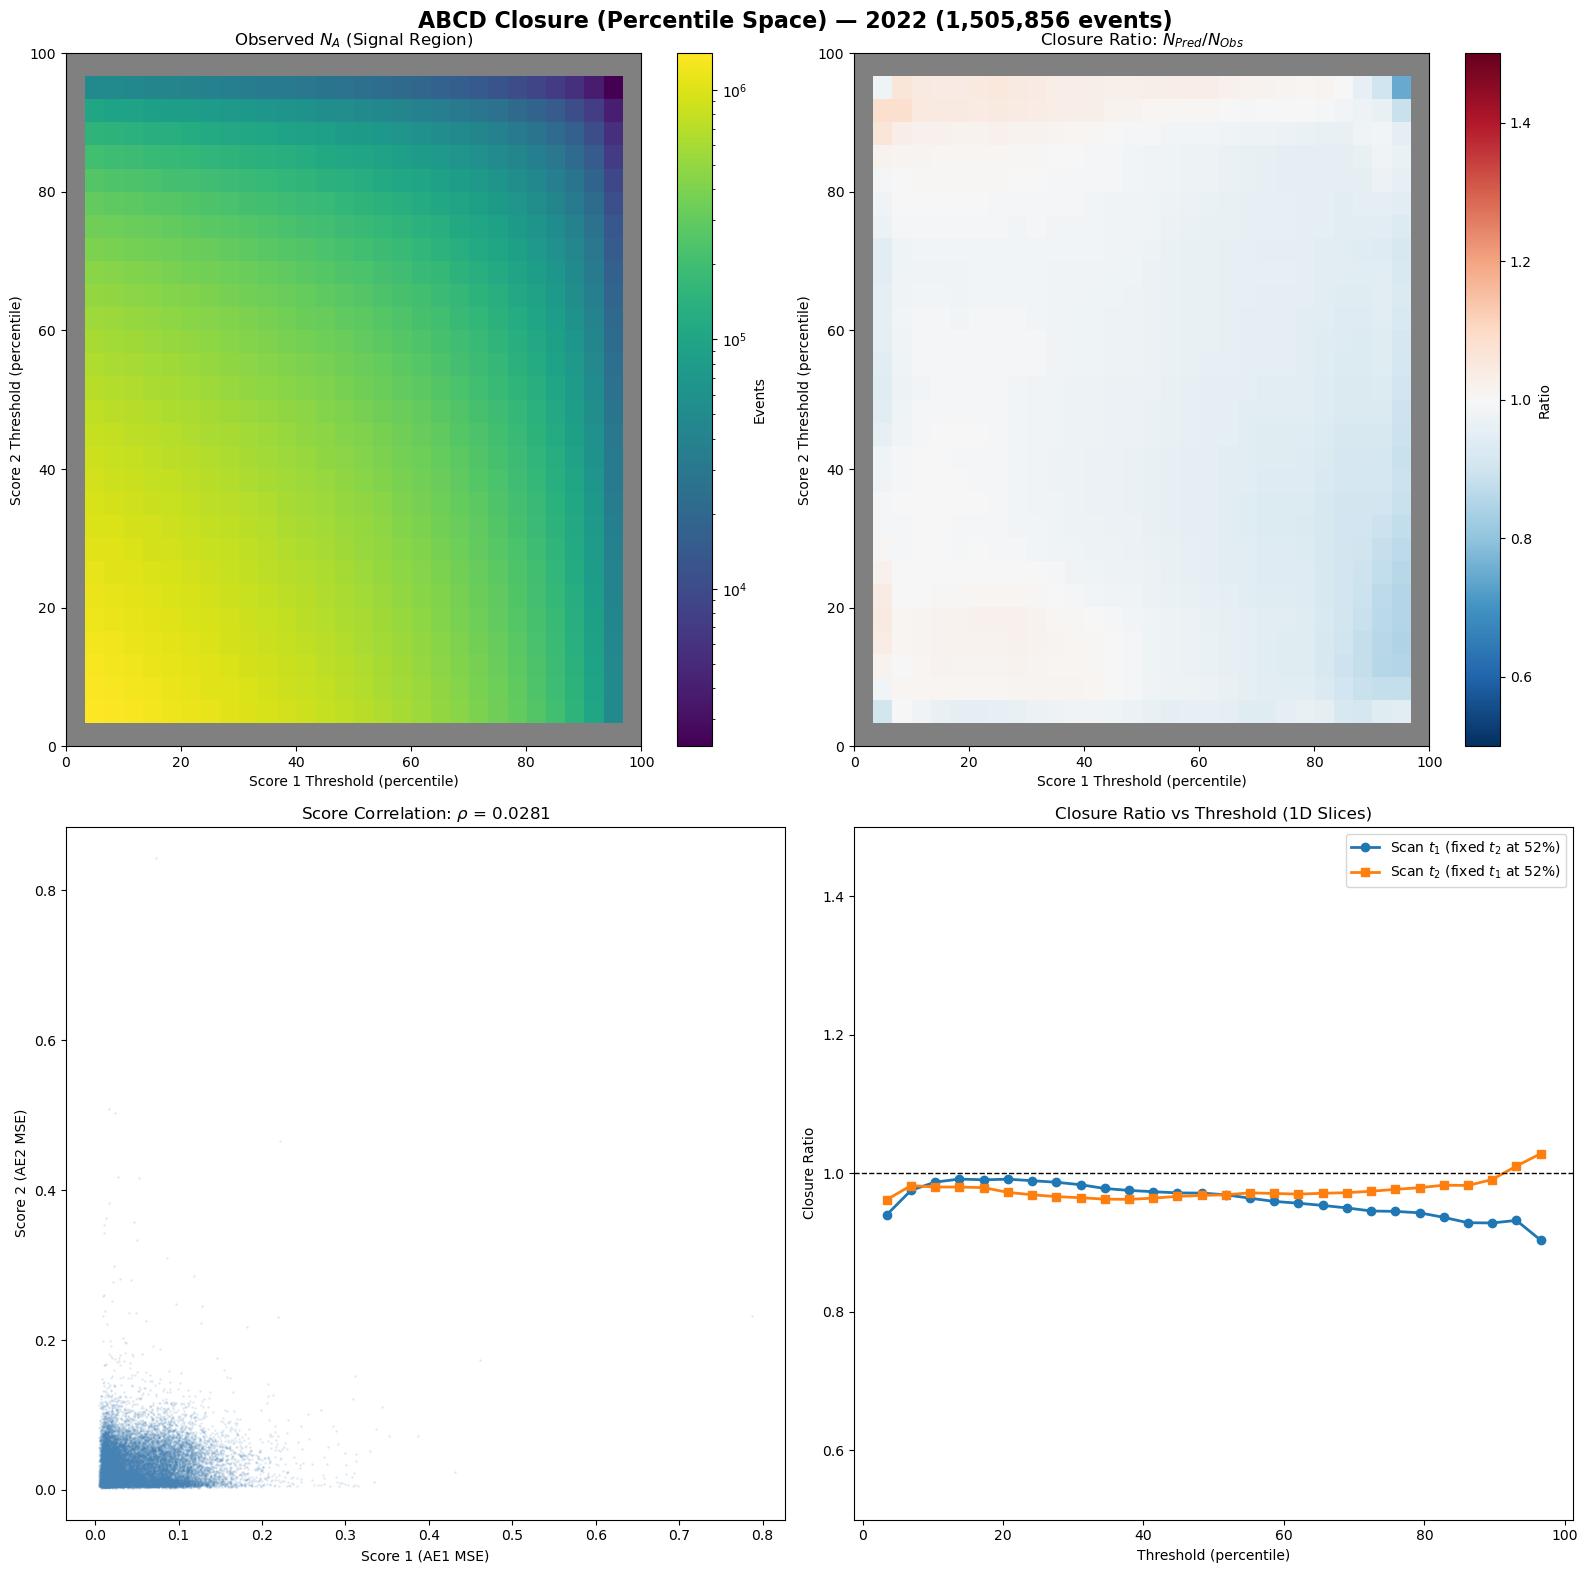


=== 2023: 1,709,696 events ===
  Median Ratio: 1.0100  Pull: 4.658 ± 10.855


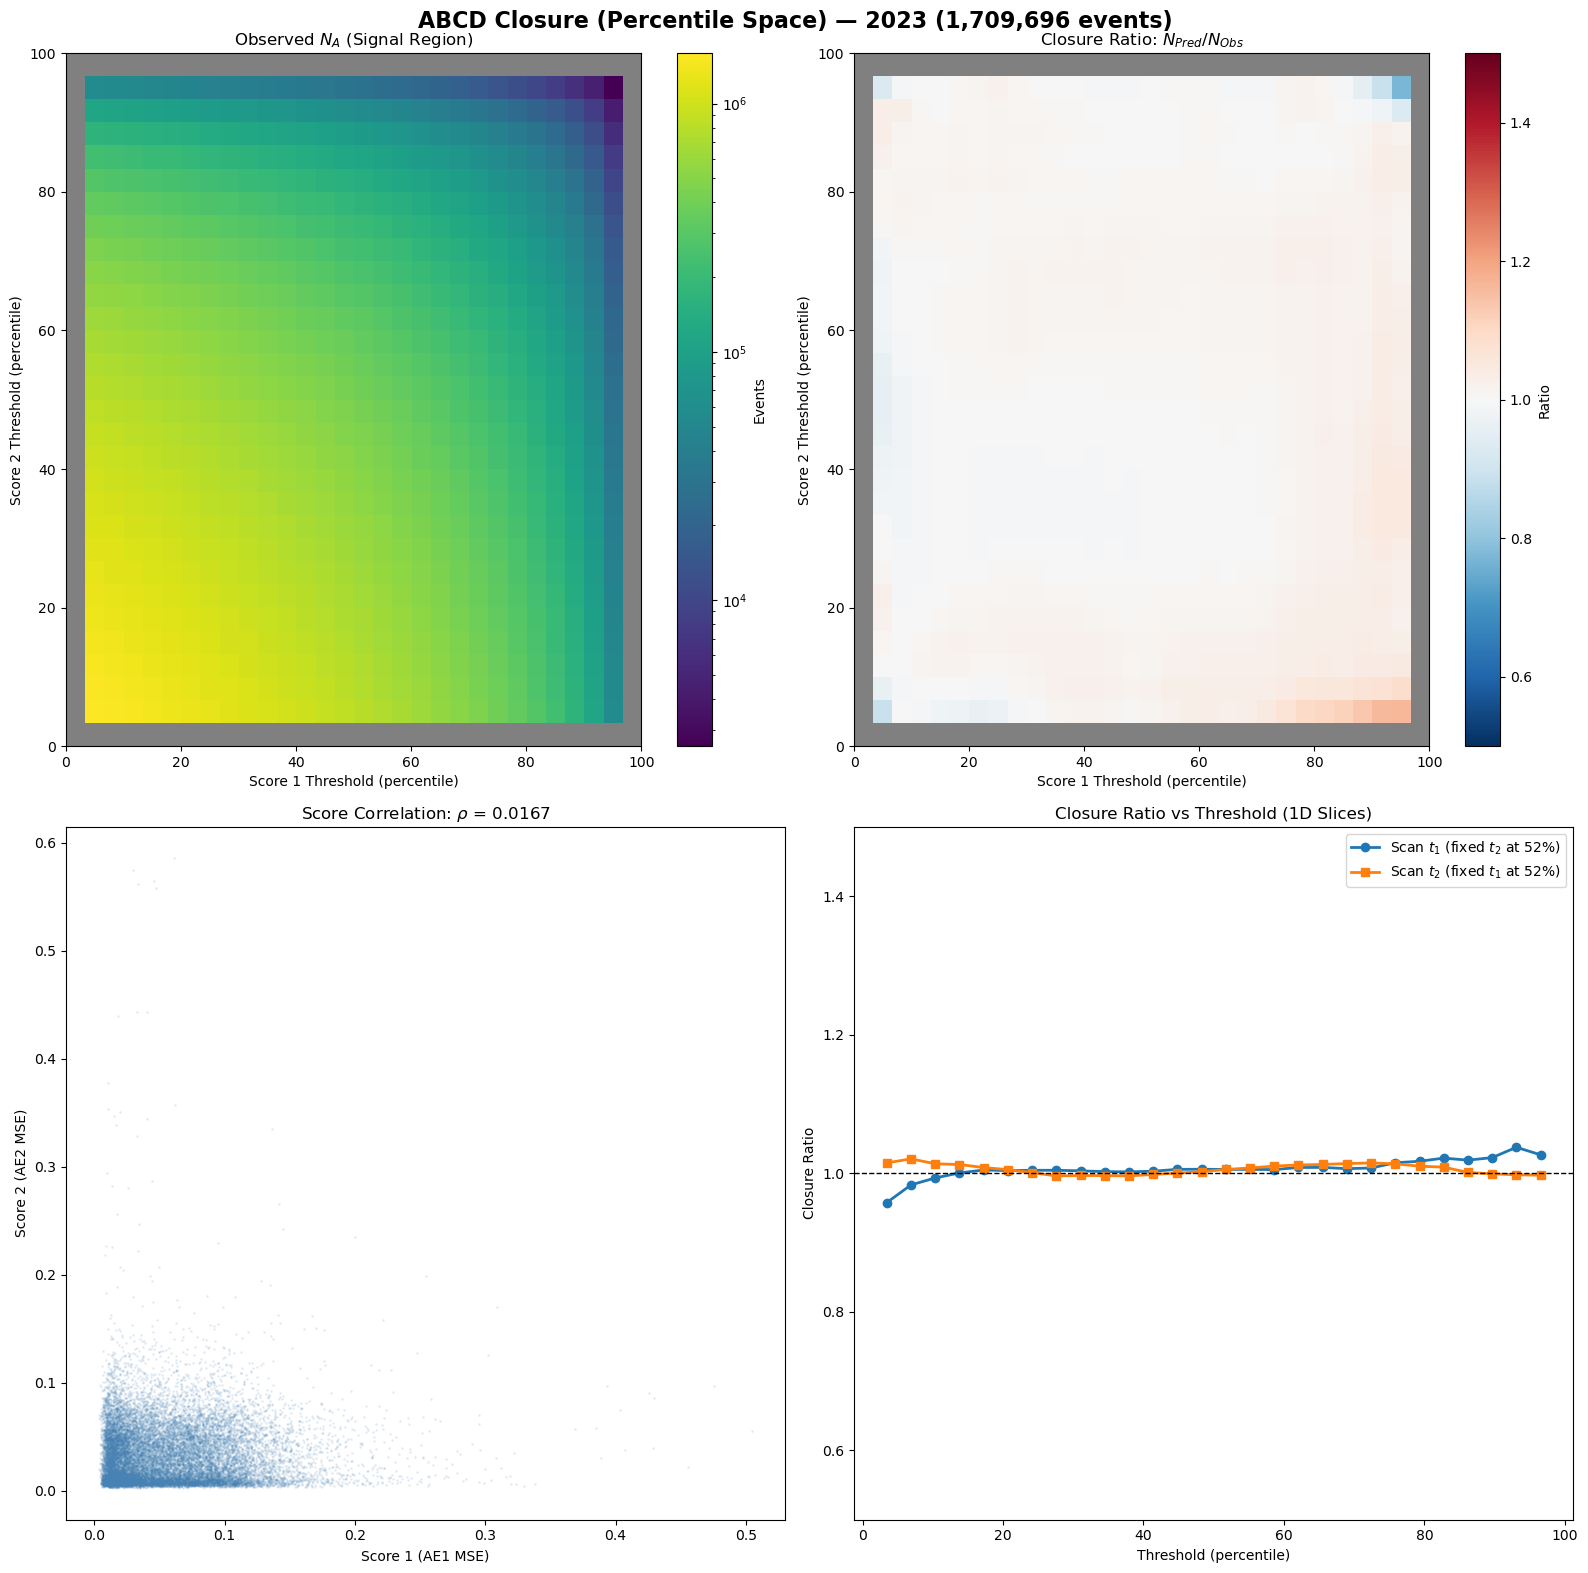


=== 2024: 7,858,863 events ===
  Median Ratio: 1.0059  Pull: 8.159 ± 22.336


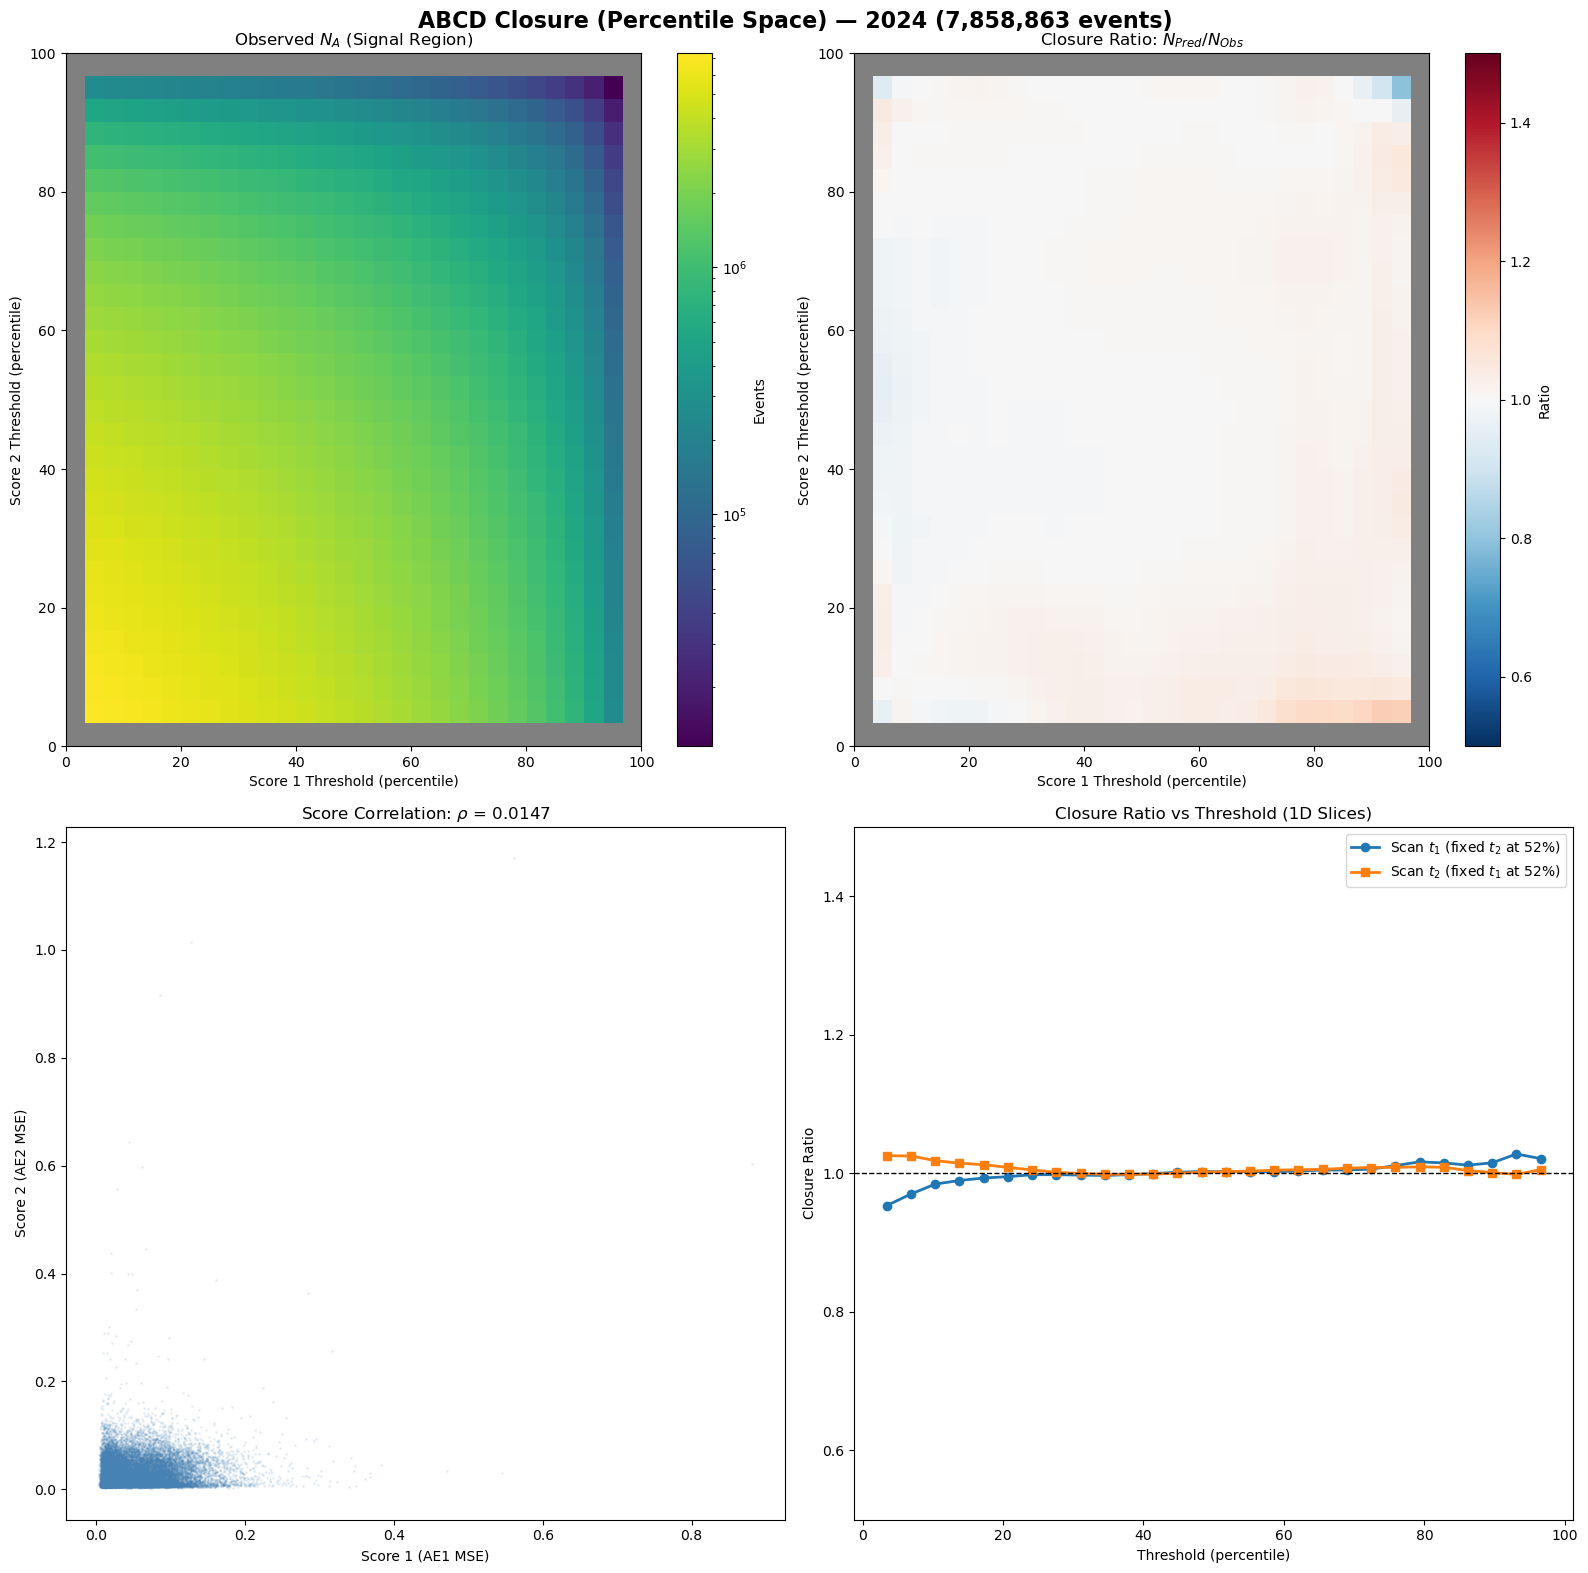


=== Region B+C: 9,332,528 events ===
  Median Ratio: 0.9907  Pull: -7.826 ± 22.531


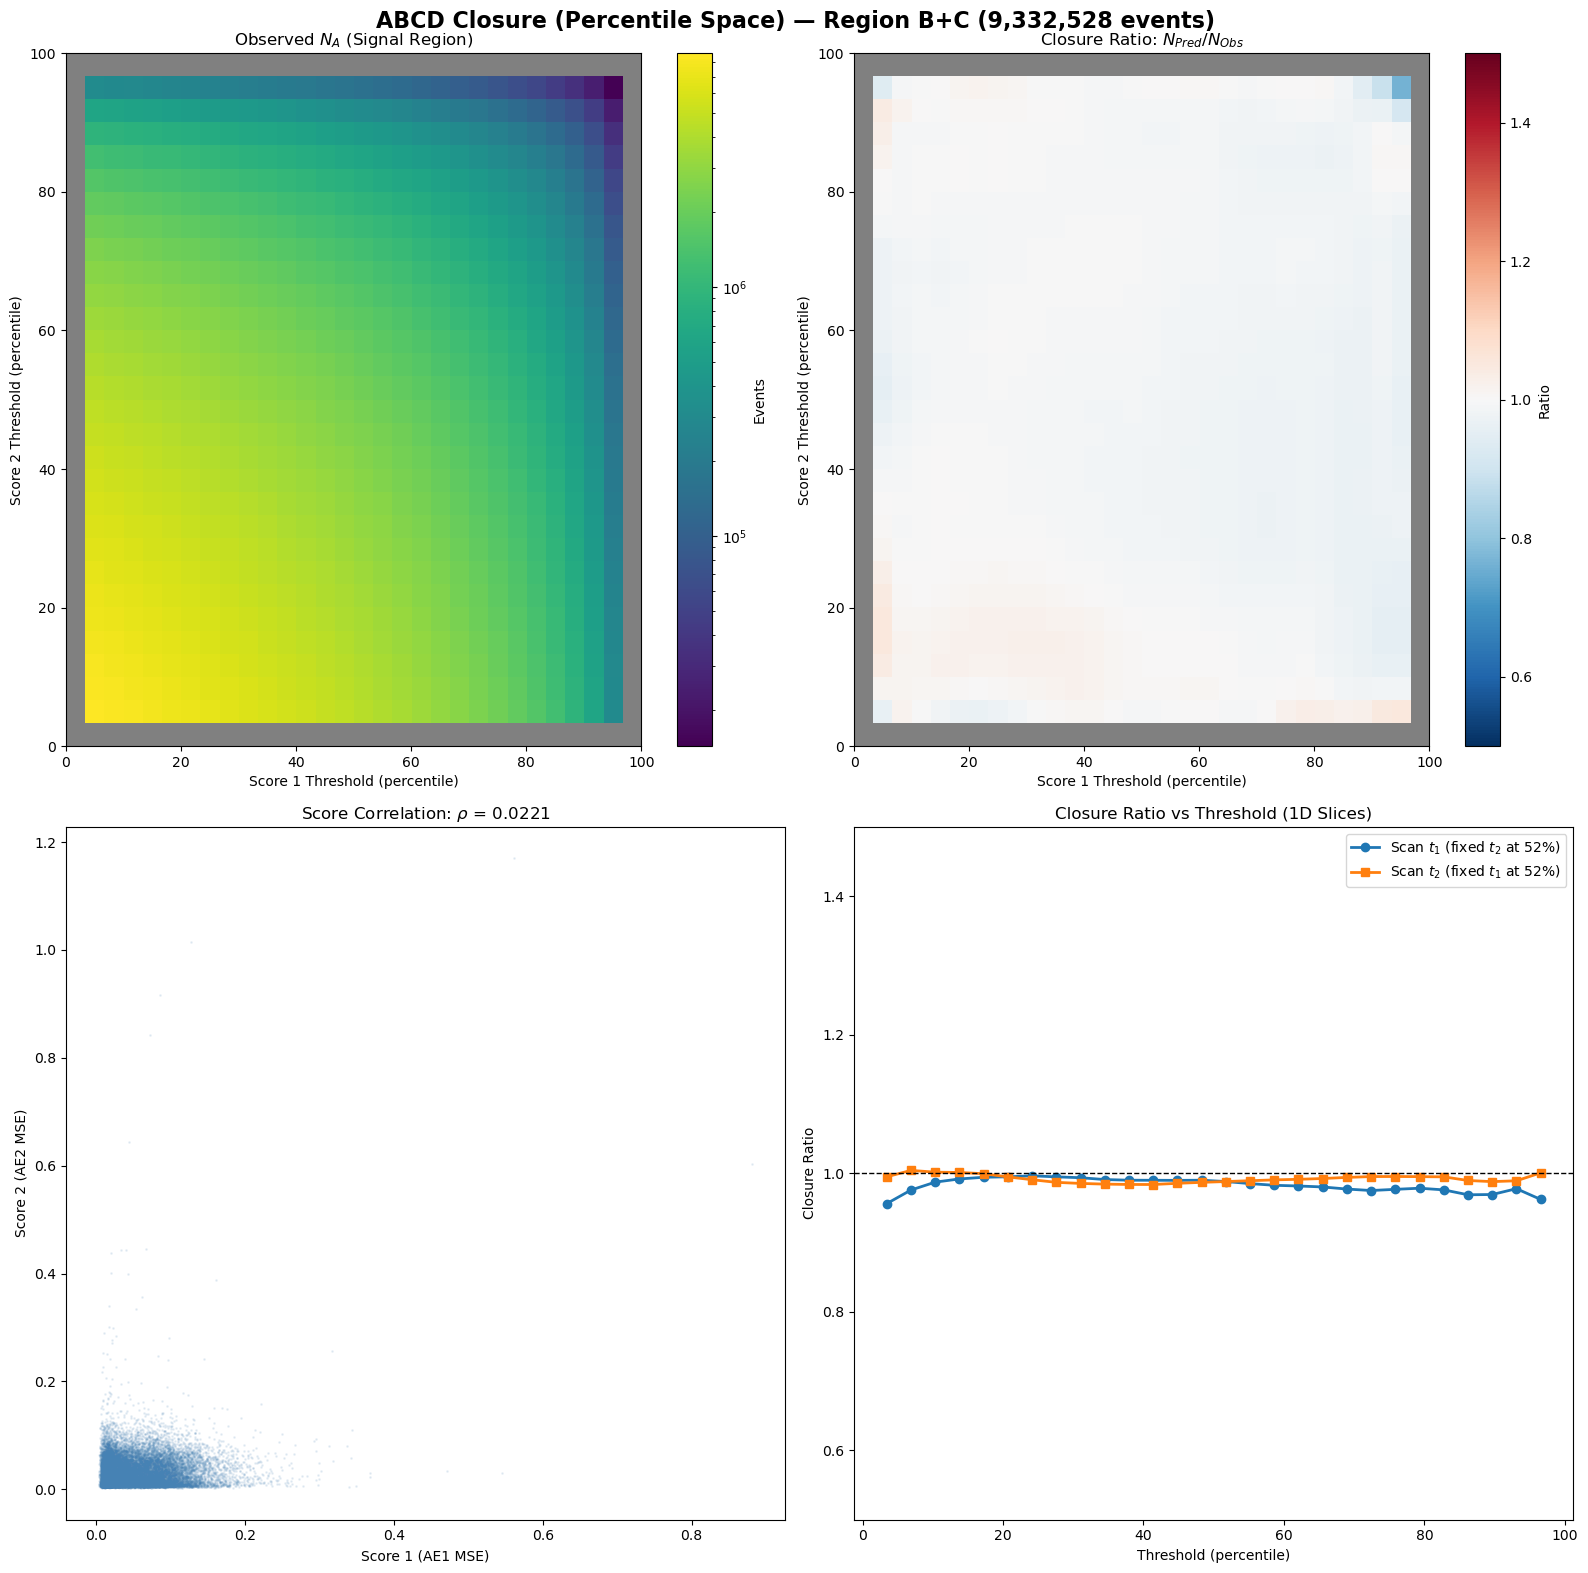


=== No Electron: 1,627,804 events ===
  Median Ratio: 0.9736  Pull: -24.993 ± 421.506


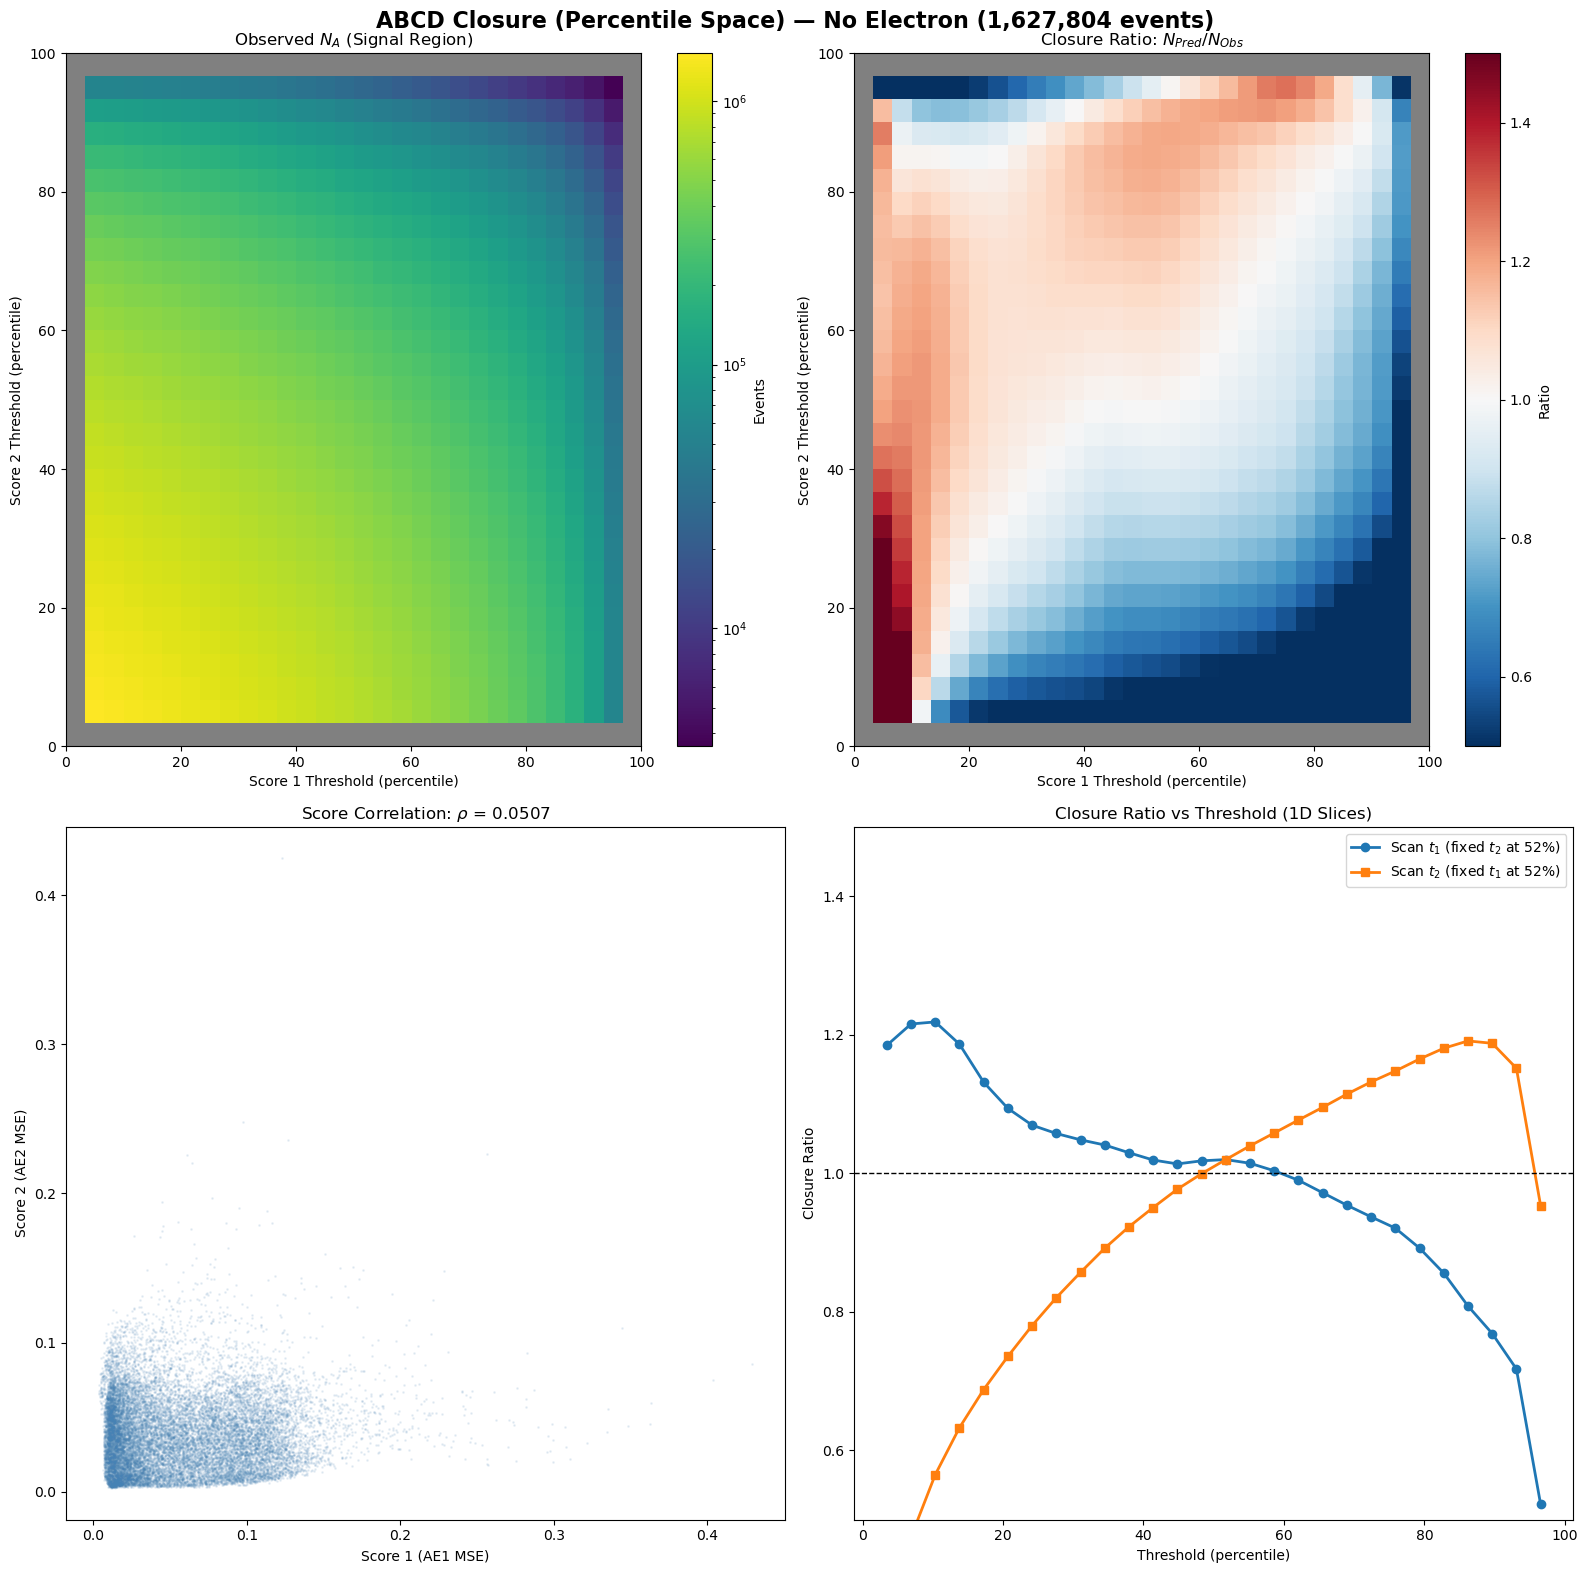


=== No Photon: 5,723,222 events ===
  Median Ratio: 1.2513  Pull: 259.870 ± 242.166


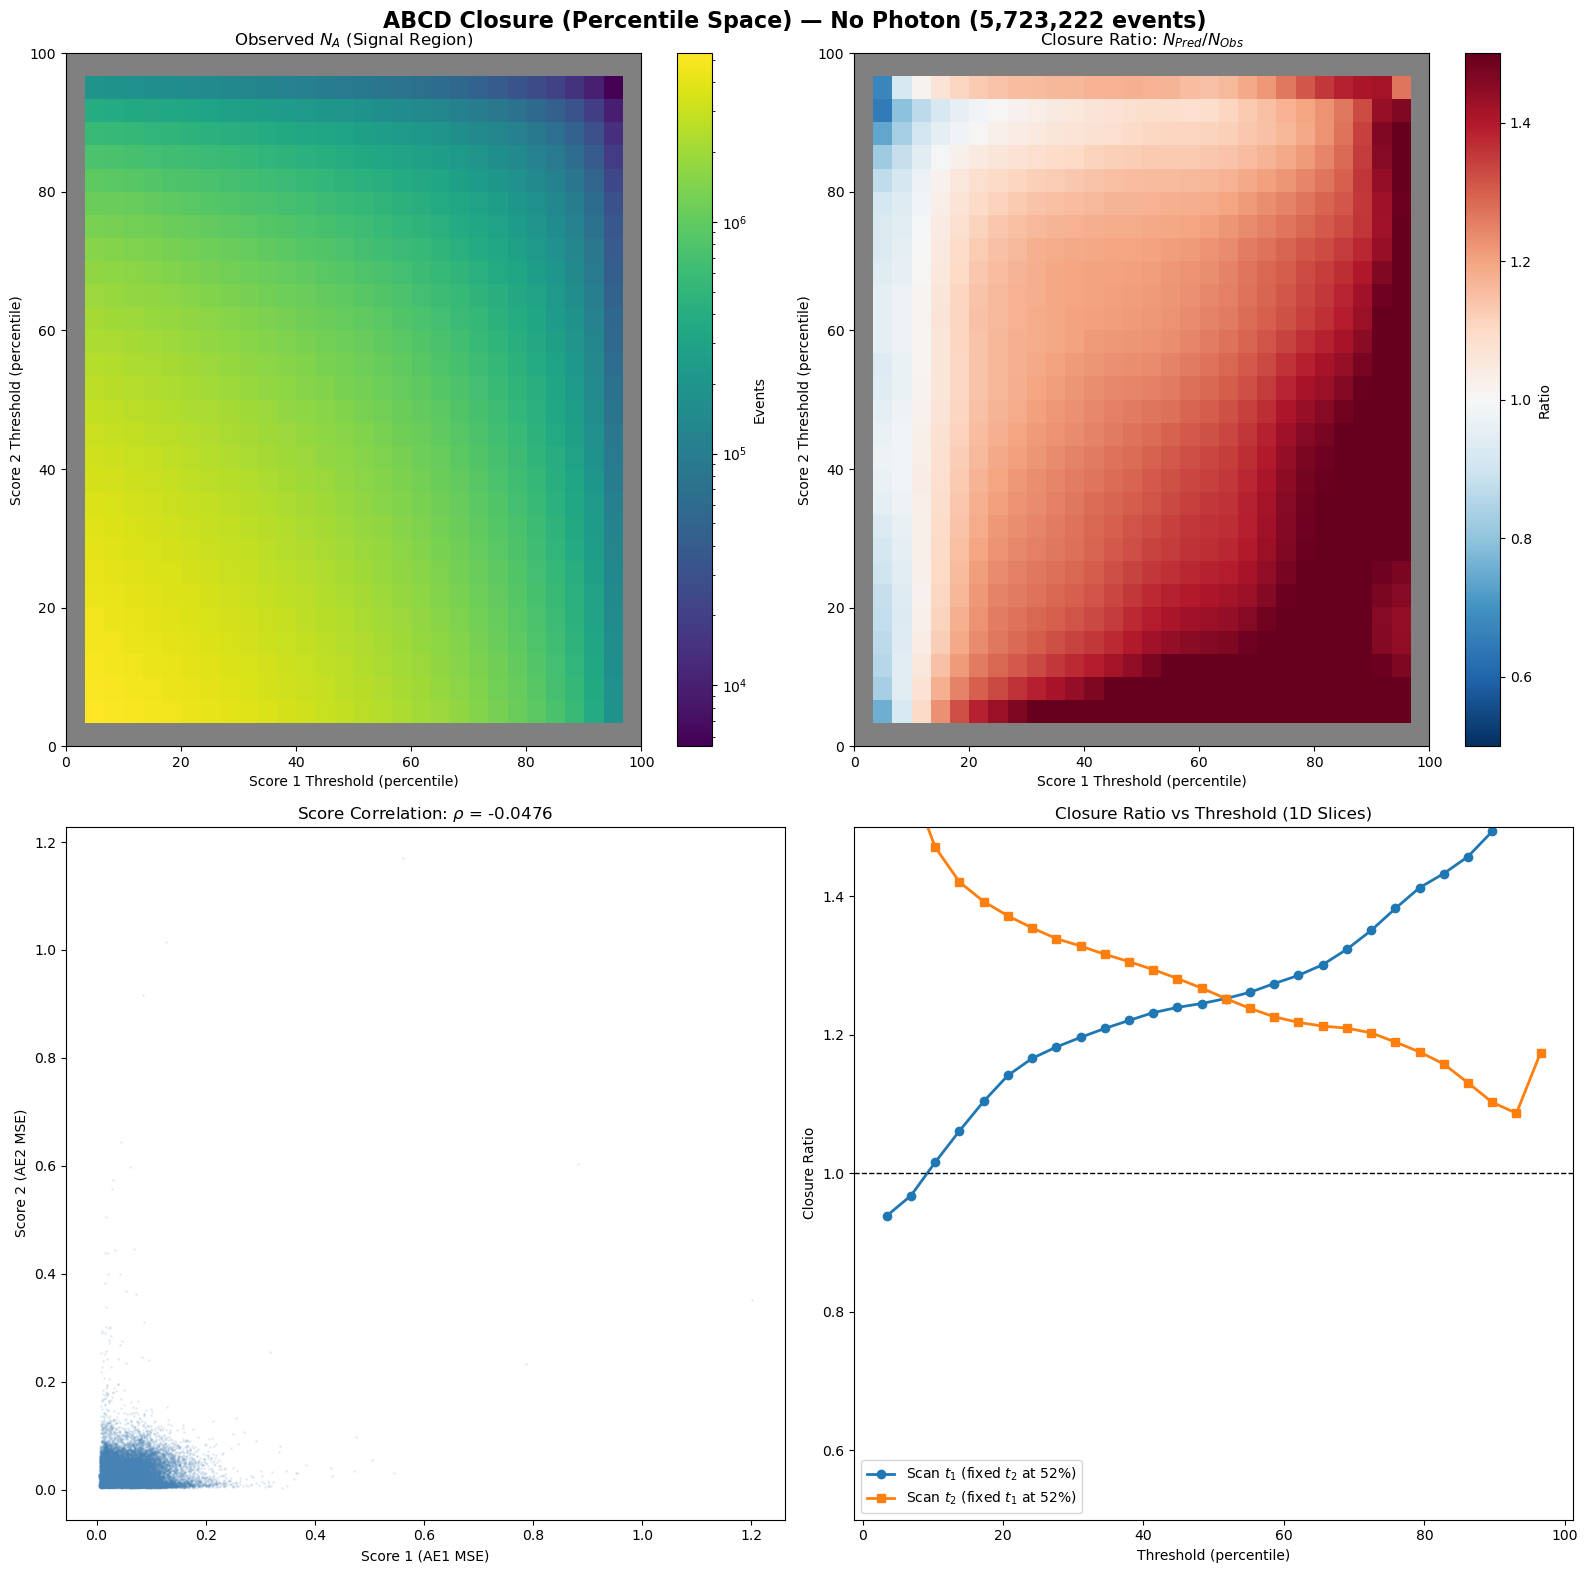

In [28]:
import matplotlib as mpl

# === Define the 6 subsets ===
subsets = {
    "2022":         test_years == 2022,
    "2023":         test_years == 2023,
    "2024":         test_years == 2024,
    "Region B+C":   np.isin(test_ABCD_label, ['B', 'C']),
    "No Electron":  test_zero_electron,
    "No Photon":    test_zero_photon,
}

n_scan = 30
scan_percentiles = np.linspace(0, 100, n_scan)

for subset_name, subset_mask in subsets.items():
    s1 = test_s_1[subset_mask]
    s2 = test_s_2[subset_mask]
    n_events = len(s1)
    
    print(f"\n=== {subset_name}: {n_events:,} events ===")
    
    scan_edges_1 = np.percentile(s1, scan_percentiles)
    scan_edges_2 = np.percentile(s2, scan_percentiles)
    
    # --- Scan ---
    n_A_obs = np.zeros((n_scan, n_scan))
    n_A_pred = np.zeros((n_scan, n_scan))
    ratio_map = np.full((n_scan, n_scan), np.nan)
    pull_map = np.full((n_scan, n_scan), np.nan)
    
    for i, t1 in enumerate(scan_edges_1):
        if i == 0:
            continue
        for j, t2 in enumerate(scan_edges_2):
            if j == 0:
                continue
            mask_A = (s1 > t1) & (s2 > t2)
            mask_B = (s1 > t1) & (s2 <= t2)
            mask_C = (s1 <= t1) & (s2 > t2)
            mask_D = (s1 <= t1) & (s2 <= t2)
            
            nA, nB, nC, nD = mask_A.sum(), mask_B.sum(), mask_C.sum(), mask_D.sum()
            n_A_obs[i, j] = nA
            
            if nD > 0:
                pred = (nB * nC) / nD
                n_A_pred[i, j] = pred
                ratio_map[i, j] = pred / nA if nA > 0 else np.nan
                pull_map[i, j] = (pred - nA) / np.sqrt(nA) if nA > 0 else np.nan
    
    valid_ratios = ratio_map[~np.isnan(ratio_map)]
    valid_pulls = pull_map[~np.isnan(pull_map)]
    
    if len(valid_ratios) > 0:
        print(f"  Median Ratio: {np.median(valid_ratios):.4f}  "
              f"Pull: {np.mean(valid_pulls):.3f} ± {np.std(valid_pulls):.3f}")
    
    # --- Plot: 2x2 ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle(f'ABCD Closure (Percentile Space) — {subset_name} ({n_events:,} events)',
                 fontsize=16, fontweight='bold')
    extent = [scan_percentiles[0], scan_percentiles[-1],
              scan_percentiles[0], scan_percentiles[-1]]
    
    # (0,0) Observed N_A
    cmap_obs = plt.cm.viridis.copy()
    cmap_obs.set_bad(color='grey')
    obs_masked = np.ma.array(n_A_obs, mask=(n_A_obs == 0))
    im1 = axes[0, 0].imshow(obs_masked.T, origin='lower', aspect='auto', extent=extent,
                              cmap=cmap_obs, norm=mpl.colors.LogNorm(vmin=max(1, n_A_obs[n_A_obs > 0].min())))
    axes[0, 0].set_title(r'Observed $N_A$ (Signal Region)')
    plt.colorbar(im1, ax=axes[0, 0], label='Events')
    
    # (0,1) Closure Ratio
    cmap_ratio = plt.cm.RdBu_r.copy()
    cmap_ratio.set_bad(color='grey')
    im2 = axes[0, 1].imshow(np.ma.array(ratio_map, mask=np.isnan(ratio_map)).T,
                              origin='lower', aspect='auto', extent=extent,
                              cmap=cmap_ratio, vmin=0.5, vmax=1.5)
    axes[0, 1].set_title(r'Closure Ratio: $N_{Pred} / N_{Obs}$')
    plt.colorbar(im2, ax=axes[0, 1], label='Ratio')
    
    for ax in axes[0]:
        ax.set_xlabel('Score 1 Threshold (percentile)')
        ax.set_ylabel('Score 2 Threshold (percentile)')
    
    # (1,0) Score correlation scatter
    n_plot = min(20000, len(s1))
    axes[1, 0].scatter(s1[:n_plot], s2[:n_plot], s=1, alpha=0.1, c='steelblue')
    corr = np.corrcoef(s1, s2)[0, 1]
    axes[1, 0].set_xlabel('Score 1 (AE1 MSE)')
    axes[1, 0].set_ylabel('Score 2 (AE2 MSE)')
    axes[1, 0].set_title(f'Score Correlation: $\\rho$ = {corr:.4f}')
    
    # (1,1) Ratio vs threshold slices
    mid_j = n_scan // 2
    mid_i = n_scan // 2
    
    ratios_vs_t1 = ratio_map[:, mid_j]
    ratios_vs_t2 = ratio_map[mid_i, :]
    
    valid_t1 = ~np.isnan(ratios_vs_t1)
    valid_t2 = ~np.isnan(ratios_vs_t2)
    
    axes[1, 1].plot(scan_percentiles[valid_t1], ratios_vs_t1[valid_t1], 'o-', color='tab:blue', lw=2,
                    label=f'Scan $t_1$ (fixed $t_2$ at {scan_percentiles[mid_j]:.0f}%)')
    axes[1, 1].plot(scan_percentiles[valid_t2], ratios_vs_t2[valid_t2], 's-', color='tab:orange', lw=2,
                    label=f'Scan $t_2$ (fixed $t_1$ at {scan_percentiles[mid_i]:.0f}%)')
    
    axes[1, 1].axhline(1.0, color='black', ls='--', lw=1)
    axes[1, 1].set_xlabel('Threshold (percentile)')
    axes[1, 1].set_ylabel('Closure Ratio')
    axes[1, 1].set_title('Closure Ratio vs Threshold (1D Slices)')
    axes[1, 1].legend()
    axes[1, 1].set_ylim(0.5, 1.5)
    
    plt.tight_layout()
    plt.show()

In [32]:
LUMINOSITY = 165.35  # fb^-1 (2022+2023+2024)
L_by_year = {2022: 29.29, 2023: 26.66, 2024: 109.4}

def calculate_dual_ae_errors(autoencoder_1, autoencoder_2, latent_data, batch_size=65536):
    reconstructed_1 = autoencoder_1.predict(latent_data, verbose=0, batch_size=batch_size)
    reconstructed_2 = autoencoder_2.predict(latent_data, verbose=0, batch_size=batch_size)
    
    s_1 = np.mean((latent_data - reconstructed_1)**2, axis=1)
    s_2 = np.mean((latent_data - reconstructed_2)**2, axis=1)
    
    return s_1, s_2

In [33]:
signal_data_dir = data_dir / "signals"
# --- Load and process signal data ---
signal_tag = "a1_b1"
signal_e = np.load(signal_data_dir / f"signal_e_{signal_tag}.npy")
signal_p = np.load(signal_data_dir / f"signal_p_{signal_tag}.npy")
signal_v = np.load(signal_data_dir / f"signal_v_{signal_tag}.npy") 
signal_t = np.load(signal_data_dir / f"signal_t_{signal_tag}.npy")  
signal_year = np.load(signal_data_dir / f"signal_year_{signal_tag}.npy")
signal_models = np.load(signal_data_dir / f"signal_models_{signal_tag}.npy")
signal_xs = np.load(signal_data_dir / f"signal_xs_{signal_tag}.npy")  # pb
signal_sumw = np.load(signal_data_dir / f"signal_sumw_{signal_tag}.npy")
signal_mcEventWeight = np.load(signal_data_dir / f"signal_mcEventWeight_{signal_tag}.npy")

In [34]:
print(f"Loaded {len(signal_e):,} total signal events")
# Get signal latent representations
print("Getting signal latent representations...")
signal_latent = get_latent_representations_accelerated(model, signal_e, signal_p, signal_t, embed_scaler, batch_size=65536)
signal_s = scaler.transform(signal_latent)

# Compute dual anomaly scores for signal
print("Computing dual anomaly scores for signal...")
signal_s_1, signal_s_2 = calculate_dual_ae_errors(saved_ae1, saved_ae2, signal_s, batch_size=65536)

# Calculate signal weights
L_ev = np.zeros_like(signal_year, dtype=float)
for yr, lumi in L_by_year.items():
    L_ev[signal_year == yr] = lumi
signal_weights = signal_mcEventWeight * (signal_xs * 1000 / signal_sumw)
signal_weights *= L_ev
print(f"Signal events: {len(signal_s_1):,} (raw), {signal_weights.sum():.2f} (weighted)")

Loaded 2,943,284 total signal events
Getting signal latent representations...
Scaling full dataset...
Running inference: 2943284 samples, batch_size=65536
Computing dual anomaly scores for signal...
Signal events: 2,943,284 (raw), 74794536.00 (weighted)


In [35]:
alt_signals = {}
for alt_name in ["dHNL", "SlepSlep"]:
    alt_dir = data_dir / "signals"
    
    alt_e = np.load(alt_dir / f"{alt_name}_e_{signal_tag}.npy")
    alt_p = np.load(alt_dir / f"{alt_name}_p_{signal_tag}.npy")
    alt_v = np.load(alt_dir / f"{alt_name}_v_{signal_tag}.npy")
    alt_t = np.load(alt_dir / f"{alt_name}_t_{signal_tag}.npy")
    alt_models = np.load(alt_dir / f"{alt_name}_models_{signal_tag}.npy")
    
    print(f"\nLoaded {len(alt_e):,} {alt_name} events")
    
    alt_latent = get_latent_representations_accelerated(model, alt_e, alt_p, alt_t, embed_scaler, batch_size=65536)
    alt_s = scaler.transform(alt_latent)
    
    alt_s_1, alt_s_2 = calculate_dual_ae_errors(saved_ae1, saved_ae2, alt_s)
    
    alt_signals[alt_name] = {
        "models": alt_models,
        "s_1": alt_s_1,
        "s_2": alt_s_2,
    }
    
    print(f"{alt_name} anomaly scores computed: {len(alt_s_1):,} events")
dHNL_s1 = alt_signals["dHNL"]["s_1"]
slep_models = alt_signals["SlepSlep"]["models"]


Loaded 60,098 dHNL events
Scaling full dataset...
Running inference: 60098 samples, batch_size=65536
dHNL anomaly scores computed: 60,098 events

Loaded 822,496 SlepSlep events
Scaling full dataset...
Running inference: 822496 samples, batch_size=65536
SlepSlep anomaly scores computed: 822,496 events


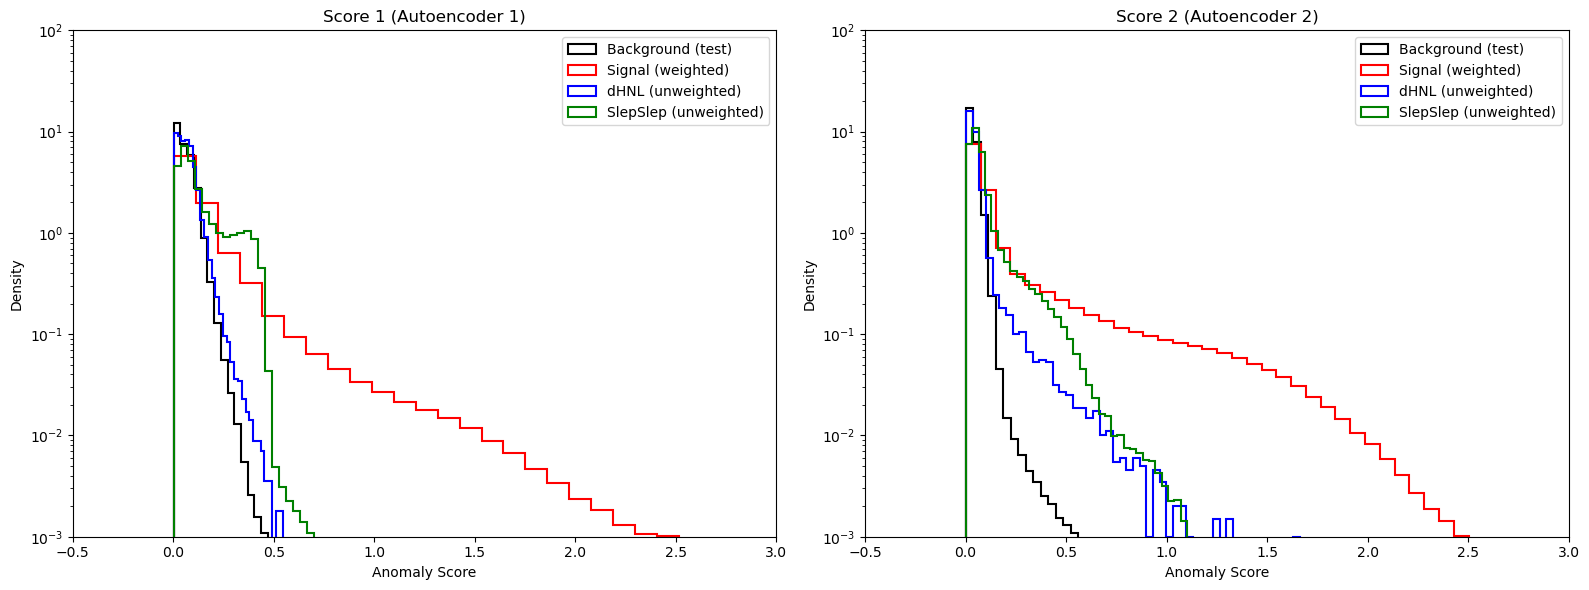

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

score_data = [
    ("Score 1 (Autoencoder 1)", test_s_1, signal_s_1, signal_weights),
    ("Score 2 (Autoencoder 2)", test_s_2, signal_s_2, signal_weights),
]

for ax, (title, t_s, sig_s, sig_w) in zip(axes, score_data):
    # Background (test data)
    ax.hist(t_s, bins=50, density=True, histtype='step', linewidth=1.5,
            label="Background (test)", color='black')
    
    # Weighted signal (all models combined)
    ax.hist(sig_s, bins=50, density=True, weights=sig_w, histtype='step',
            linewidth=1.5, label="Signal (weighted)", color='red')
    
    # dHNL (unweighted)
    ax.hist(alt_signals["dHNL"]["s_1" if "1" in title else "s_2"],
            bins=50, density=True, histtype='step', linewidth=1.5,
            label="dHNL (unweighted)", color='blue')
    
    # SlepSlep (unweighted)
    ax.hist(alt_signals["SlepSlep"]["s_1" if "1" in title else "s_2"],
            bins=50, density=True, histtype='step', linewidth=1.5,
            label="SlepSlep (unweighted)", color='green')
    
    ax.set_xlabel("Anomaly Score")
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(1e-3, 100)
    ax.set_xlim(-0.5, 3)
    # ax.set_xscale('log')

fig.tight_layout()
plt.savefig(data_dir / "dual_ae_score_distributions.png", dpi=600, bbox_inches='tight')
plt.show()

Best SIC = 13.746
  Thresholds: s_1 > 0.4530, s_2 > 0.6867
  TPR = 0.0283, FPR = 0.000004


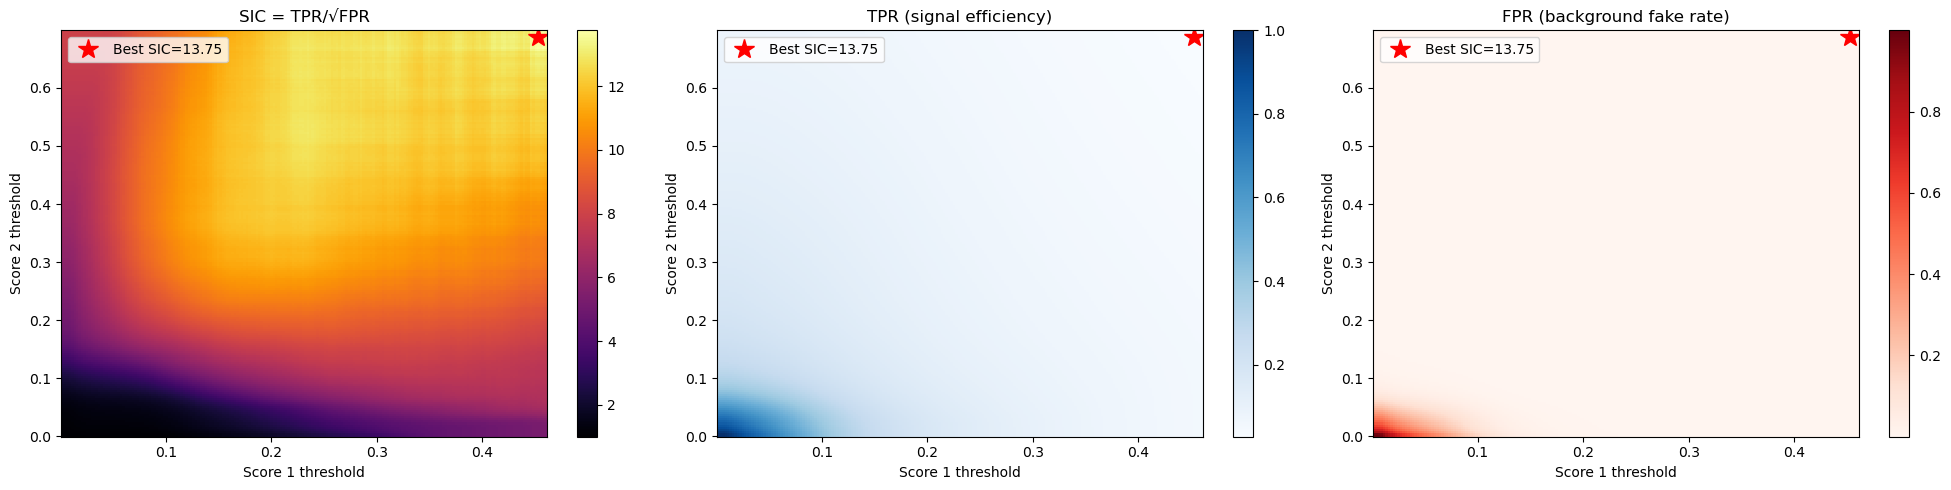

In [51]:
def scan_2d_sic(test_s_1, test_s_2, signal_s_1, signal_s_2,
                signal_weights, test_weights=None, n_bins=200):
    if test_weights is None:
        test_weights = np.ones(len(test_s_1))
    
    total_signal_w = np.sum(signal_weights)
    total_test_w = np.sum(test_weights)
    
    t1_edges = np.linspace(test_s_1.min(), np.percentile(test_s_1, 99.99), n_bins)
    t2_edges = np.linspace(test_s_2.min(), np.percentile(test_s_2, 99.99), n_bins)
   
    # Vectorized: (n_bins, n_events) boolean masks
    sig_pass_1 = signal_s_1[None, :] > t1_edges[:, None]  # (n_bins, n_sig)
    sig_pass_2 = signal_s_2[None, :] > t2_edges[:, None]  # (n_bins, n_sig)
    bkg_pass_1 = test_s_1[None, :] > t1_edges[:, None]    # (n_bins, n_test)
    bkg_pass_2 = test_s_2[None, :] > t2_edges[:, None]    # (n_bins, n_test)
    
    # Weighted pass counts: (n_bins, n_events) * weights -> sum over events
    # For each t1 threshold, compute weighted signal passing t1
    sig_w_pass_1 = (sig_pass_1 * signal_weights[None, :])  # (n_bins, n_sig)
    bkg_w_pass_1 = (bkg_pass_1 * test_weights[None, :])    # (n_bins, n_test)
    
    # For combined cut: tpr[i,j] = sum(w * (s1 > t1[i]) * (s2 > t2[j])) / total
    # Use matrix multiplication: sig_w_pass_1 @ sig_pass_2.T
    tpr_map = (sig_w_pass_1 @ sig_pass_2.T) / total_signal_w   # (n_bins, n_bins)
    fpr_map = (bkg_w_pass_1 @ bkg_pass_2.T) / total_test_w     # (n_bins, n_bins)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        sic_map = np.where(fpr_map > 0, tpr_map / np.sqrt(fpr_map), 0)
    
    # Find best
    idx = np.unravel_index(np.argmax(sic_map), sic_map.shape)
    best_t1, best_t2 = t1_edges[idx[0]], t2_edges[idx[1]]
    best_sic = sic_map[idx]
    best_tpr = tpr_map[idx]
    best_fpr = fpr_map[idx]
    
    print(f"Best SIC = {best_sic:.3f}")
    print(f"  Thresholds: s_1 > {best_t1:.4f}, s_2 > {best_t2:.4f}")
    print(f"  TPR = {best_tpr:.4f}, FPR = {best_fpr:.6f}")
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ax, (data, label, cmap) in zip(axes, [
        (sic_map.T, "SIC = TPR/√FPR", "inferno"),
        (tpr_map.T, "TPR (signal efficiency)", "Blues"),
        (fpr_map.T, "FPR (background fake rate)", "Reds"),
    ]):
        im = ax.pcolormesh(t1_edges, t2_edges, data, cmap=cmap, shading='auto')
        ax.set_xlabel("Score 1 threshold")
        ax.set_ylabel("Score 2 threshold")
        ax.set_title(label)
        ax.plot(best_t1, best_t2, 'r*', markersize=15, label=f'Best SIC={best_sic:.2f}')
        ax.legend()
        plt.colorbar(im, ax=ax)
    
    fig.tight_layout()
    plt.savefig(data_dir / "sic_2d_scan.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    return best_t1, best_t2, best_sic, best_tpr, best_fpr, sic_map, t1_edges, t2_edges

best_t1, best_t2, best_sic, best_tpr, best_fpr, sic_map, t1_edges, t2_edges = \
    scan_2d_sic(test_s_1, test_s_2, signal_s_1, signal_s_2, signal_weights)

In [102]:
def scan_2d_sic_with_closure(test_s_1, test_s_2, signal_s_1, signal_s_2,
                              signal_weights, test_weights=None, n_bins=300,
                              closure_range=(0.9, 1.1)):
    if test_weights is None:
        test_weights = np.ones(len(test_s_1))
    
    total_signal_w = np.sum(signal_weights)
    total_test_w = np.sum(test_weights)
    n_total = len(test_s_1)
    
    t1_edges = np.linspace(np.percentile(test_s_1, 20), np.percentile(test_s_1, 99.99), n_bins)
    t2_edges = np.linspace(np.percentile(test_s_2, 20), np.percentile(test_s_2, 99.99), n_bins)
    
    # --- Boolean masks (n_bins, n_events) ---
    sig_pass_1 = signal_s_1[None, :] > t1_edges[:, None]
    sig_pass_2 = signal_s_2[None, :] > t2_edges[:, None]
    bkg_pass_1 = test_s_1[None, :] > t1_edges[:, None]
    bkg_pass_2 = test_s_2[None, :] > t2_edges[:, None]
    
    # --- SIC maps ---
    tpr_map = (sig_pass_1 * signal_weights[None, :]) @ sig_pass_2.T / total_signal_w
    fpr_map = (bkg_pass_1 * test_weights[None, :]) @ bkg_pass_2.T / total_test_w
    
    with np.errstate(divide='ignore', invalid='ignore'):
        sic_map = np.where(fpr_map > 0, tpr_map / np.sqrt(fpr_map), 0)
    
    # --- ABCD closure (fully vectorized) ---
    # nA[i,j] = count(s1 > t1[i] AND s2 > t2[j])
    bkg_1_f = bkg_pass_1.astype(np.float32)
    bkg_2_f = bkg_pass_2.astype(np.float32)
    
    nA_map = bkg_1_f @ bkg_2_f.T                              # (n_bins, n_bins)
    sum_pass_1 = bkg_1_f.sum(axis=1)                           # (n_bins,)
    sum_pass_2 = bkg_2_f.sum(axis=1)                           # (n_bins,)
    
    nB_map = sum_pass_1[:, None] - nA_map                      # s1 > t1, s2 <= t2
    nC_map = sum_pass_2[None, :] - nA_map                      # s1 <= t1, s2 > t2
    nD_map = n_total - sum_pass_1[:, None] - sum_pass_2[None, :] + nA_map
    
    with np.errstate(divide='ignore', invalid='ignore'):
        closure_map = np.where(
            (nD_map > 0) & (nA_map > 0),
            (nB_map * nC_map) / (nD_map * nA_map),
            np.nan
        )
    
    # --- Apply closure constraint ---
    valid_closure = (closure_map >= closure_range[0]) & (closure_map <= closure_range[1])
    sic_constrained = np.where(valid_closure, sic_map, 0)
    
    n_valid = np.sum(valid_closure)
    print(f"Bins passing closure {closure_range}: {n_valid} / {(n_bins-1)**2}")
    
    idx = np.unravel_index(np.argmax(sic_constrained), sic_constrained.shape)
    best_t1, best_t2 = t1_edges[idx[0]], t2_edges[idx[1]]
    best_sic = sic_constrained[idx]
    best_tpr = tpr_map[idx]
    best_fpr = fpr_map[idx]
    best_closure = closure_map[idx]
    
    print(f"Best SIC = {best_sic:.3f}")
    print(f"  Thresholds: s_1 > {best_t1:.4f}, s_2 > {best_t2:.4f}")
    print(f"  TPR = {best_tpr:.4f}, FPR = {best_fpr:.6f}")
    print(f"  Closure ratio = {best_closure:.4f}")
    
    # --- Plots ---
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    for ax, (data, label, cmap) in zip(axes[0], [
        (sic_constrained.T, f"SIC (closure ∈ {closure_range})", "inferno"),
        (closure_map.T, "ABCD Closure Ratio", "RdBu_r"),
    ]):
        if "Closure" in label:
            im = ax.pcolormesh(t1_edges, t2_edges,
                               np.ma.array(data, mask=np.isnan(data)),
                               cmap=cmap, shading='auto', vmin=0.5, vmax=1.5)
        else:
            im = ax.pcolormesh(t1_edges, t2_edges, data, cmap=cmap, shading='auto')
        ax.set_xlabel("Score 1 threshold")
        ax.set_ylabel("Score 2 threshold")
        ax.set_title(label)
        ax.plot(best_t1, best_t2, 'r*', markersize=15)
        ax.annotate(f'Best SIC={best_sic:.2f}', (best_t1, best_t2),
                    textcoords="offset points", xytext=(0, 24),
                    fontsize=9, color='red', ha='center', va='top')
        ax.legend()
        plt.colorbar(im, ax=ax)
    
    for ax, (data, label, cmap) in zip(axes[1], [
        (tpr_map.T, "TPR (signal efficiency)", "Blues"),
        (fpr_map.T, "FPR (background fake rate)", "Reds"),
    ]):
        im = ax.pcolormesh(t1_edges, t2_edges, data, cmap=cmap, shading='auto')
        ax.set_xlabel("Score 1 threshold")
        ax.set_ylabel("Score 2 threshold")
        ax.set_title(label)
        ax.plot(best_t1, best_t2, 'r*', markersize=15)
        plt.colorbar(im, ax=ax)
    
    fig.tight_layout()
    plt.savefig(data_dir / "sic_2d_scan_with_closure.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    return best_t1, best_t2, best_sic, best_tpr, best_fpr, best_closure, sic_map, closure_map, t1_edges, t2_edges

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Bins passing closure (0.9, 1.1): 8947 / 89401
Best SIC = 9.326
  Thresholds: s_1 > 0.0774, s_2 > 0.3109
  TPR = 0.1407, FPR = 0.000228
  Closure ratio = 0.9037


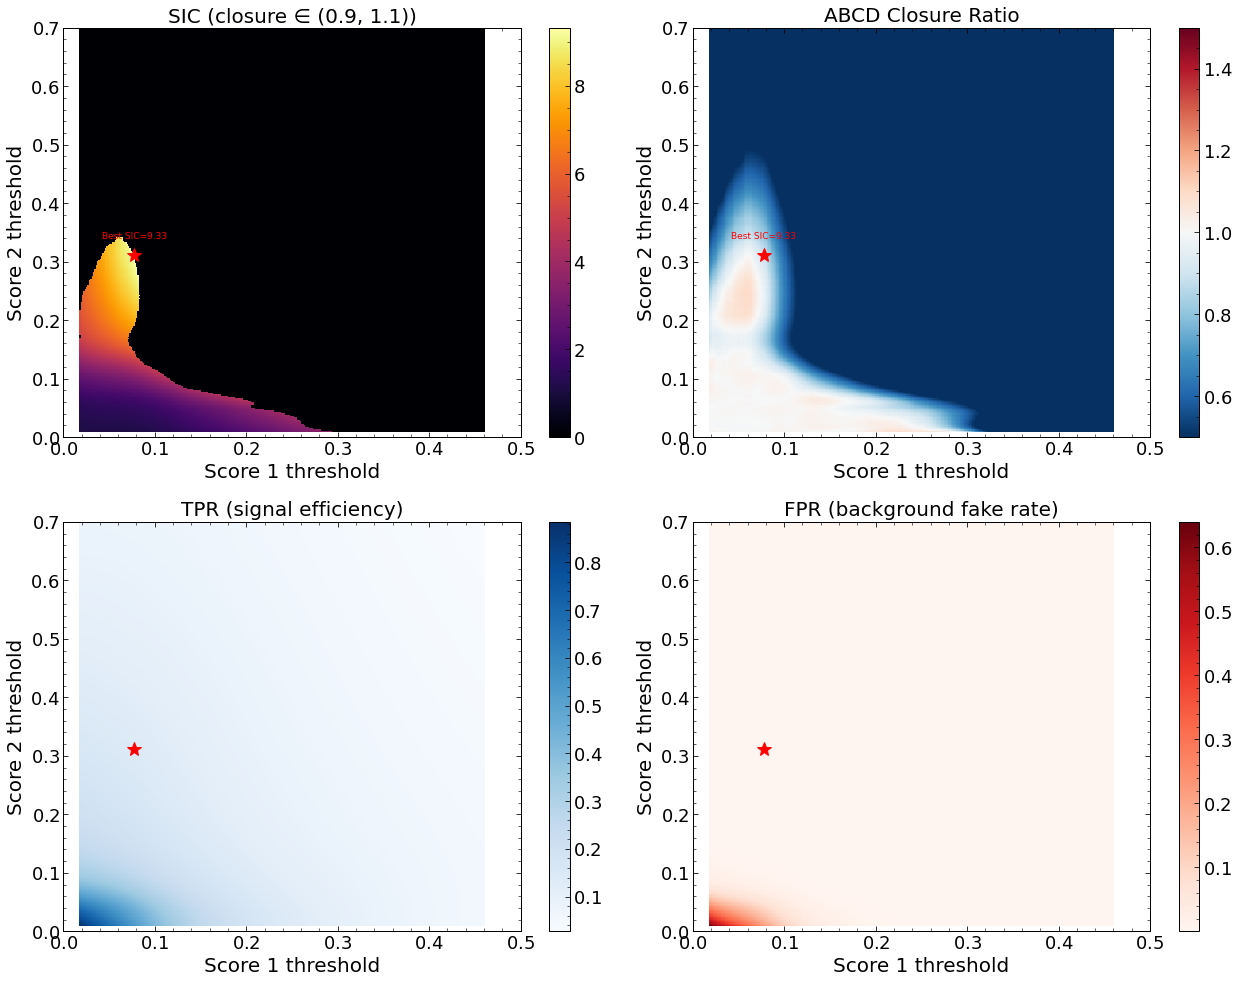

In [103]:
best_t1, best_t2, best_sic, best_tpr, best_fpr, best_closure, sic_map, closure_map, t1_edges, t2_edges = \
    scan_2d_sic_with_closure(test_s_1, test_s_2, signal_s_1, signal_s_2, signal_weights)

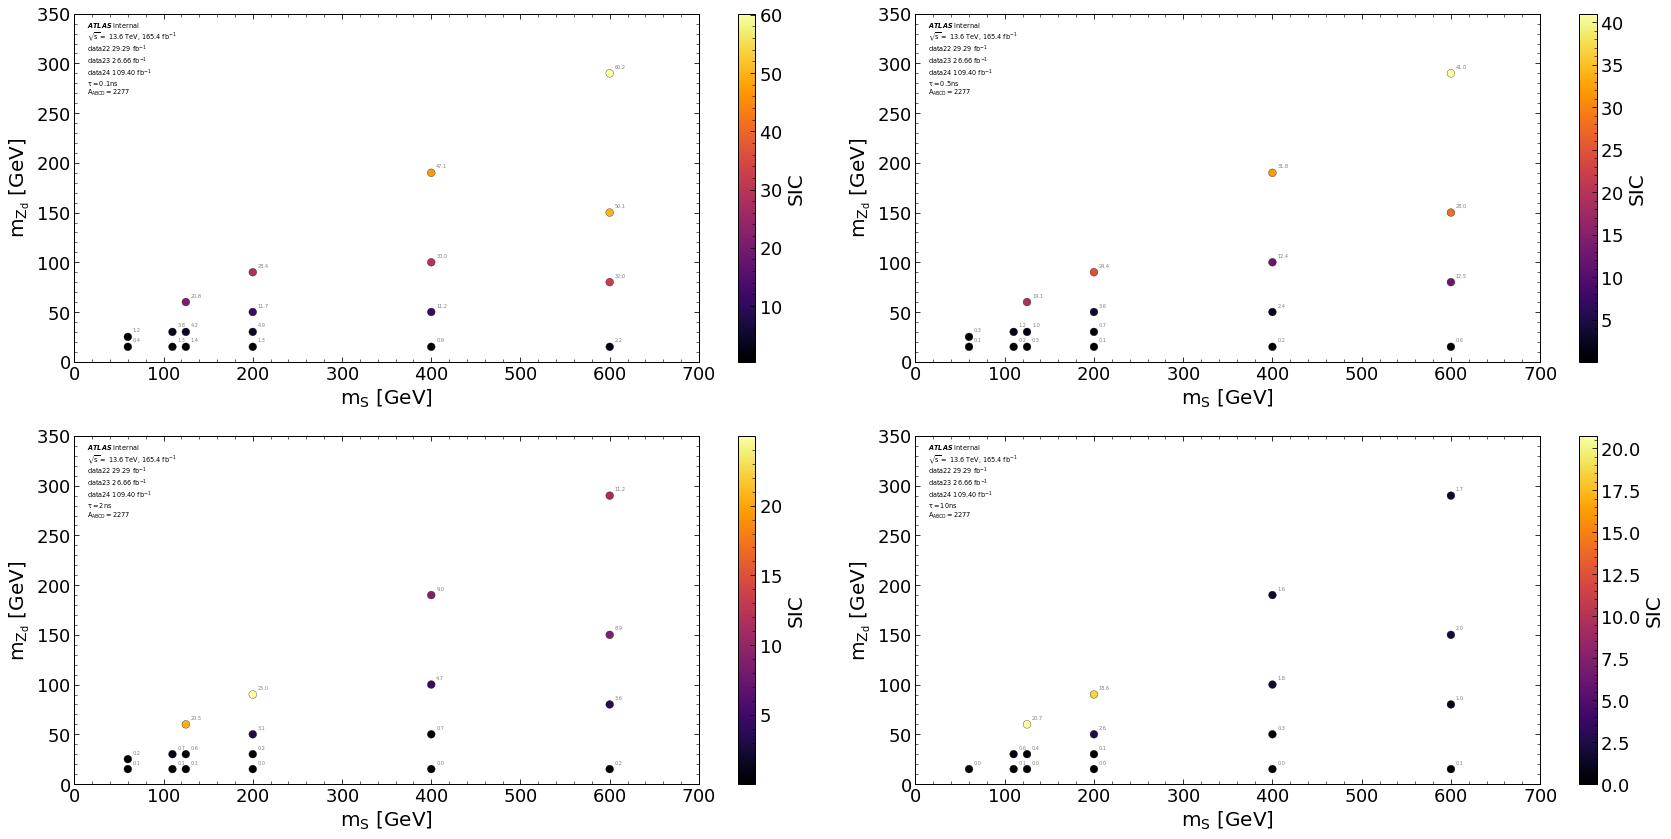

In [104]:
import atlas_mpl_style as ampl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
matplotlib.rcParams['font.family'] = 'Liberation Sans'
# Style + font sizes
ampl.use_atlas_style(usetex=True)
SMALL, MED, LARGE = 6, 7, 9
FS_ATLAS = 6.5
RC_TWEAK = {
    "axes.titlesize": MED,
    "axes.labelsize": MED,
    "xtick.labelsize": SMALL,
    "ytick.labelsize": SMALL,
    "legend.fontsize": SMALL,
    "figure.titlesize": LARGE,
}

# Luminosity info
L22, L23, L24 = 29.29, 26.66, 109.4
LUMI_TOT = L22 + L23 + L24
PER_YEAR = rf"data22 {L22:.2f} fb$^{{-1}}$" + "\n" + rf"data23 {L23:.2f} fb$^{{-1}}$" + "\n" + rf"data24 {L24:.2f} fb$^{{-1}}$"

def plot_sic_per_lifetime(signal_s_1, signal_s_2, signal_weights, signal_models,
                          test_s_1, test_s_2, test_weights,
                          best_t1, best_t2, best_closure):
    """
    For each unique lifetime, plot SIC on the (mass_1, mass_2) plane.
    signal_models entries are like "1000_0_10ns"
    """
    if test_weights is None:
        test_weights = np.ones(len(test_s_1))
    
    total_test_w = np.sum(test_weights)
    
    # Background FPR at best cut (shared across all models)
    bkg_pass = (test_s_1 > best_t1) & (test_s_2 > best_t2)
    fpr = np.sum(test_weights[bkg_pass]) / total_test_w
    
    # Background prediction from ABCD at best cut
    mask_A = (test_s_1 > best_t1) & (test_s_2 > best_t2)
    mask_B = (test_s_1 > best_t1) & (test_s_2 <= best_t2)
    mask_C = (test_s_1 <= best_t1) & (test_s_2 > best_t2)
    mask_D = (test_s_1 <= best_t1) & (test_s_2 <= best_t2)
    nB, nC, nD = np.sum(mask_B), np.sum(mask_C), np.sum(mask_D)
    n_A_predicted_full = (nB * nC) / nD if nD > 0 else 0
    
    # Parse models into (mass1, mass2, lifetime)
    unique_models = np.unique(signal_models)
    model_info = {}
    for m in unique_models:
        parts = m.split('_')
        mass1 = float(parts[0])
        mass2 = float(parts[1])
        lifetime = parts[2]
        model_info[m] = (mass1, mass2, lifetime)
    
    # Compute per-model SIC
    model_sic = {}
    for m in unique_models:
        mask = signal_models == m
        w = signal_weights[mask]
        s1 = signal_s_1[mask]
        s2 = signal_s_2[mask]
        
        sig_pass = (s1 > best_t1) & (s2 > best_t2)
        tpr = np.sum(w[sig_pass]) / np.sum(w) if np.sum(w) > 0 else 0
        sic = tpr / np.sqrt(fpr) if fpr > 0 else 0
        model_sic[m] = sic
    
    # Group by lifetime
    lifetimes = sorted(set(lt for _, _, lt in model_info.values()),
                       key=lambda x: float(x.replace('ns', '').replace('p', '.')))
    
    n_lt = len(lifetimes)
    ncols = min(2, n_lt)
    nrows = (n_lt + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 6 * nrows))
    if n_lt == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, lt in enumerate(lifetimes):
        ax = axes[idx]
        
        # Collect points for this lifetime
        masses_1, masses_2, sics = [], [], []
        for m, (m1, m2, lifetime) in model_info.items():
            if lifetime == lt:
                masses_1.append(m1)
                masses_2.append(m2)
                sics.append(model_sic[m])
        
        masses_1 = np.array(masses_1)
        masses_2 = np.array(masses_2)
        sics = np.array(sics)
        
        sc = ax.scatter(masses_1, masses_2, c=sics, cmap='inferno',
                        s=60, edgecolors='black', linewidths=0.3, zorder=5)
        plt.colorbar(sc, ax=ax, label='SIC')
        
        # Annotate each point with SIC value
        for m1, m2, s in zip(masses_1, masses_2, sics):
            ax.annotate(f'{s:.1f}', (m1, m2), textcoords="offset points",
                        xytext=(5, 5), fontsize=5, color='grey')
        
        ax.set_xlabel(r'$m_S$ [GeV]')
        ax.set_ylabel(r'$m_{Z_d}$ [GeV]')
        
        # ATLAS label
        desc = (PER_YEAR + "\n"
                + rf"$\tau = {lt}$" + "\n"
                + rf"$A_{{\mathrm{{ABCD}}}} = {n_A_predicted_full:.0f}$")
        ampl.plot.draw_atlas_label(
            0.02, 0.98, ax=ax,
            status="int", energy="13.6 TeV", lumi=LUMI_TOT, desc=desc,
            fontsize=FS_ATLAS, linespacing=1.05
        )
    
    # Hide unused axes
    for idx in range(n_lt, len(axes)):
        axes[idx].set_visible(False)
    
    fig.tight_layout()
    plt.savefig(data_dir / "sic_mass_plane_per_lifetime.png", dpi=300, bbox_inches='tight')
    plt.show()


# Call it
plot_sic_per_lifetime(
    signal_s_1, signal_s_2, signal_weights, signal_models,
    test_s_1, test_s_2, test_weights=None,
    best_t1=best_t1, best_t2=best_t2, best_closure=best_closure
)

ABCD predicted (raw): 2277.3
Scale factor: 3.4021
ABCD predicted (scaled): 7747.7


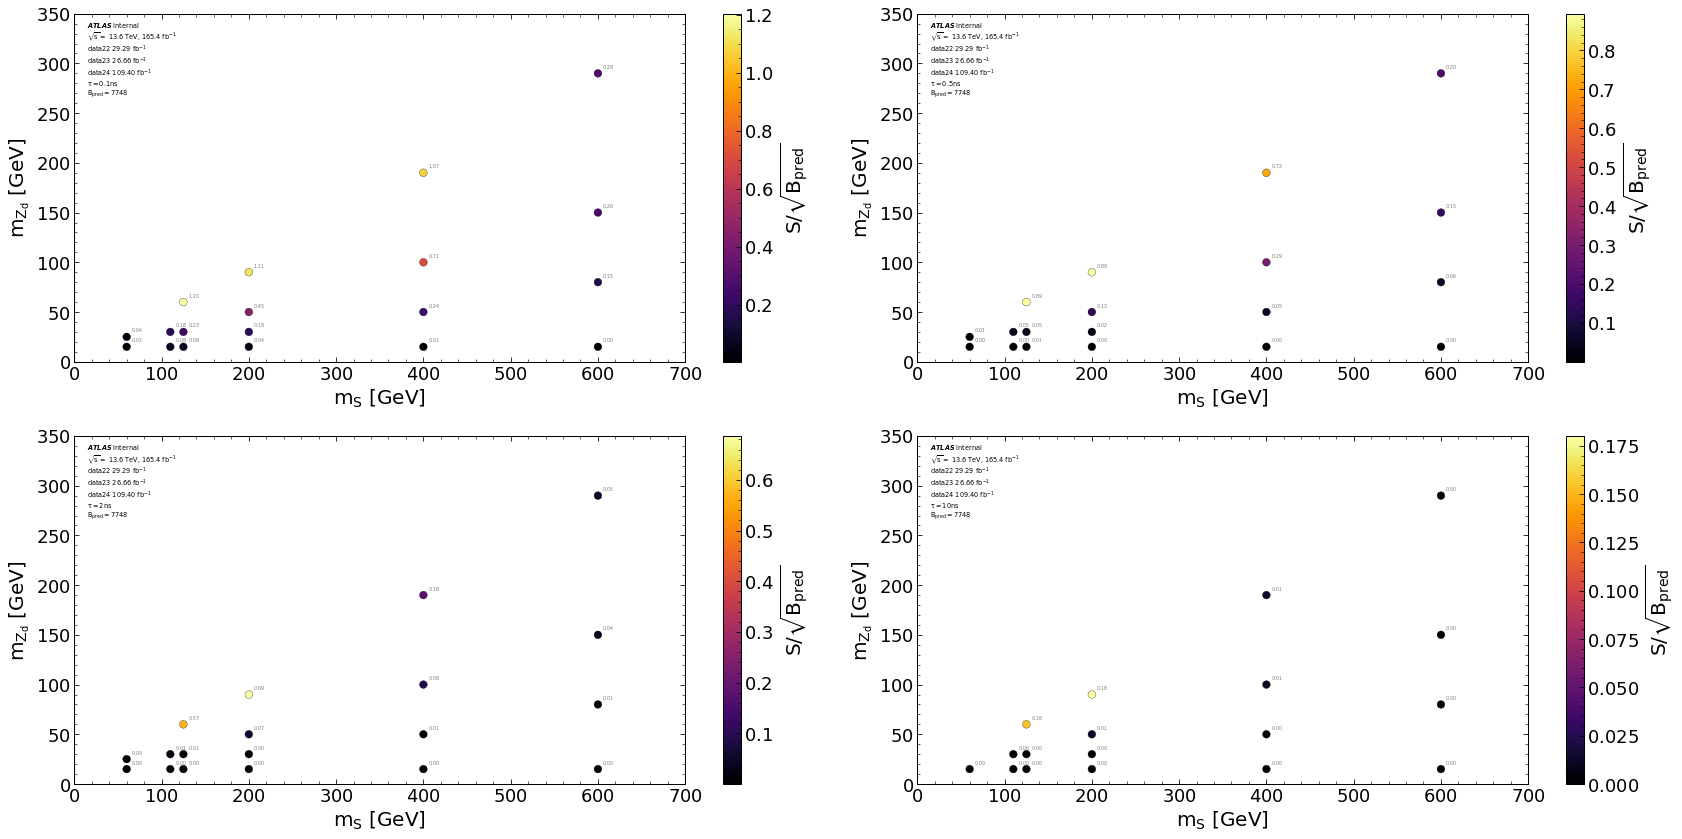

In [105]:
def plot_significance_per_lifetime(signal_s_1, signal_s_2, signal_weights, signal_models,
                                    test_s_1, test_s_2, test_weights,
                                    best_t1, best_t2, best_closure,
                                    scale_factor= 2 * 37_676_402 / (3_483_773 + 6_924_986 + 11_740_069)):
    if test_weights is None:
        test_weights = np.ones(len(test_s_1))
    
    # Background prediction from ABCD at best cut
    mask_B = (test_s_1 > best_t1) & (test_s_2 <= best_t2)
    mask_C = (test_s_1 <= best_t1) & (test_s_2 > best_t2)
    mask_D = (test_s_1 <= best_t1) & (test_s_2 <= best_t2)
    nB, nC, nD = np.sum(mask_B), np.sum(mask_C), np.sum(mask_D)
    n_A_predicted = (nB * nC) / nD if nD > 0 else 0
    n_A_scaled = n_A_predicted * scale_factor
    
    print(f"ABCD predicted (raw): {n_A_predicted:.1f}")
    print(f"Scale factor: {scale_factor:.4f}")
    print(f"ABCD predicted (scaled): {n_A_scaled:.1f}")
    
    # Parse models
    unique_models = np.unique(signal_models)
    model_info = {}
    for m in unique_models:
        parts = m.split('_')
        mass1 = float(parts[0])
        mass2 = float(parts[1])
        lifetime = parts[2]
        model_info[m] = (mass1, mass2, lifetime)
    
    # Compute per-model S / sqrt(B_pred_scaled)
    model_significance = {}
    for m in unique_models:
        mask = signal_models == m
        w = signal_weights[mask]
        s1 = signal_s_1[mask]
        s2 = signal_s_2[mask]
        
        sig_pass = (s1 > best_t1) & (s2 > best_t2)
        S = np.sum(w[sig_pass])
        significance = 0.0001 * S / np.sqrt(n_A_scaled) if n_A_scaled > 0 else 0
        model_significance[m] = significance
    
    # Group by lifetime
    lifetimes = sorted(set(lt for _, _, lt in model_info.values()),
                       key=lambda x: float(x.replace('ns', '').replace('p', '.')))
    
    n_lt = len(lifetimes)
    ncols = min(2, n_lt)
    nrows = (n_lt + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 6 * nrows))
    if n_lt == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, lt in enumerate(lifetimes):
        ax = axes[idx]
        
        masses_1, masses_2, sigs = [], [], []
        for m, (m1, m2, lifetime) in model_info.items():
            if lifetime == lt:
                masses_1.append(m1)
                masses_2.append(m2)
                sigs.append(model_significance[m])
        
        masses_1 = np.array(masses_1)
        masses_2 = np.array(masses_2)
        sigs = np.array(sigs)
        
        sc = ax.scatter(masses_1, masses_2, c=sigs, cmap='inferno',
                        s=60, edgecolors='black', linewidths=0.3, zorder=5)
        plt.colorbar(sc, ax=ax, label=r'$S / \sqrt{B_{\mathrm{pred}}}$')
        
        for m1, m2, s in zip(masses_1, masses_2, sigs):
            ax.annotate(f'{s:.2f}', (m1, m2), textcoords="offset points",
                        xytext=(5, 5), fontsize=5, color='grey')
        
        ax.set_xlabel(r'$m_S$ [GeV]')
        ax.set_ylabel(r'$m_{Z_d}$ [GeV]')
        
        desc = (PER_YEAR + "\n"
                + rf"$\tau = {lt}$" + "\n"
                + rf"$B_{{\mathrm{{pred}}}} = {n_A_scaled:.0f}$")
        ampl.plot.draw_atlas_label(
            0.02, 0.98, ax=ax,
            status="int", energy="13.6 TeV", lumi=LUMI_TOT, desc=desc,
            fontsize=FS_ATLAS, linespacing=1.05
        )
    
    for idx in range(n_lt, len(axes)):
        axes[idx].set_visible(False)
    
    fig.tight_layout()
    plt.savefig(data_dir / "significance_mass_plane_per_lifetime.png", dpi=300, bbox_inches='tight')
    plt.show()


plot_significance_per_lifetime(
    signal_s_1, signal_s_2, signal_weights, signal_models,
    test_s_1, test_s_2, test_weights=None,
    best_t1=best_t1, best_t2=best_t2, best_closure=best_closure
)